# Imports

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from scipy.stats import pointbiserialr, chi2_contingency

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Wrapper Methods
from sklearn.feature_selection import RFE, RFECV

# Embedded Methods
from sklearn.linear_model import LassoCV

# Encoders
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Scaling methods
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# Model selection and evalutation 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

## Import the datasets

In [2]:
sample_submission = pd.read_csv('https://raw.githubusercontent.com/Sebastiao199/Project_Group18_ML/main/sample_submission.csv')
sample_submission.head()

,encounter_id,readmitted_binary
0,499502,No
1,447319,No
2,309126,Yes
3,181183,Yes
4,359339,No


In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/Sebastiao199/Project_Group18_ML/main/train.csv', na_values=['?', ''], index_col='encounter_id')
train.head()

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,USA,70110,Caucasian,Female,[70-80),NaN,NaN,0,0,2,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
426224,USA,29775006,AfricanAmerican,Male,[50-60),NaN,NaN,0,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
634063,USA,80729253,Caucasian,Female,[60-70),NaN,NaN,0,0,1,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
890610,USA,2919042,AfricanAmerican,Male,[60-70),NaN,MC,0,0,1,...,562,455,5,NaN,NaN,No,No,[],No,No
654194,USA,84871971,Caucasian,Female,[70-80),NaN,HM,1,0,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


# Exploration

In [4]:
print(train.shape)
print(train.columns)

(71236, 30)
Index(['country', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass'],
      dtype='object')


## Check duplicates

In [5]:
train_duplicated = train.loc[train.duplicated(), :]
train_duplicated

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,


In [6]:
train['country'].unique()

array(['USA'], dtype=object)

In [7]:
train.drop('country', axis=1, inplace=True)

## Check missing values

In [8]:
for col in train.columns:
    print( '{}-{}%'.format(col, round(np.mean(train[col].isnull()) * 100 , 2)) )

patient_id-0.0%
race-7.12%
gender-0.0%
age-4.99%
weight-96.85%
payer_code-39.59%
outpatient_visits_in_previous_year-0.0%
emergency_visits_in_previous_year-0.0%
inpatient_visits_in_previous_year-0.0%
admission_type-5.2%
medical_specialty-49.02%
average_pulse_bpm-0.0%
discharge_disposition-3.64%
admission_source-6.62%
length_of_stay_in_hospital-0.0%
number_lab_tests-0.0%
non_lab_procedures-0.0%
number_of_medications-0.0%
primary_diagnosis-0.02%
secondary_diagnosis-0.37%
additional_diagnosis-1.42%
number_diagnoses-0.0%
glucose_test_result-94.82%
a1c_test_result-83.27%
change_in_meds_during_hospitalization-0.0%
prescribed_diabetes_meds-0.0%
medication-0.0%
readmitted_binary-0.0%
readmitted_multiclass-0.0%


In [9]:
# weight is 97% missing values
train.drop('weight', axis=1, inplace=True)

In [10]:
train['race'].fillna('Unknown', inplace=True)
train['age'].fillna('Unknown', inplace=True)
train['payer_code'].fillna('None', inplace=True)
train['admission_type'].fillna('Unknown', inplace=True)
train['medical_specialty'].fillna('Unknown', inplace=True)
train['discharge_disposition'].fillna('Unknown', inplace=True)
train['admission_source'].fillna('Unknown', inplace=True)
train['primary_diagnosis'].fillna('Unknown', inplace=True)
train['secondary_diagnosis'].fillna('Unknown', inplace=True)
train['additional_diagnosis'].fillna('Unknown', inplace=True)
train['glucose_test_result'].fillna('Not_taken', inplace=True)
train['a1c_test_result'].fillna('Not_taken', inplace=True)

In [11]:
train.isna().sum()

patient_id                               0
race                                     0
gender                                   0
age                                      0
payer_code                               0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
average_pulse_bpm                        0
discharge_disposition                    0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_result                          0
change_in_m

# Feature Engineering

In [12]:
new_column_names = {'outpatient_visits_in_previous_year': 'outpatient_visits', 
                    'emergency_visits_in_previous_year': 'emergency_visits',
                    'inpatient_visits_in_previous_year': 'inpatient_visits',
                    'change_in_meds_during_hospitalization': 'change_in_meds',
                    'length_of_stay_in_hospital': 'length_of_stay'}
train = train.rename(columns=new_column_names)

In [13]:
train['readmitted_multiclass'].unique()

array(['>30 days', 'No', '<30 days'], dtype=object)

In [14]:
# Proportion Bar Chart: Feature Distribution with Respect to Multiclass Target Variable
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins=True)
    categories = cont_tab.index[:-1]    
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 2].values, cont_tab.iloc[:-1, 3].values), # No
                        np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 3].values), # <30 days
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 3].values) # >30 days
    ])
    fig = plt.figure(figsize=(50, 10))
    
    plt.subplot(122)
    p0 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p1 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    p2 = plt.bar(categories, obs_pct[2], 0.55, bottom=obs_pct[0]+obs_pct[1], color="SteelBlue")

    plt.xticks(rotation=45, ha="right")
    
    plt.legend((p0[0], p1[0], p2[0]), ('No', '<30 days', '>30 days', ))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.show()

### race

In [15]:
train['race'].value_counts()

race
Caucasian          50693
AfricanAmerican    12693
Unknown             5070
Hispanic            1364
Other                995
Asian                421
Name: count, dtype: int64

In [16]:
unknown = train[train['race']=='Unknown']['patient_id'].unique()
train[train['patient_id'].isin(unknown)].sort_values('patient_id')

,patient_id,race,gender,age,payer_code,outpatient_visits,emergency_visits,inpatient_visits,admission_type,medical_specialty,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
566441,1152,AfricanAmerican,Female,[60-70),None,0,0,1,Emergency,Hematology/Oncology,...,276,428,9,Not_taken,Not_taken,No,Yes,['insulin'],No,>30 days
856252,1152,AfricanAmerican,Female,Unknown,None,0,0,1,Emergency,Unknown,...,250,Unknown,2,Not_taken,Not_taken,No,Yes,['insulin'],No,>30 days
541693,1152,Unknown,Female,[50-60),None,0,0,2,Emergency,Hematology/Oncology,...,794,250,6,Not_taken,Not_taken,Ch,Yes,['insulin'],No,>30 days
334769,1152,AfricanAmerican,Female,[60-70),None,0,0,2,Emergency,Hematology/Oncology,...,287,466,5,Not_taken,Not_taken,Ch,Yes,['insulin'],No,No
265544,1152,AfricanAmerican,Female,[50-60),None,0,0,1,Emergency,Hematology/Oncology,...,250.01,Unknown,2,Not_taken,Not_taken,No,Yes,['insulin'],No,>30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257124,186774602,Unknown,Male,[20-30),SP,0,0,1,Emergency,Unknown,...,584,276,8,Not_taken,Not_taken,Ch,Yes,['insulin'],No,>30 days
517354,187920311,Unknown,Female,[60-70),PO,0,0,0,Emergency,Unknown,...,599,816,9,Not_taken,Not_taken,Ch,Yes,"['glipizide', 'insulin']",Yes,<30 days
500497,187920311,Caucasian,Female,[60-70),PO,0,0,1,Elective,Unknown,...,V54,V54,9,Not_taken,Not_taken,Ch,Yes,"['glipizide', 'insulin']",No,No


In [17]:
# Race Imputation by Patient
def fill_race(df):
    for i, row in df.iterrows():
        if row['race'] == 'Unknown':
            # Check if there are any other rows with the same 'person_id' and 'race' not equal to 'Unknown'
            other_rows = df[(df['patient_id'] == row['patient_id']) & (df['race'] != 'Unknown')]
            if not other_rows.empty:
                # If such a row is found, replace the 'race' of the current row with the 'race' of the found row
                df.at[i, 'race'] = other_rows.iloc[0]['race']

In [18]:
fill_race(train)

In [19]:
train['race'].value_counts()

race
Caucasian          51779
AfricanAmerican    12977
Unknown             3648
Hispanic            1394
Other               1013
Asian                425
Name: count, dtype: int64

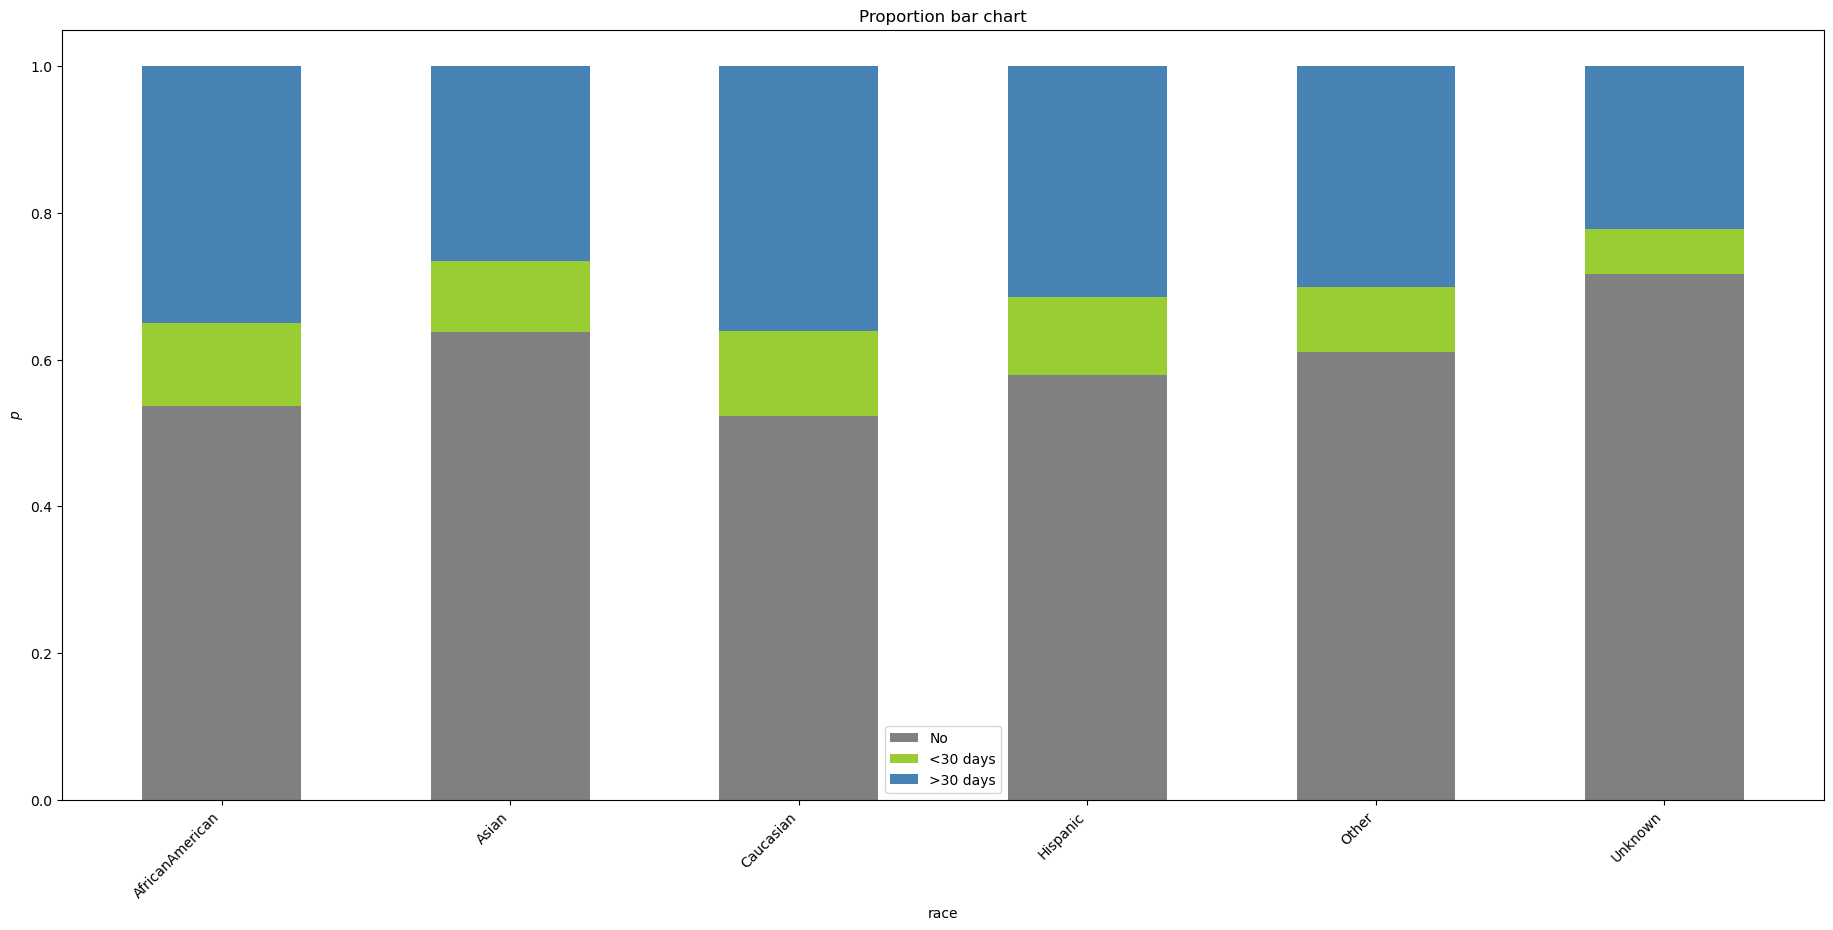

In [20]:
bar_charts_categorical(train, "race", "readmitted_multiclass")

In [21]:
train['race_caucasian'] = train['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

In [22]:
train['race_caucasian'].value_counts()

race_caucasian
1    51779
0    19457
Name: count, dtype: int64

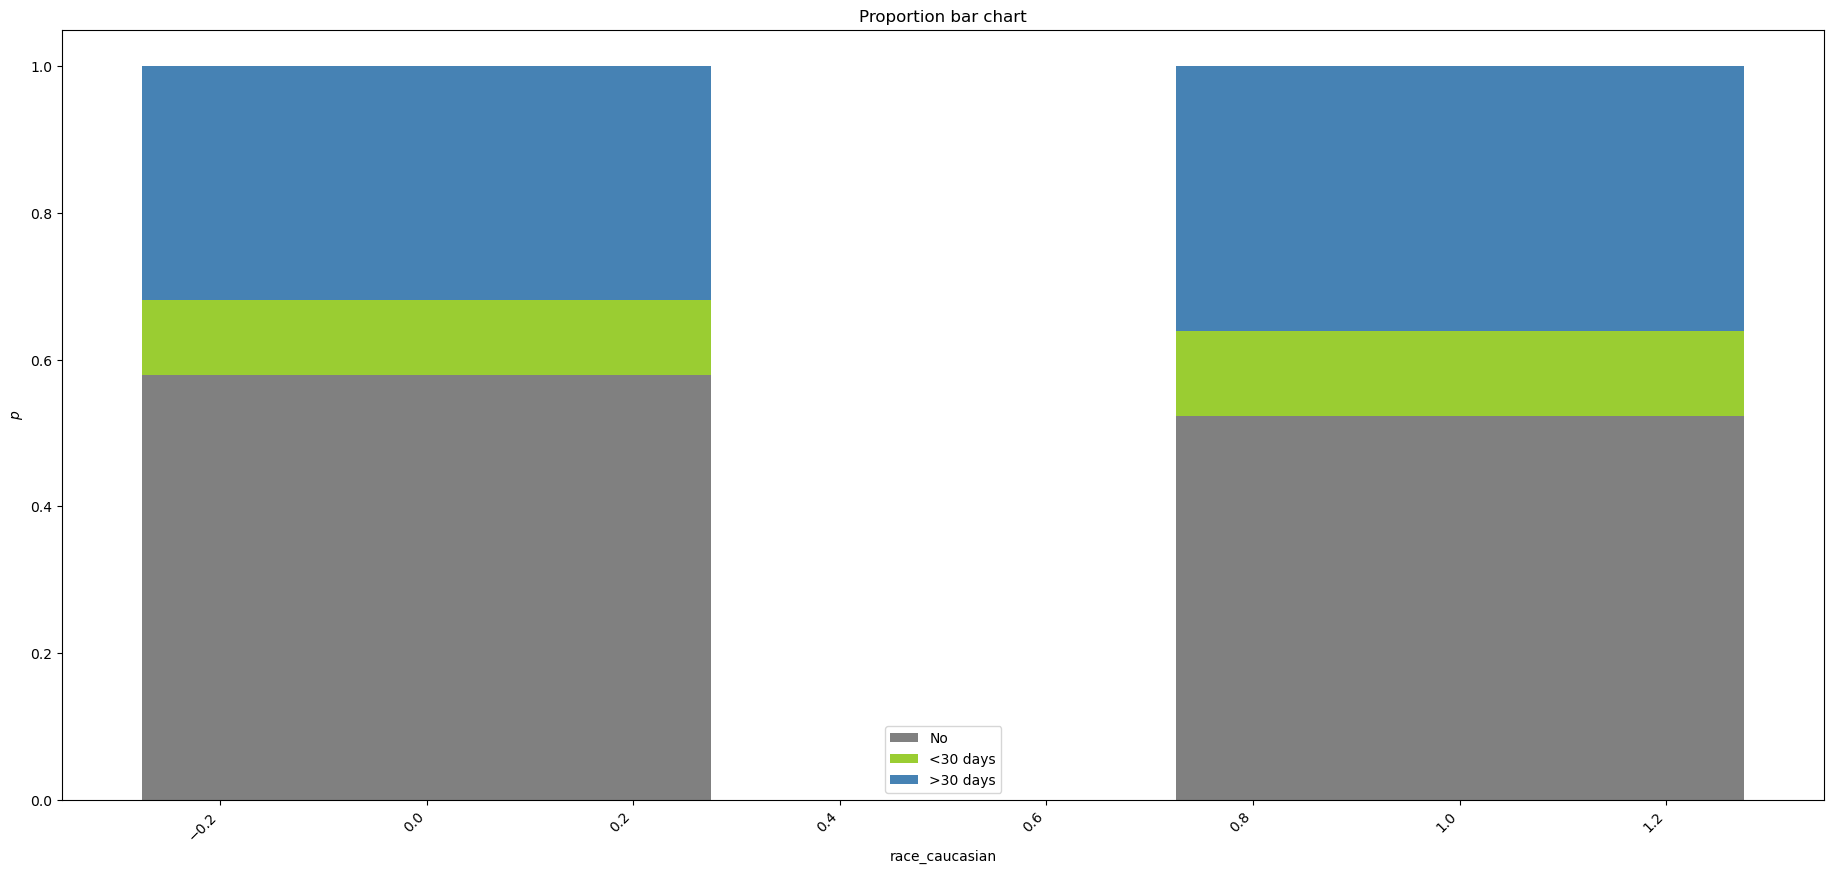

In [23]:
bar_charts_categorical(train, "race_caucasian", "readmitted_multiclass")

### medication 

In [24]:
train['medication'].value_counts(normalize=True)

medication
['insulin']                                                       0.304832
[]                                                                0.229463
['metformin']                                                     0.044247
['metformin', 'insulin']                                          0.042689
['glipizide']                                                     0.038281
                                                                    ...   
['pioglitazone', 'acarbose', 'insulin', 'glyburide-metformin']    0.000014
['glimepiride', 'rosiglitazone', 'acarbose']                      0.000014
['glipizide', 'pioglitazone', 'acarbose', 'insulin']              0.000014
['metformin', 'glyburide', 'acarbose', 'insulin']                 0.000014
['glimepiride', 'rosiglitazone', 'miglitol', 'insulin']           0.000014
Name: proportion, Length: 303, dtype: float64

In [25]:
# Replace empty brackets with 'no_medication'
train['medication'] = train['medication'].str.replace('[]', 'no_medication')
train['number_generic_medications'] = train['medication'].apply(lambda x: 0 if x=='no_medication' else len((x.replace("[", "").replace("]", "")).split(',')))

In [26]:
train['number_generic_medications'].value_counts()

number_generic_medications
1    33182
0    16346
2    15289
3     5446
4      929
5       41
6        3
Name: count, dtype: int64

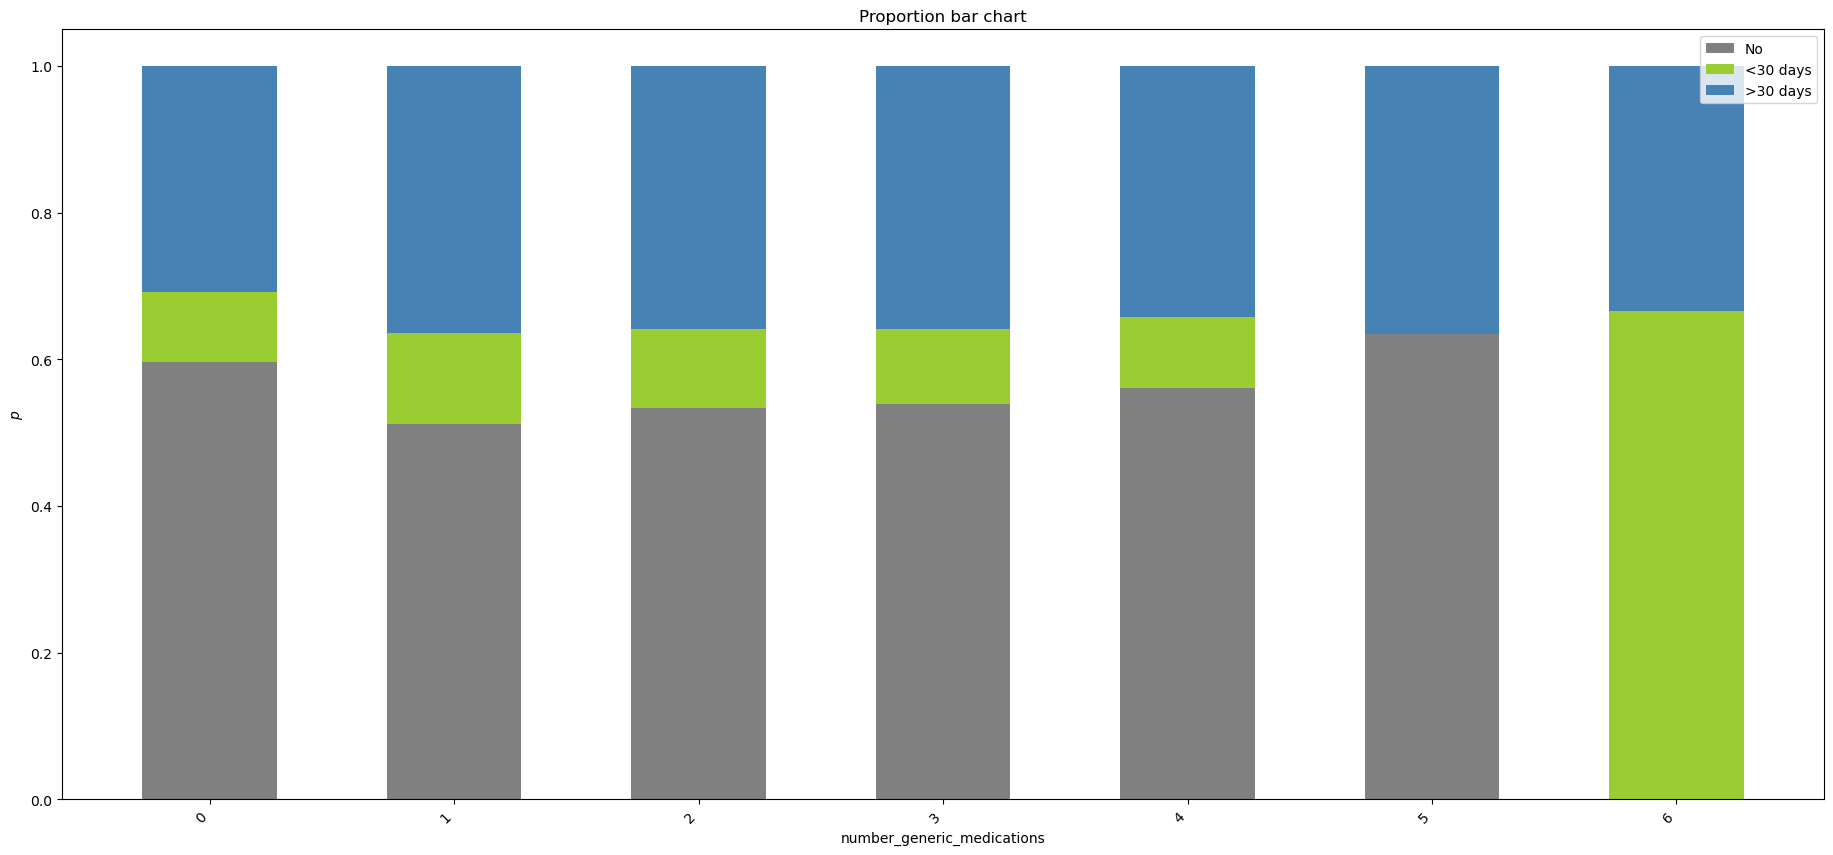

In [27]:
bar_charts_categorical(train, "number_generic_medications", "readmitted_multiclass")

In [28]:
# Split medications based on commas
train['medication'] = train['medication'].apply(lambda x: [i.strip().strip('\'"') for i in x.strip('[]').split(',')])

# Get unique medications
medications = set(x for sublist in train['medication'] for x in sublist)

# Create new columns for each medication
for med in medications:
    train[med] = train['medication'].apply(lambda x: 1 if med in x else 0)

In [29]:
train.drop('medication', axis=1, inplace=True)

In [30]:
train['Sulfonylureas'] = train['glipizide']+train['glyburide']+train['tolbutamide']+train['acetohexamide']+train['chlorpropamide']
+train['glimepiride']+train['tolazamide']
train['Meglitinides'] = train['repaglinide'] + train['nateglinide']
train['Thiazolidinediones'] = train['pioglitazone'] + train['rosiglitazone'] + train['troglitazone']
train['Alpha_Glucosidase_Inhibitors'] = train['acarbose'] + train['miglitol']
train['Combination_Medications'] = train['glimepiride-pioglitazone']+train['glyburide-metformin']+train['metformin-pioglitazone']
+train['glipizide-metformin']+train['metformin-rosiglitazone']

encounter_id
533253    0
426224    0
634063    0
890610    0
654194    0
         ..
660160    0
826429    0
332030    0
757560    0
459757    0
Length: 71236, dtype: int64

In [31]:
train.drop(['tolazamide', 'miglitol', 'repaglinide', 'nateglinide',
            'glimepiride-pioglitazone', 'glipizide', 'pioglitazone',
            'glyburide', 'acetohexamide', 'tolbutamide','acarbose',
            'glyburide-metformin', 'metformin-pioglitazone', 'glipizide-metformin',
            'metformin-rosiglitazone', 'chlorpropamide', 'rosiglitazone',
            'troglitazone', 'glimepiride'], axis=1, inplace=True)

In [32]:
medication_columns = ['Sulfonylureas','Meglitinides','Thiazolidinediones','Alpha_Glucosidase_Inhibitors',
                      'Combination_Medications','insulin','metformin','no_medication']
for col in medication_columns:
    print(train[col].value_counts(), '\n')

Sulfonylureas
0    54890
1    16194
2      152
Name: count, dtype: int64 

Meglitinides
0    69686
1     1544
2        6
Name: count, dtype: int64 

Thiazolidinediones
0    61699
1     9507
2       30
Name: count, dtype: int64 

Alpha_Glucosidase_Inhibitors
0    71003
1      233
Name: count, dtype: int64 

Combination_Medications
0    70737
1      499
Name: count, dtype: int64 

insulin
1    38105
0    33131
Name: count, dtype: int64 

metformin
0    57271
1    13965
Name: count, dtype: int64 

no_medication
0    54890
1    16346
Name: count, dtype: int64 



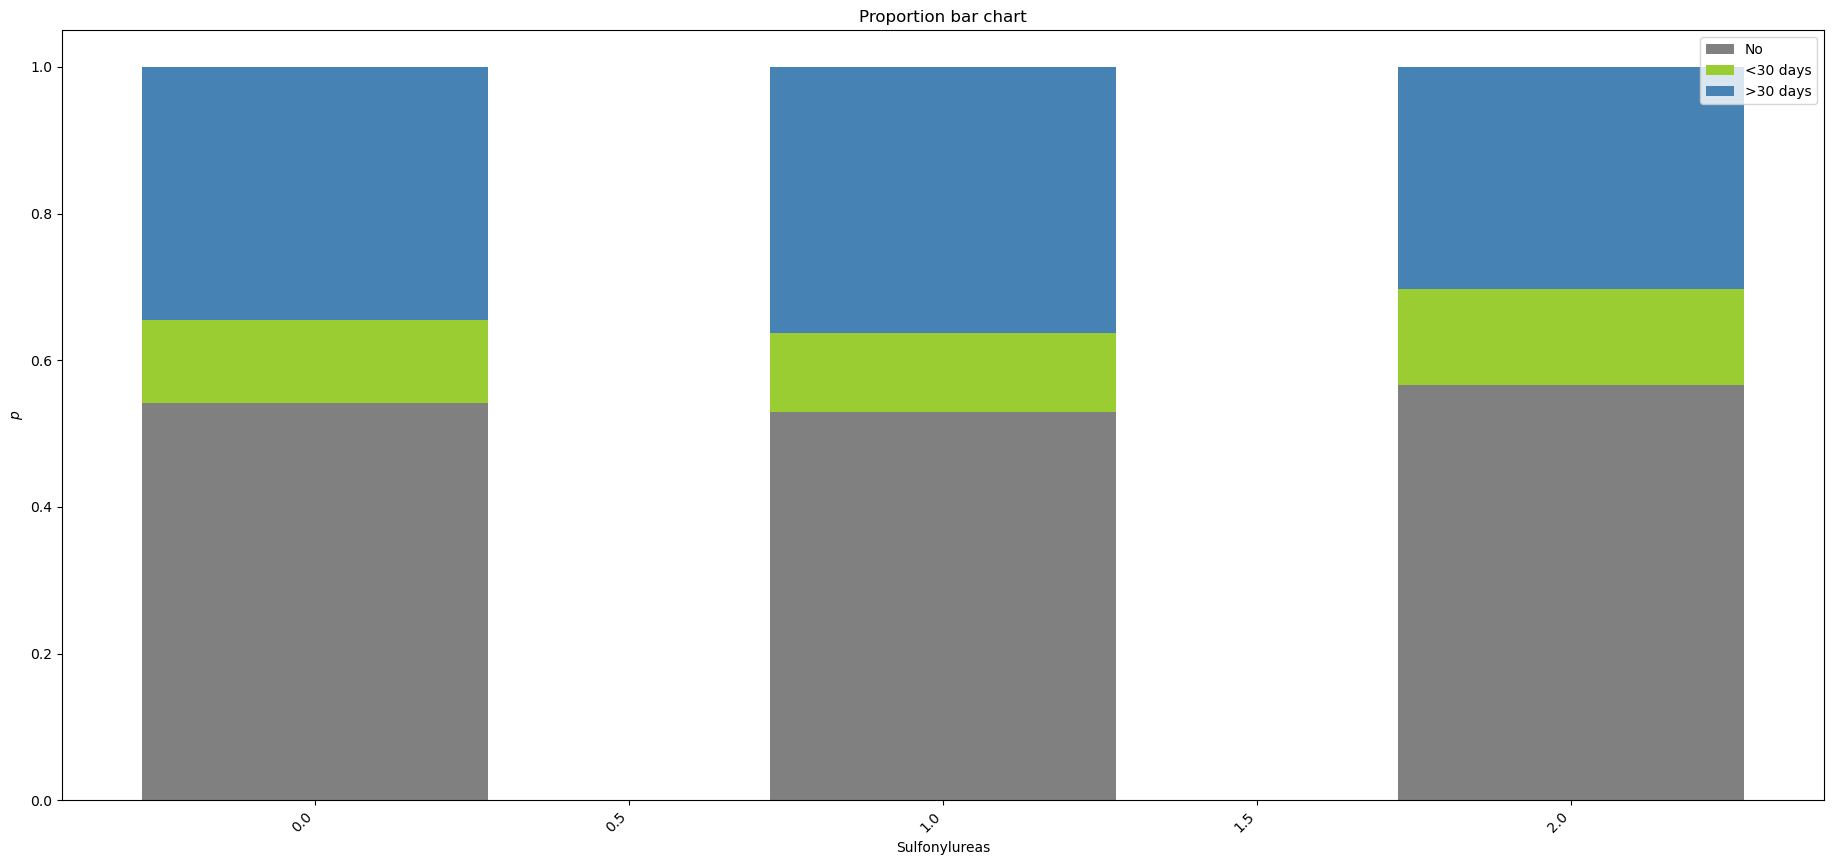

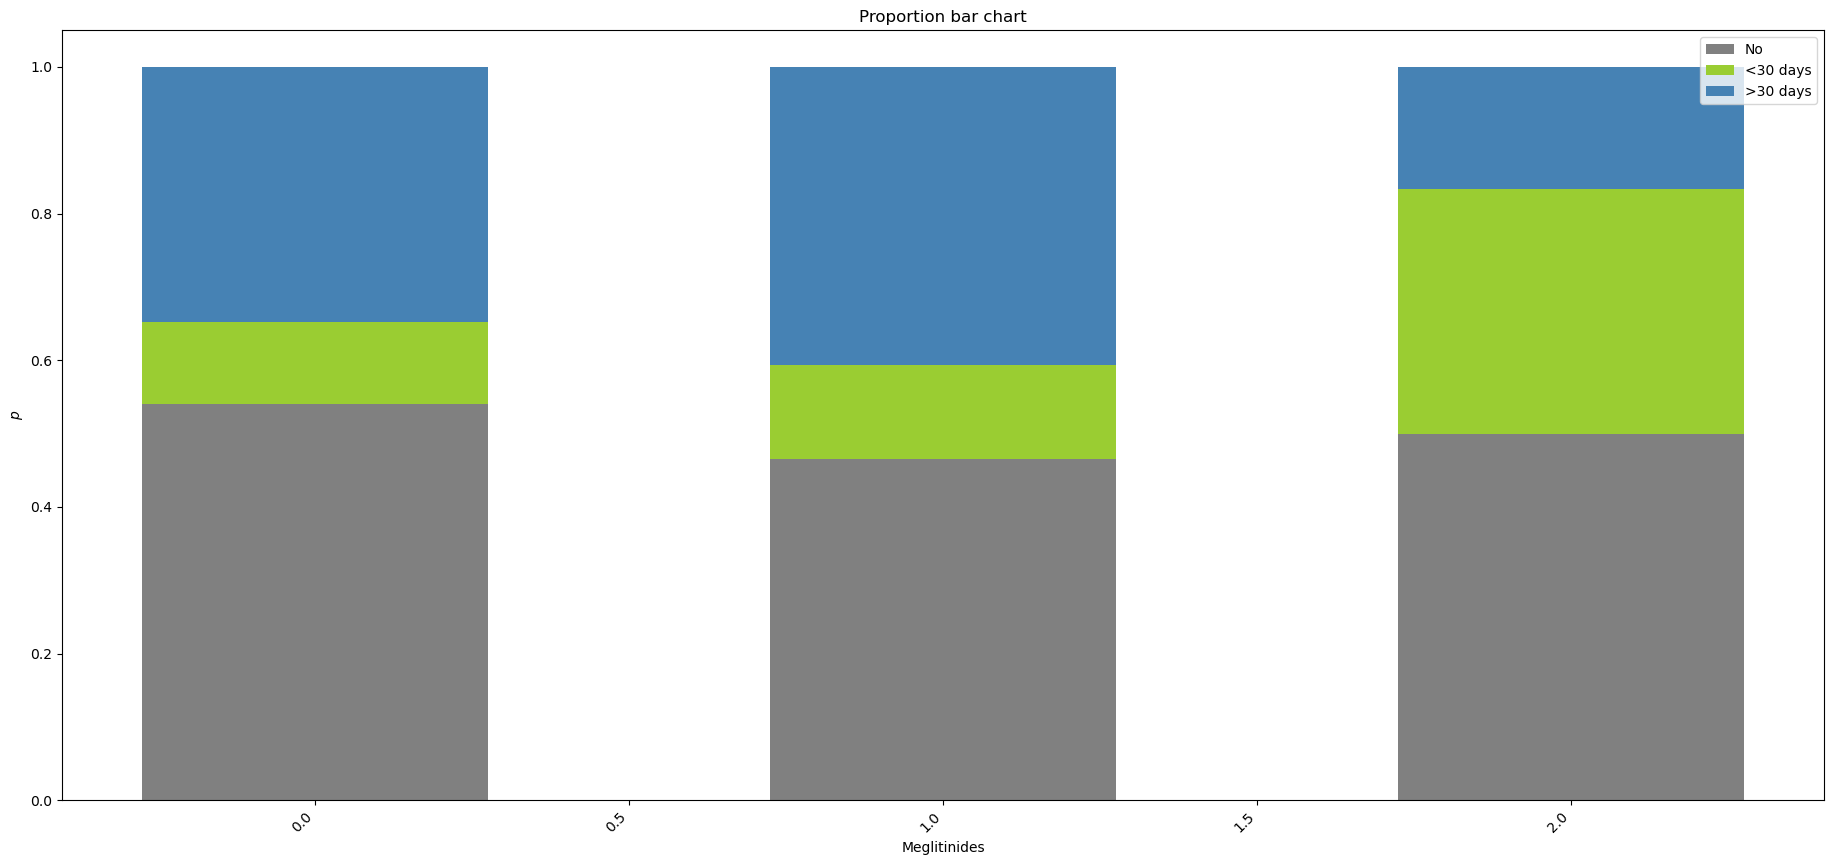

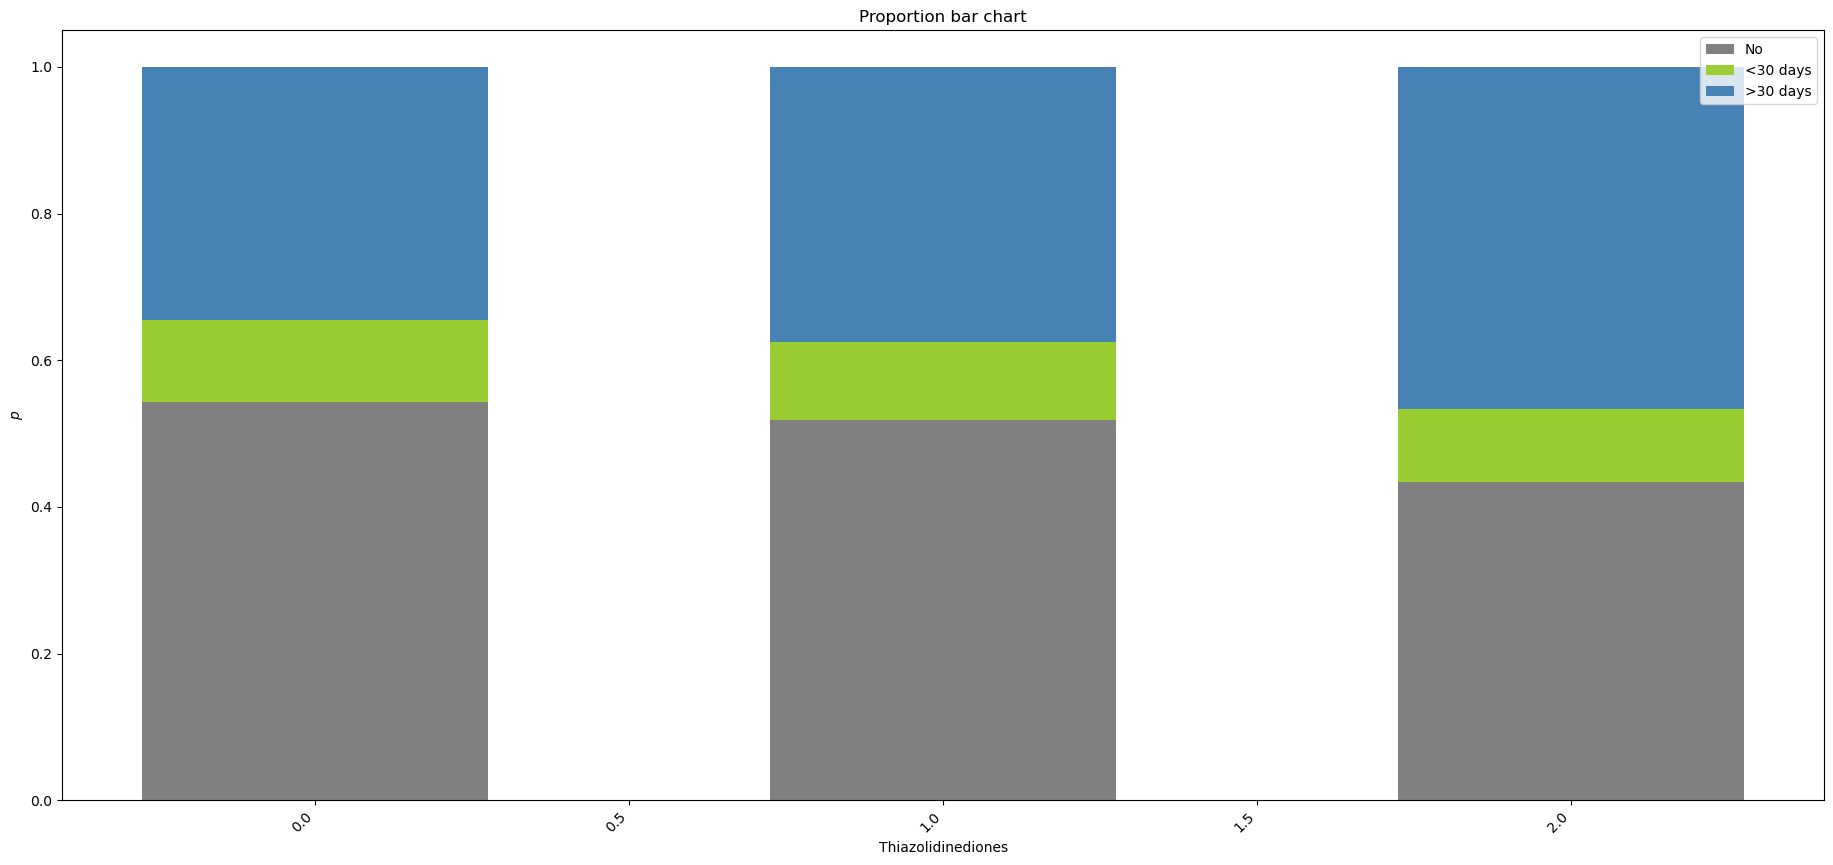

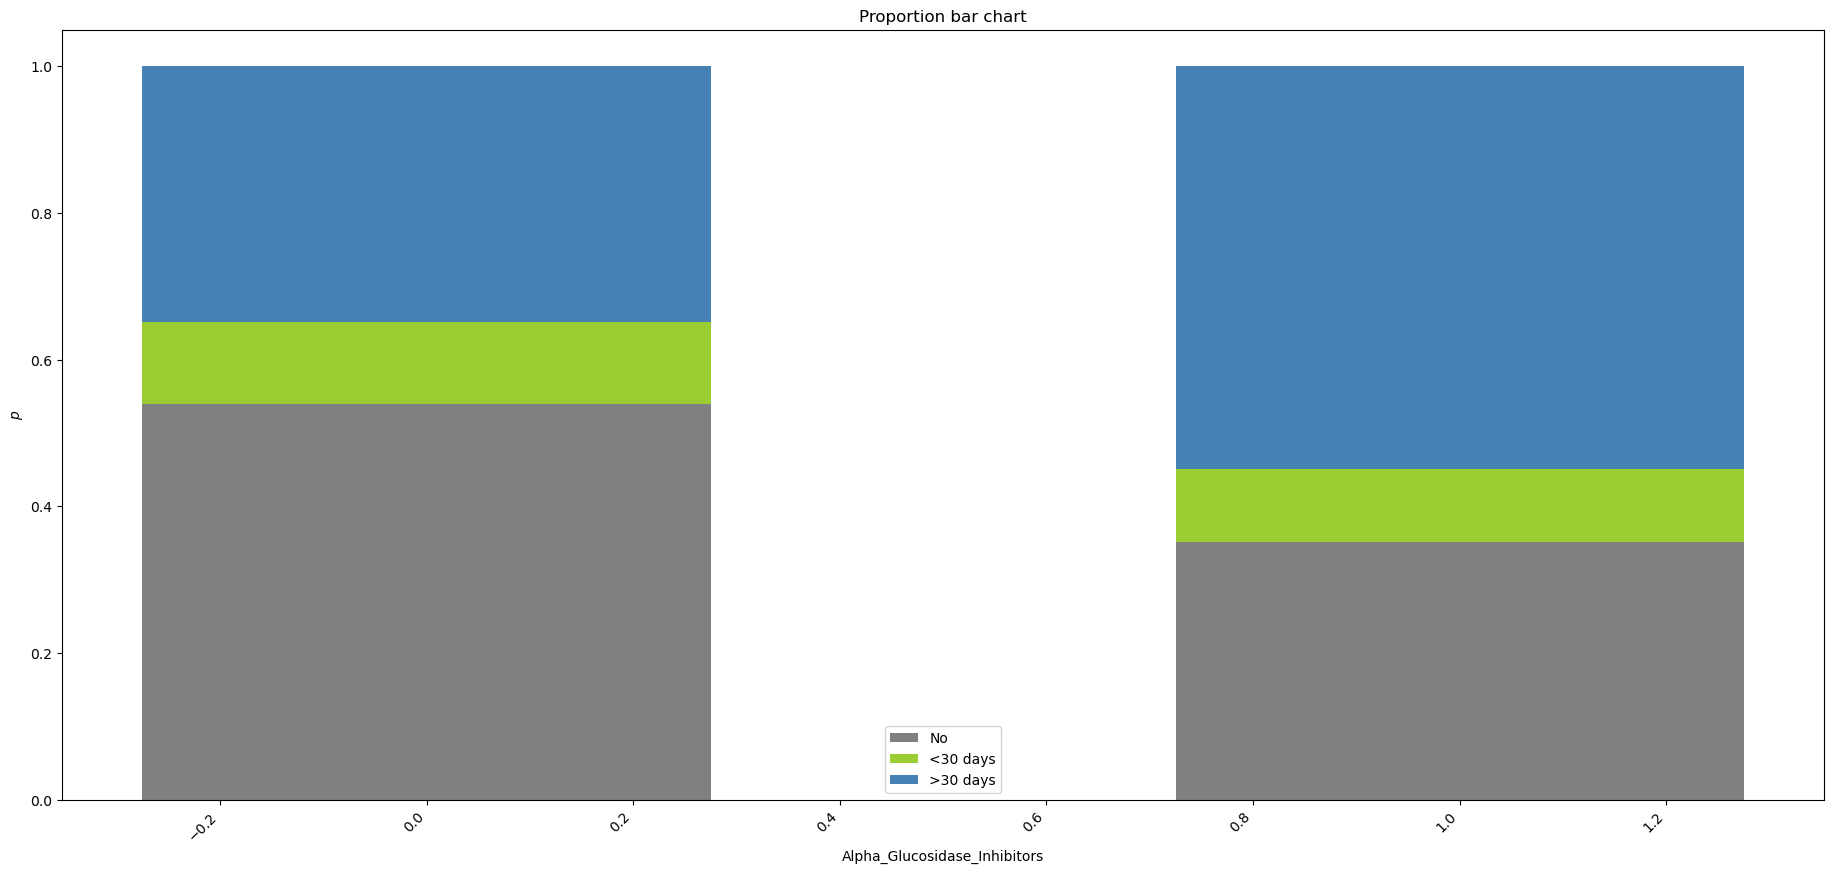

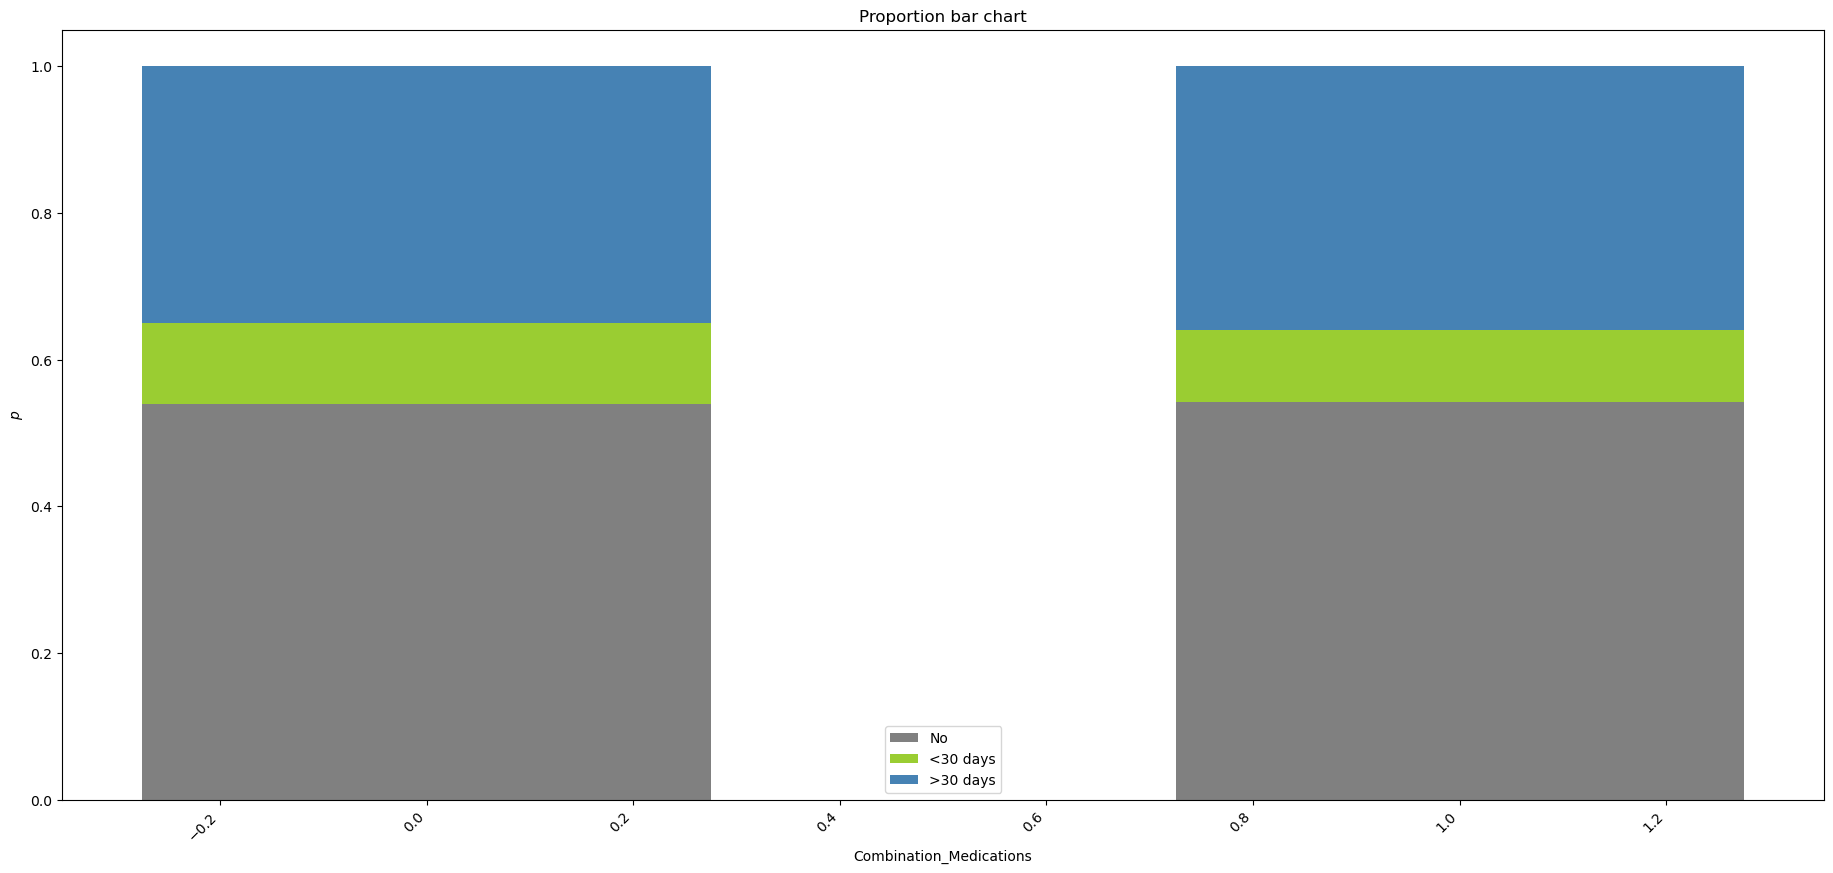

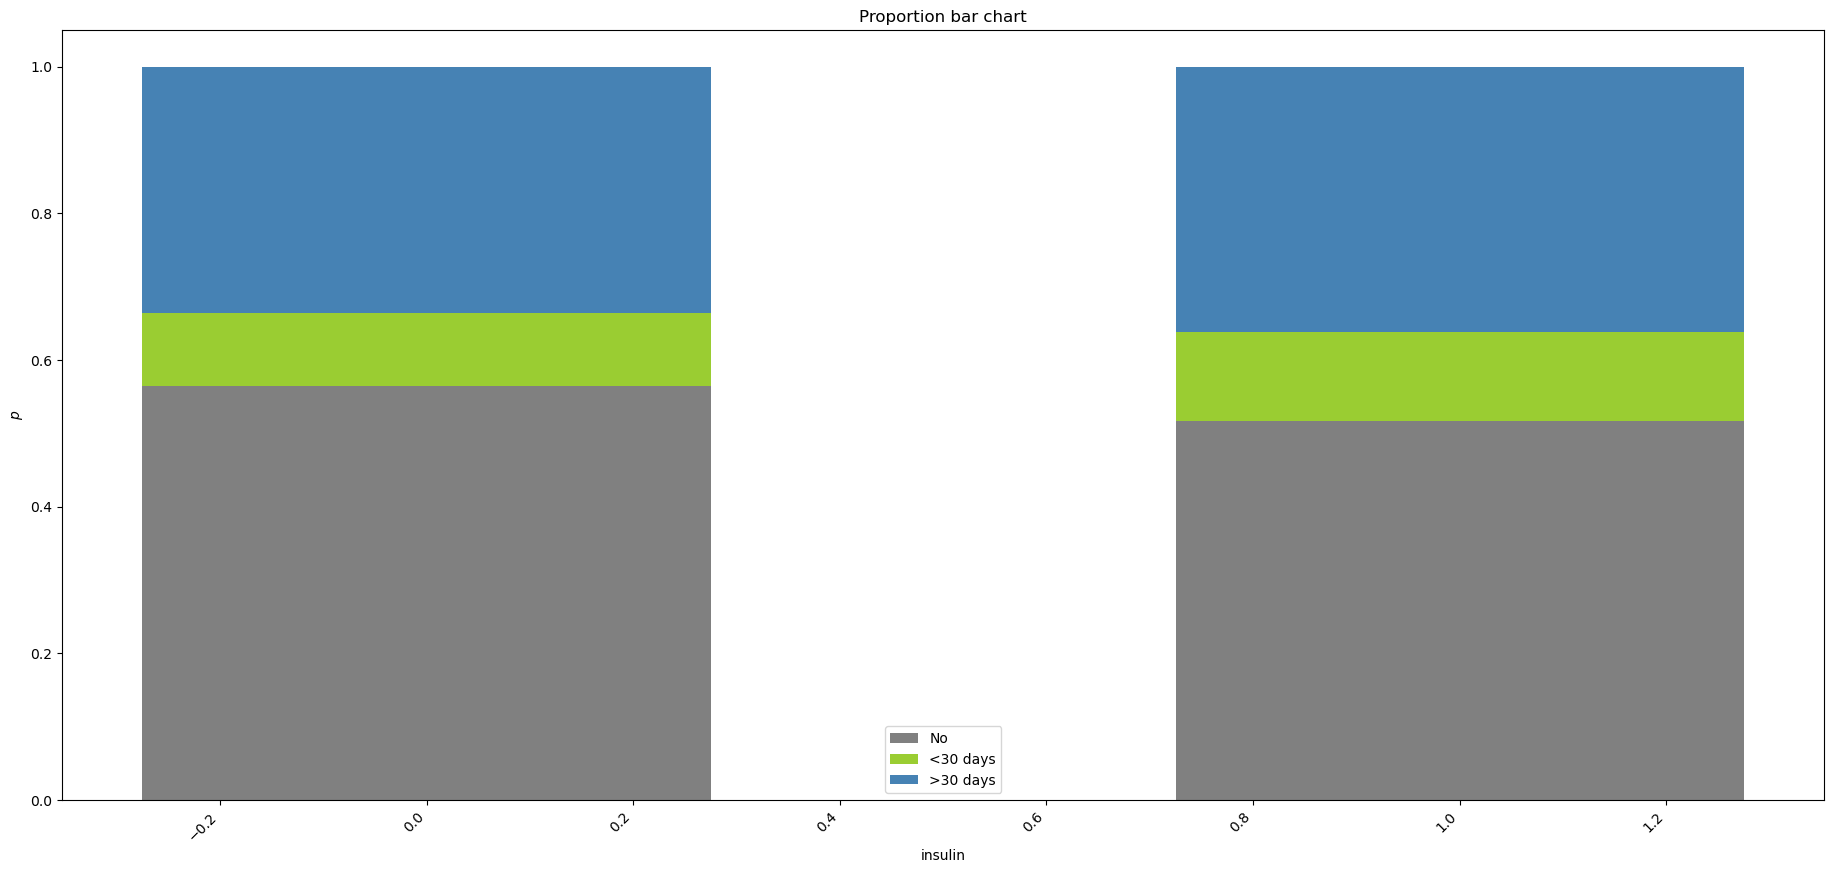

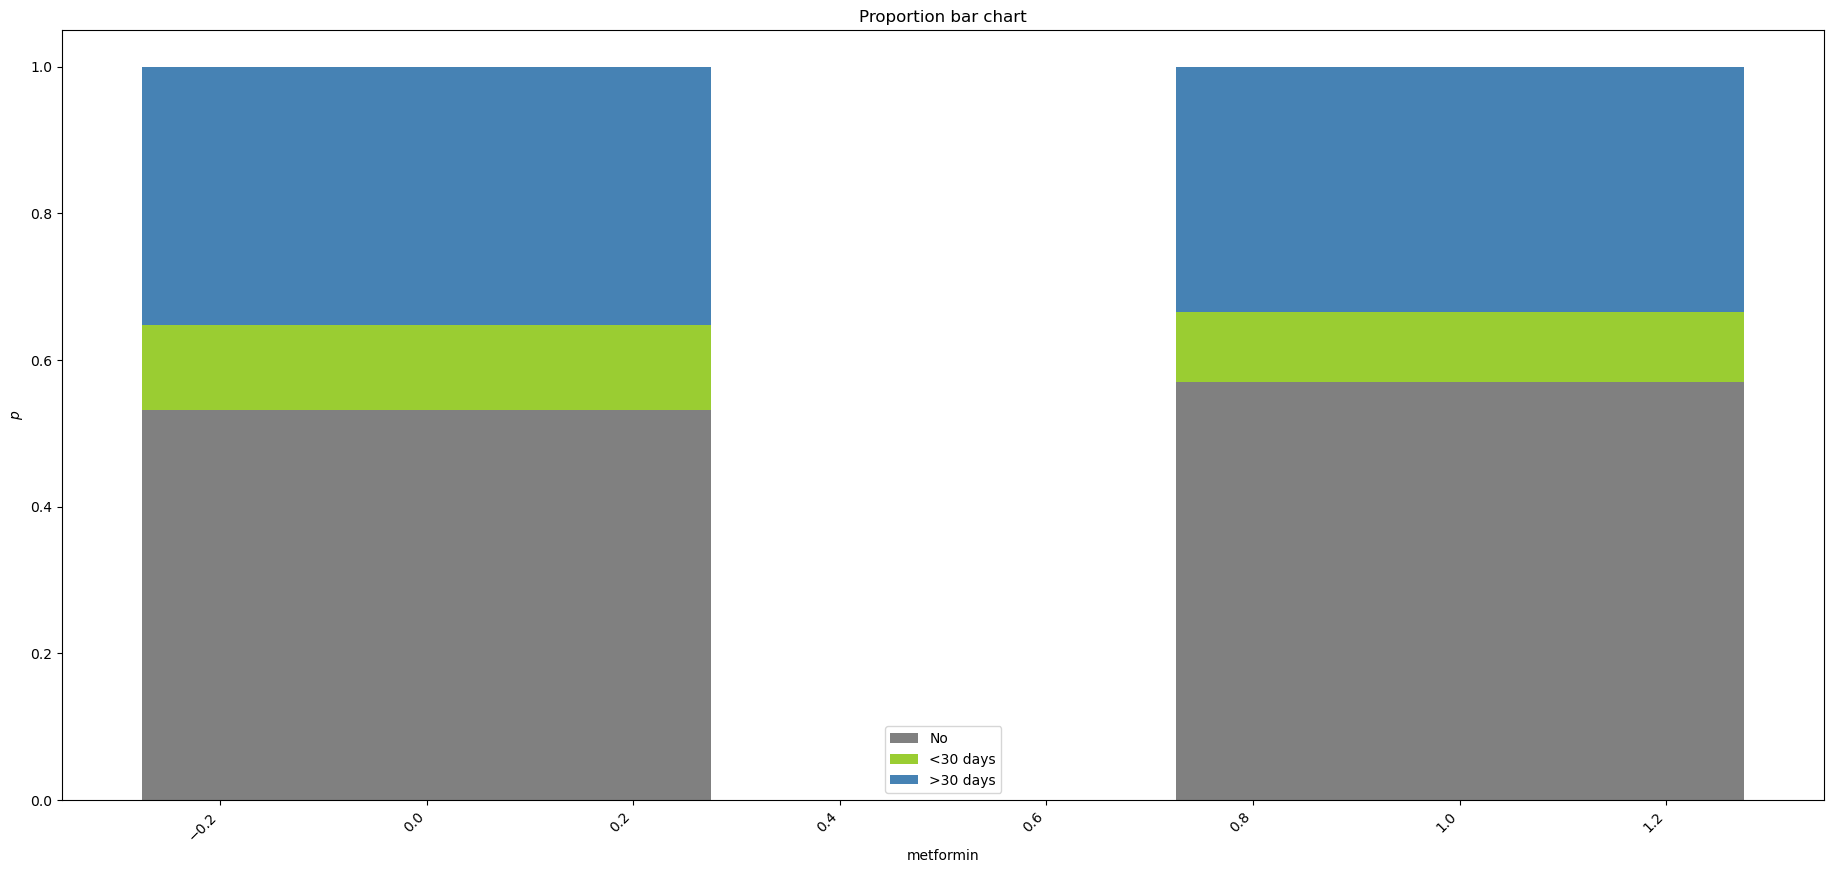

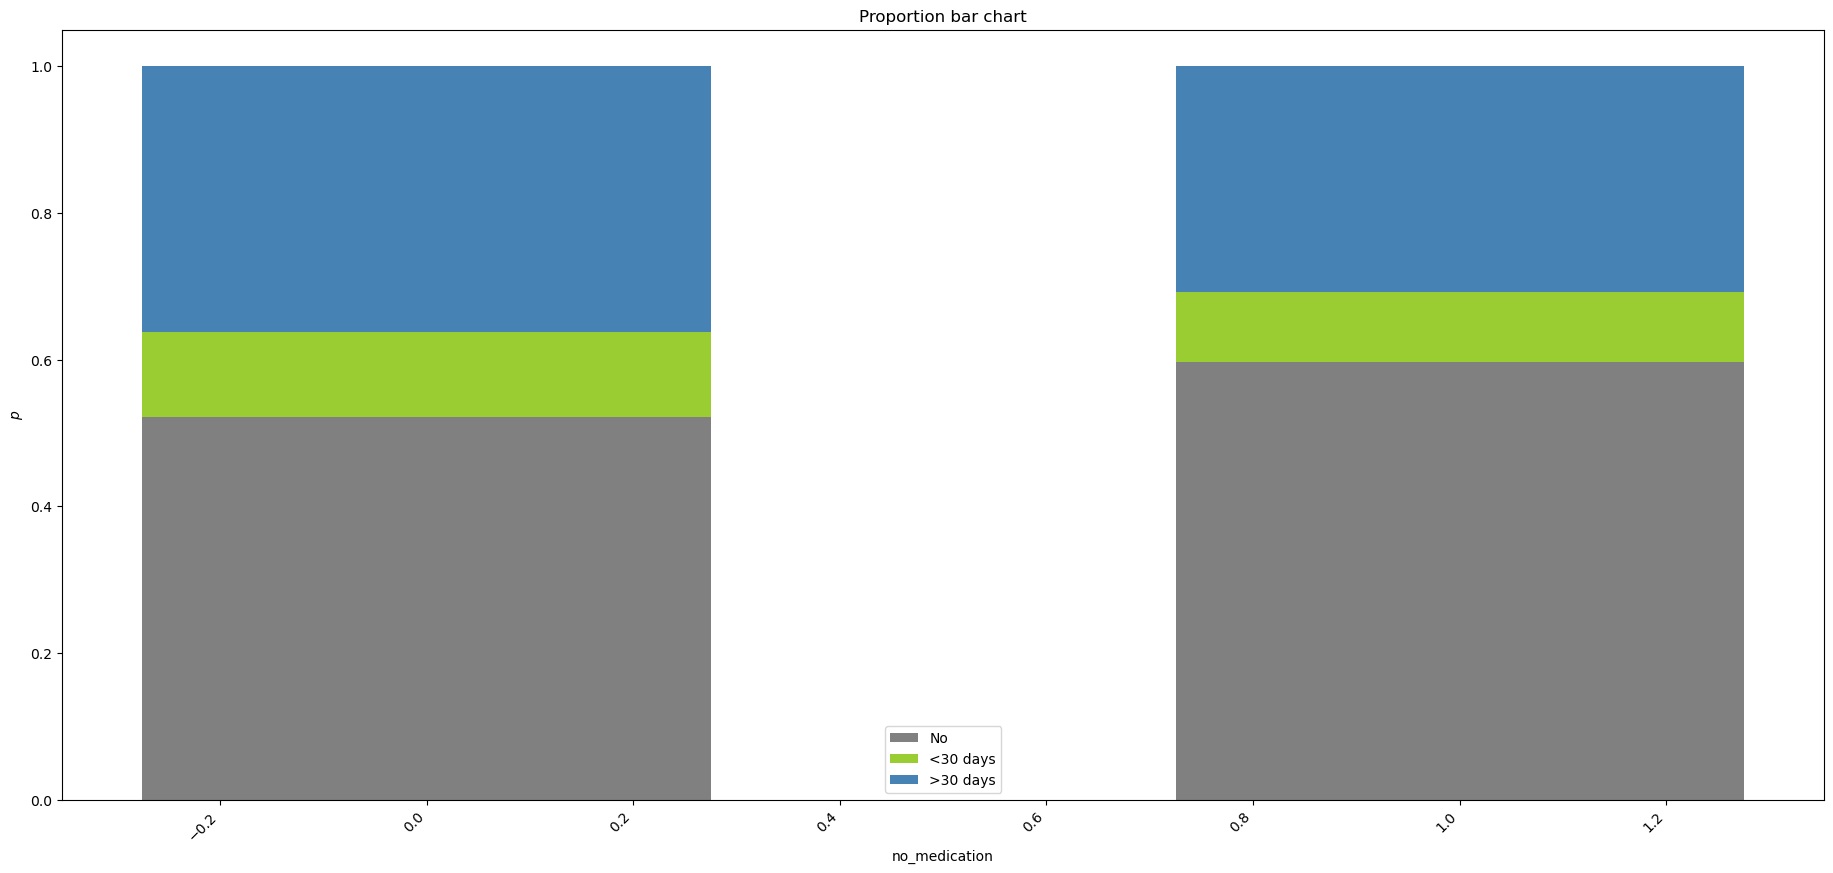

In [33]:
for col in medication_columns:
    bar_charts_categorical(train, col, "readmitted_multiclass")

In [34]:
# 'no_medication' is the exact oposite to 'prescribed_diabetes_meds'
train.drop('no_medication', axis=1, inplace=True)

### age

In [35]:
train['age'].value_counts(normalize=True)

age
[70-80)     0.243683
[60-70)     0.209276
[80-90)     0.161576
[50-60)     0.160354
[40-50)     0.090095
Unknown     0.049933
[30-40)     0.035600
[90-100)    0.026321
[20-30)     0.015035
[10-20)     0.006654
[0-10)      0.001474
Name: proportion, dtype: float64

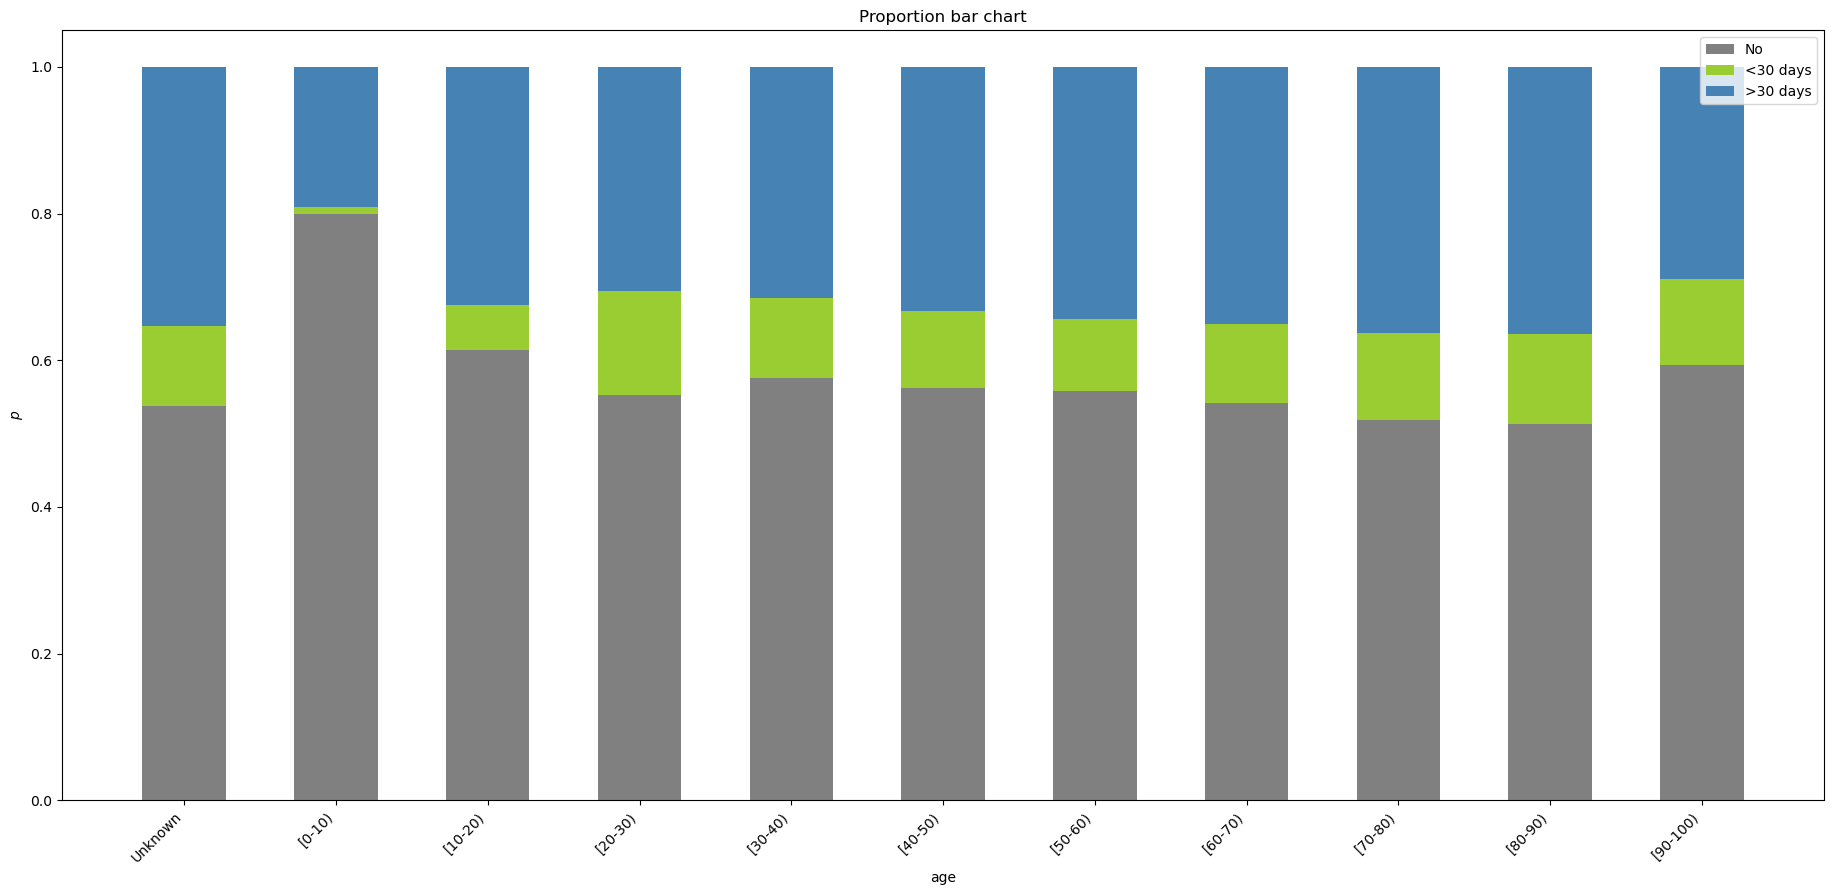

In [36]:
bar_charts_categorical(train, "age", "readmitted_multiclass")

In [37]:
data = train['age']
df = pd.DataFrame(data)

# Extract the lower and upper age values as separate columns
df[['Lower_Age', 'Upper_Age']] = df['age'].str.extract(r'\[(\d+)-(\d+)\)')

df['Lower_Age'] = pd.to_numeric(df['Lower_Age'], errors='coerce', downcast='integer')
df['Upper_Age'] = pd.to_numeric(df['Upper_Age'], errors='coerce', downcast='integer')


df['Midpoint_Age'] = average_age = np.where(df['Lower_Age'].notna() & df['Upper_Age'].notna(),
                       (df['Lower_Age'] + df['Upper_Age']) / 2,
                       np.nan)
train['Midpoint_Age'] = df['Midpoint_Age']
train.drop('age', axis=1, inplace=True)

In [38]:
train['Midpoint_Age'].fillna('Unknown', inplace=True)
train[train['Midpoint_Age']=='Unknown'].shape[0]

3557

In [39]:
# Age Imputation by Patient
def fill_age(df):
    for i, row in df.iterrows():
        if row['Midpoint_Age'] == 'Unknown':
            # Check if there are any other rows with the same 'person_id' and 'race' not equal to 'Unknown'
            other_rows = df[(df['patient_id'] == row['patient_id']) & (df['Midpoint_Age'] != 'Unknown')]
            if not other_rows.empty:
                # If such a row is found, replace the 'race' of the current row with the 'race' of the found row
                df.at[i, 'Midpoint_Age'] = other_rows.iloc[0]['Midpoint_Age']

In [40]:
fill_age(train)
train[train['Midpoint_Age']=='Unknown'].shape[0]

2217

In [41]:
train['Midpoint_Age'].unique()

array([75.0, 55.0, 65.0, 85.0, 45.0, 'Unknown', 25.0, 35.0, 95.0, 15.0,
       5.0], dtype=object)

### gender

In [42]:
train['gender'].value_counts()

gender
Female             38228
Male               33005
Unknown/Invalid        3
Name: count, dtype: int64

In [43]:
#Female = 0 Male = 1 and the Unknown/Invalid becomes Female because it is the mode in the train
train['gender_binary'] = np.where(train['gender']== 'Male',1,0)
train.drop('gender', axis=1, inplace=True)

In [44]:
train['gender_binary'].value_counts()

gender_binary
0    38231
1    33005
Name: count, dtype: int64

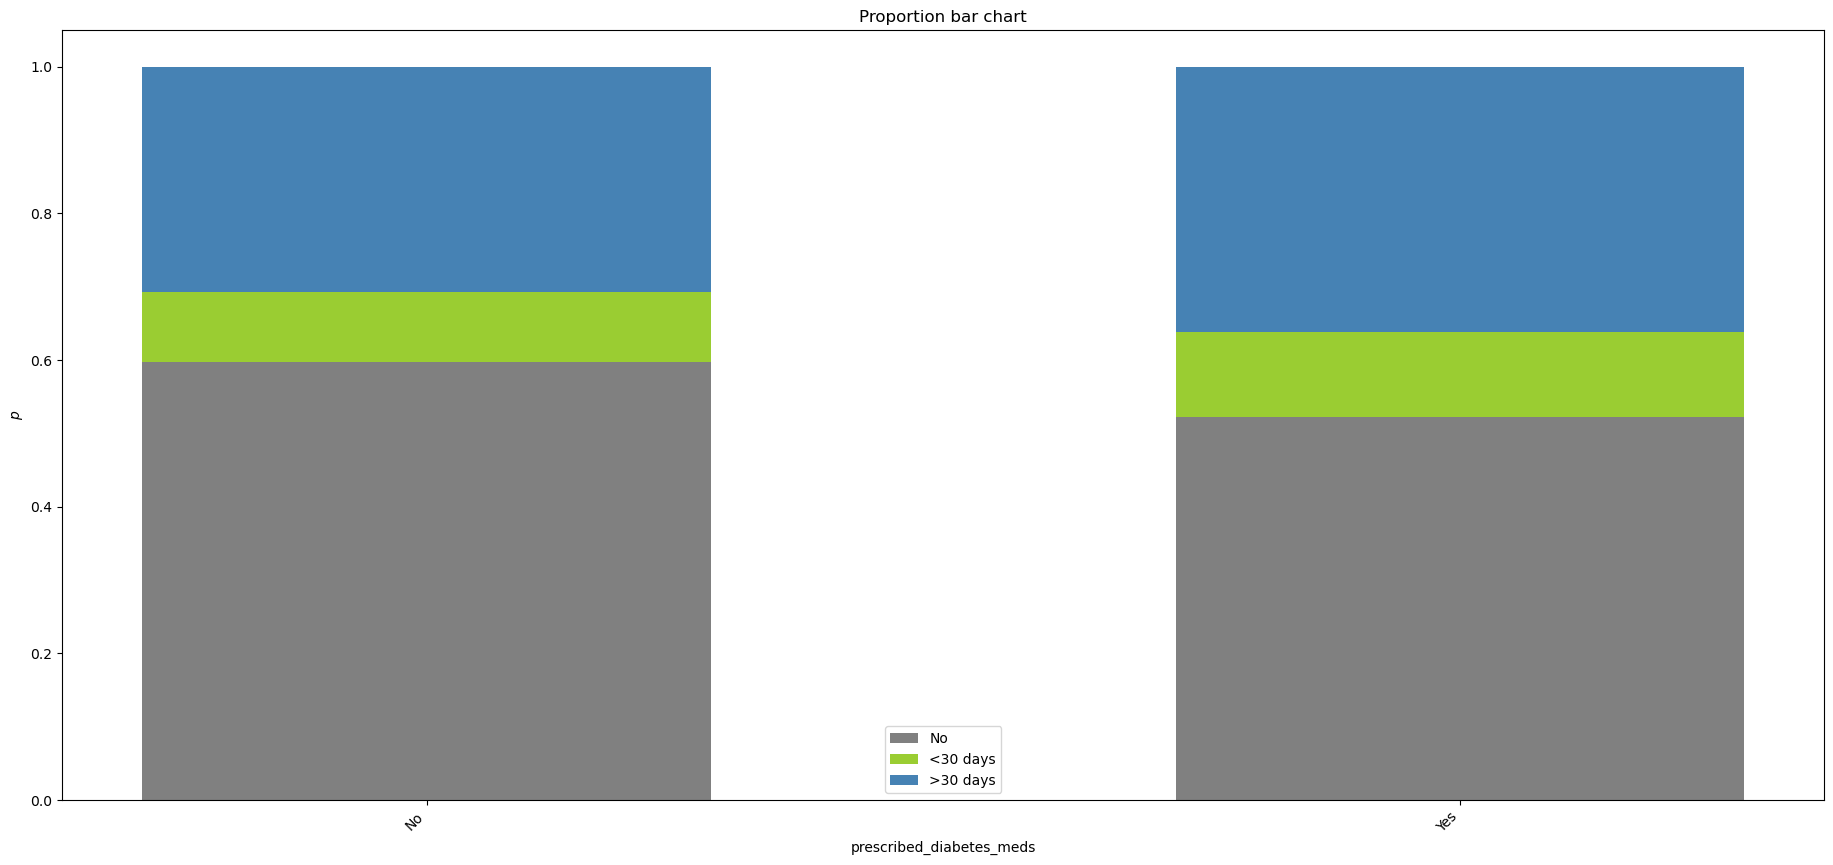

In [45]:
bar_charts_categorical(train, "prescribed_diabetes_meds", "readmitted_multiclass")

### prescribed_diabetes_meds

In [46]:
#No = 0 | Yes = 1
train['presc_diabetes_meds_binary'] = np.where(train['prescribed_diabetes_meds']== 'Yes',1,0)
train.drop('prescribed_diabetes_meds', axis=1, inplace=True)

In [47]:
train['presc_diabetes_meds_binary'].value_counts()

presc_diabetes_meds_binary
1    54890
0    16346
Name: count, dtype: int64

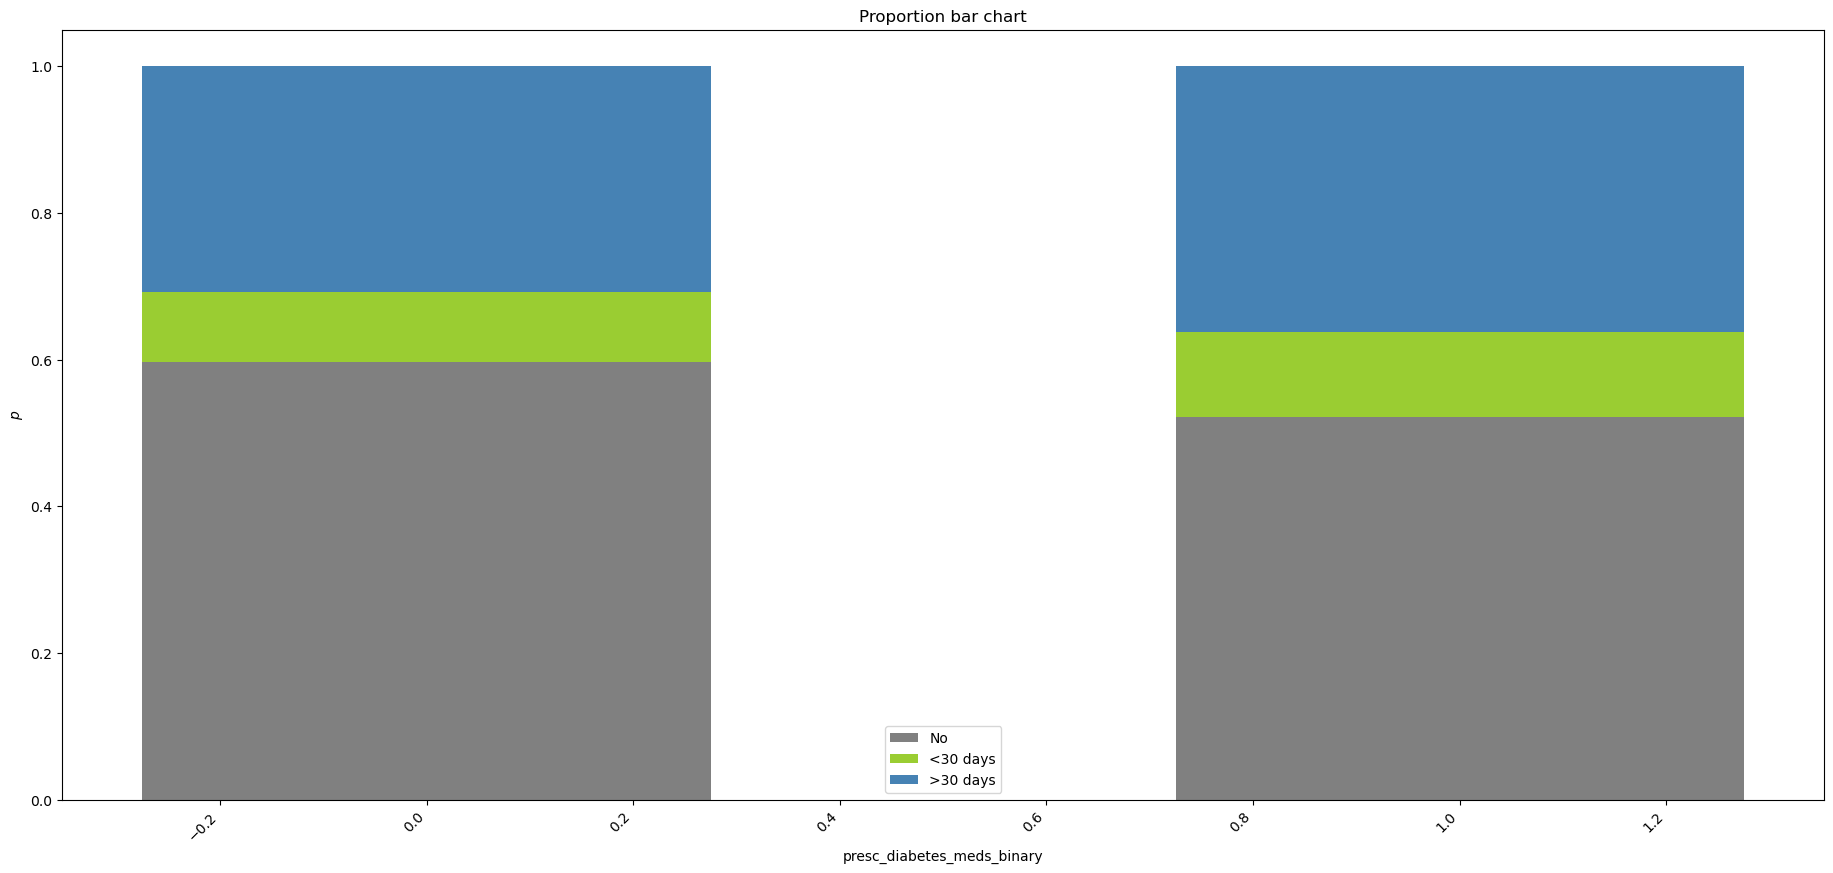

In [48]:
bar_charts_categorical(train, 'presc_diabetes_meds_binary', 'readmitted_multiclass')

### change_in_meds

In [49]:
#no change = 0 | change = 1
train['change_in_meds_binary'] = np.where(train['change_in_meds']== 'Ch',1,0)
train.drop('change_in_meds', axis=1, inplace=True)

In [50]:
train['change_in_meds_binary'].value_counts()

change_in_meds_binary
0    38326
1    32910
Name: count, dtype: int64

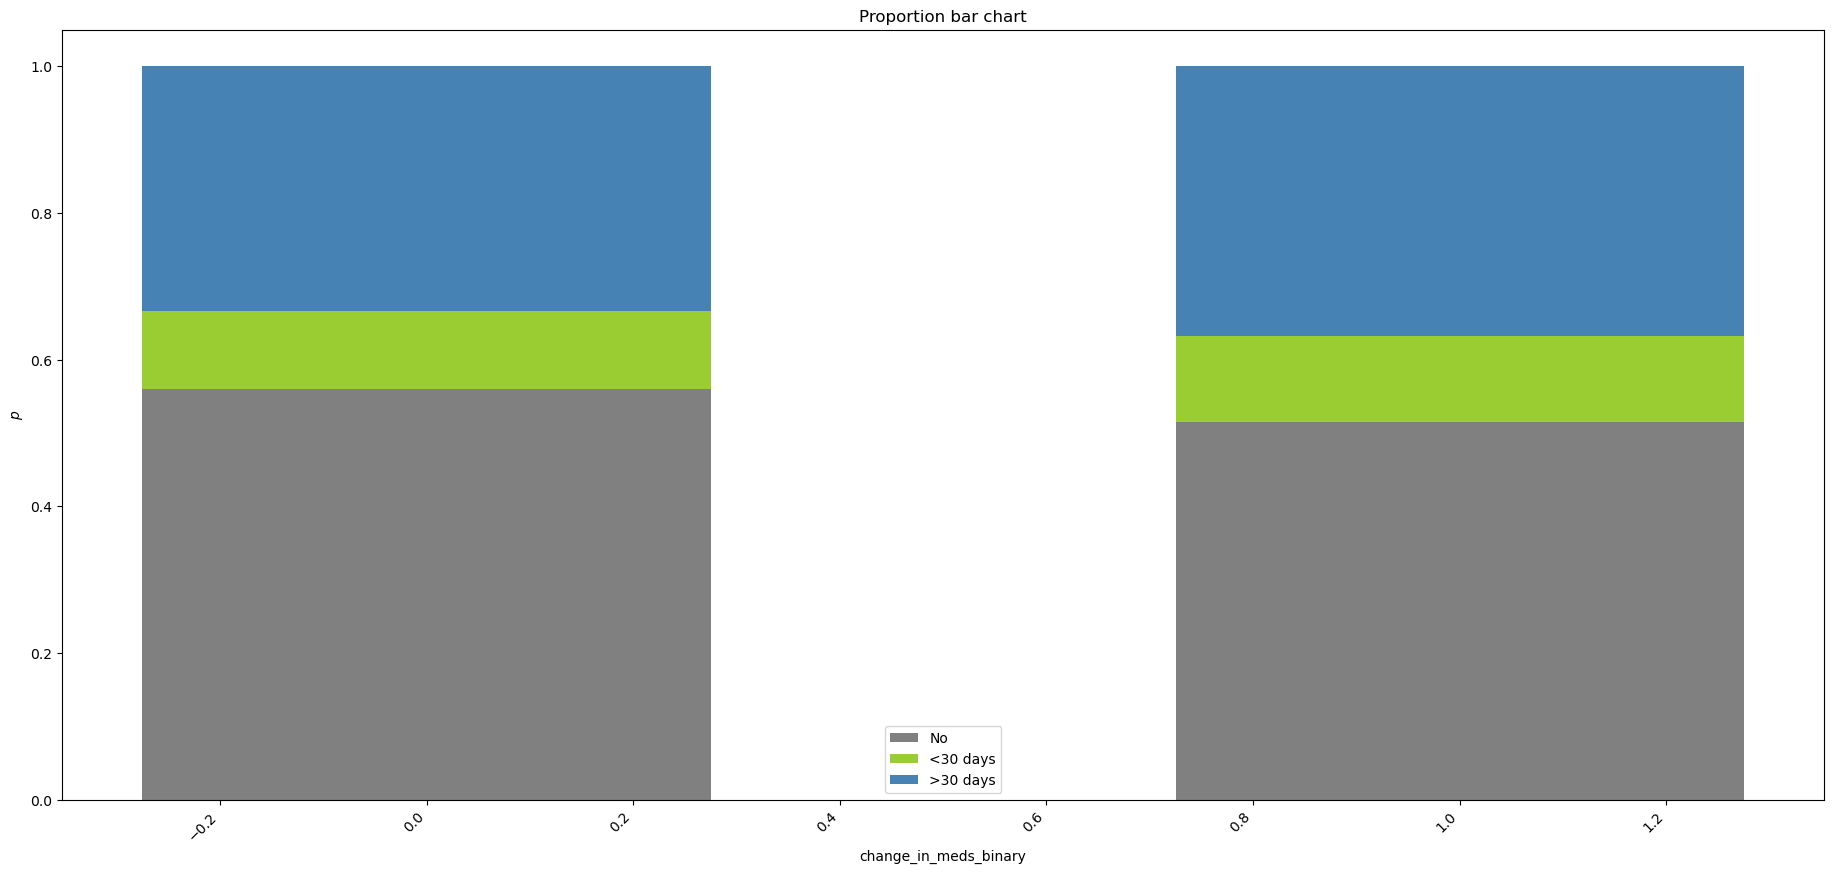

In [51]:
bar_charts_categorical(train, "change_in_meds_binary", "readmitted_multiclass")

### payer_code

In [52]:
train['payer_code'].value_counts()

payer_code
None    28201
MC      22683
HM       4319
SP       3541
BC       3292
MD       2484
CP       1762
UN       1733
CM       1347
OG        729
PO        405
DM        378
CH        102
WC         99
OT         61
MP         54
SI         45
FR          1
Name: count, dtype: int64

In [53]:
# Replacing the categories that have less than 1% of the number of rows
value_counts = train['payer_code'].value_counts(normalize=True)
replace_payer_code = value_counts[value_counts < 0.01].index
train['payer_code'] = train['payer_code'].replace(replace_payer_code, 'Other_code')

In [54]:
train['payer_code'].value_counts(normalize=True)

payer_code
None          0.395881
MC            0.318420
HM            0.060629
SP            0.049708
BC            0.046213
MD            0.034870
CP            0.024735
UN            0.024328
CM            0.018909
Other_code    0.016073
OG            0.010234
Name: proportion, dtype: float64

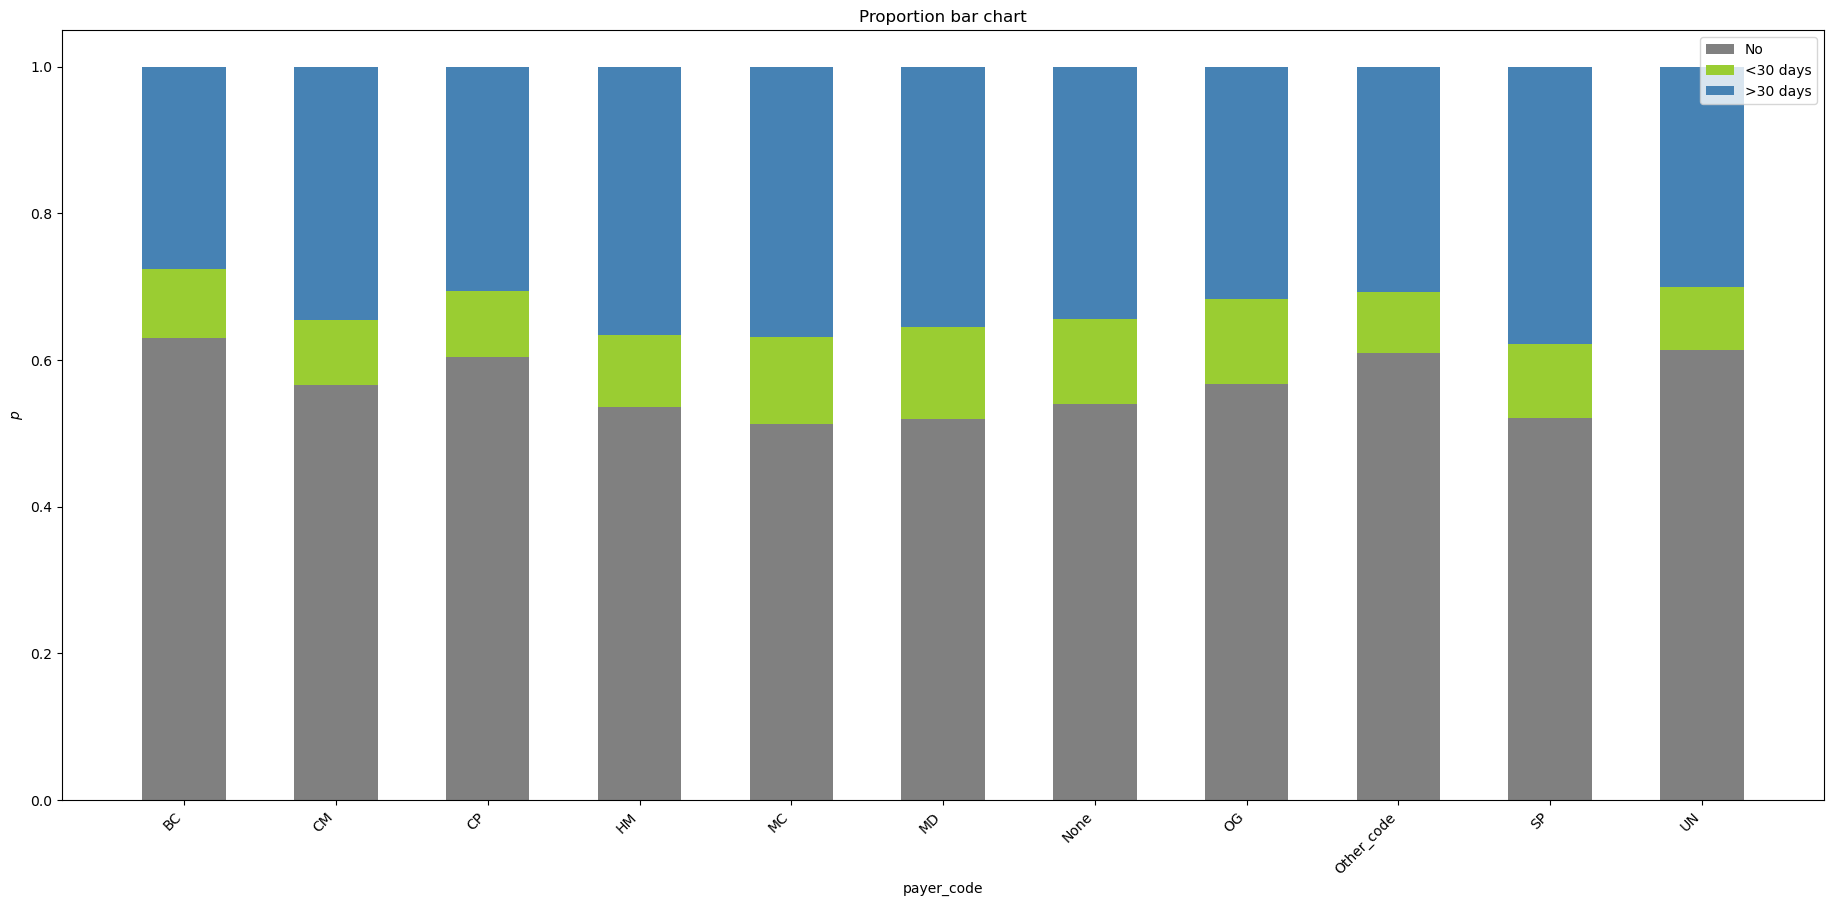

In [55]:
bar_charts_categorical(train, "payer_code", "readmitted_multiclass")

In [56]:
train['Has_Insurance'] = train['payer_code'].apply(lambda x: 0 if x == 'None' else 1)

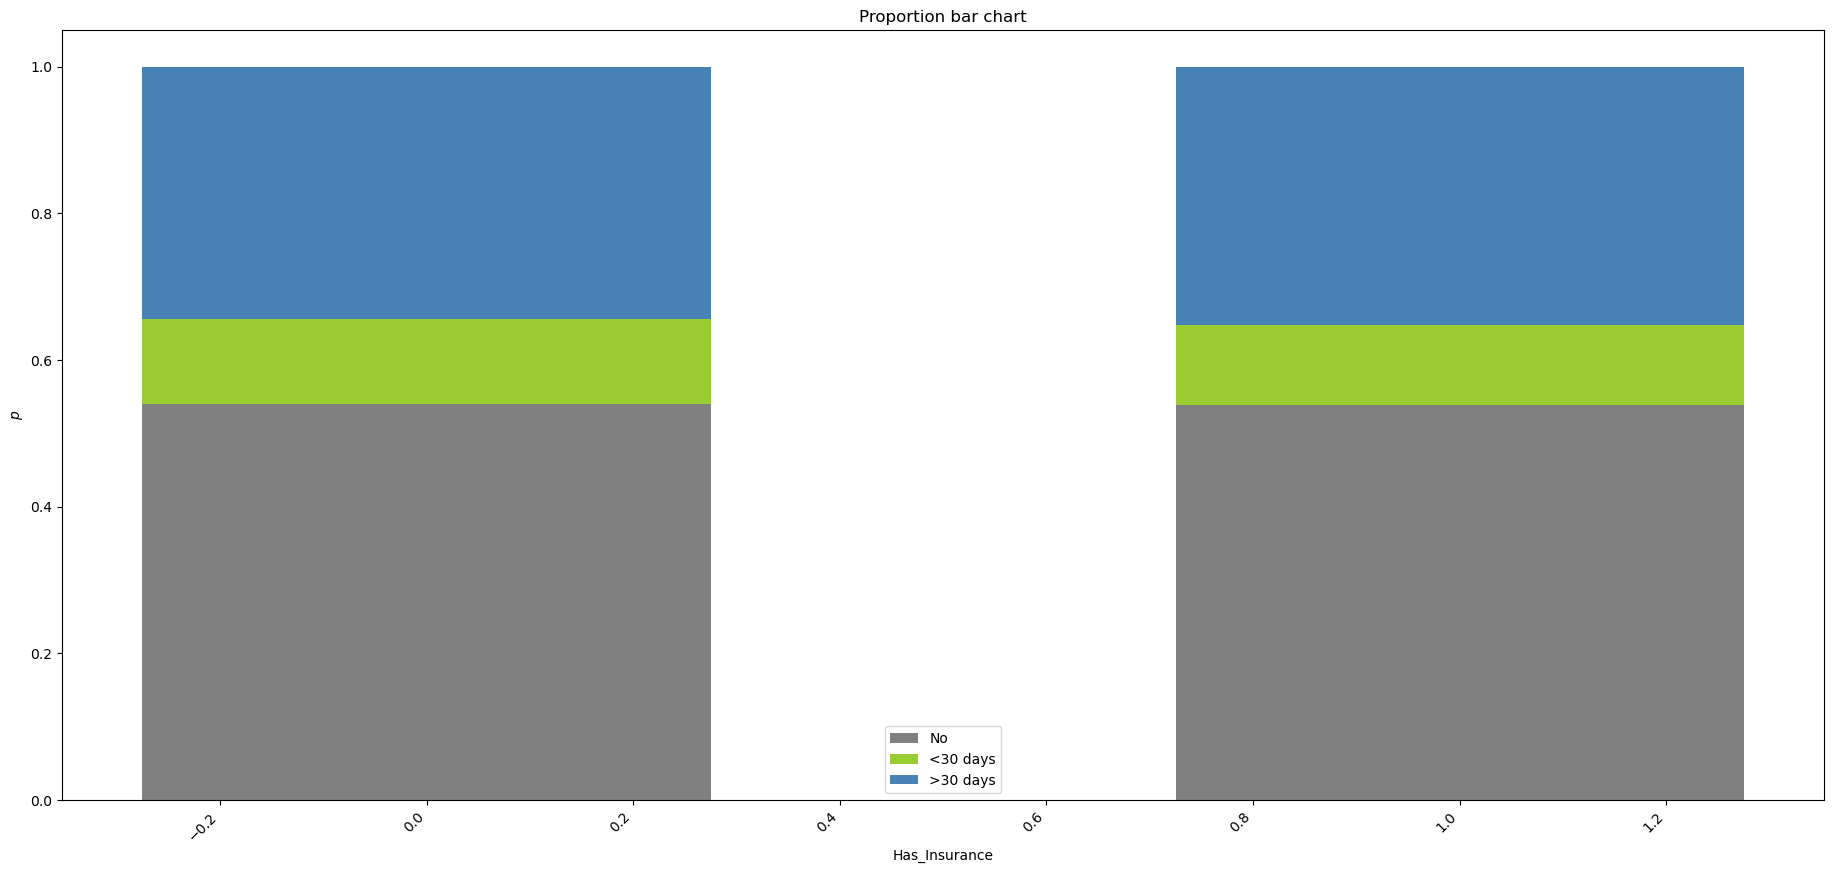

In [57]:
bar_charts_categorical(train, "Has_Insurance", "readmitted_multiclass")

### admission_type

In [58]:
train["admission_type"].value_counts()

admission_type
Emergency        37742
Elective         13211
Urgent           13024
Unknown           3706
Not Available     3320
Not Mapped         214
Trauma Center       13
Newborn              6
Name: count, dtype: int64

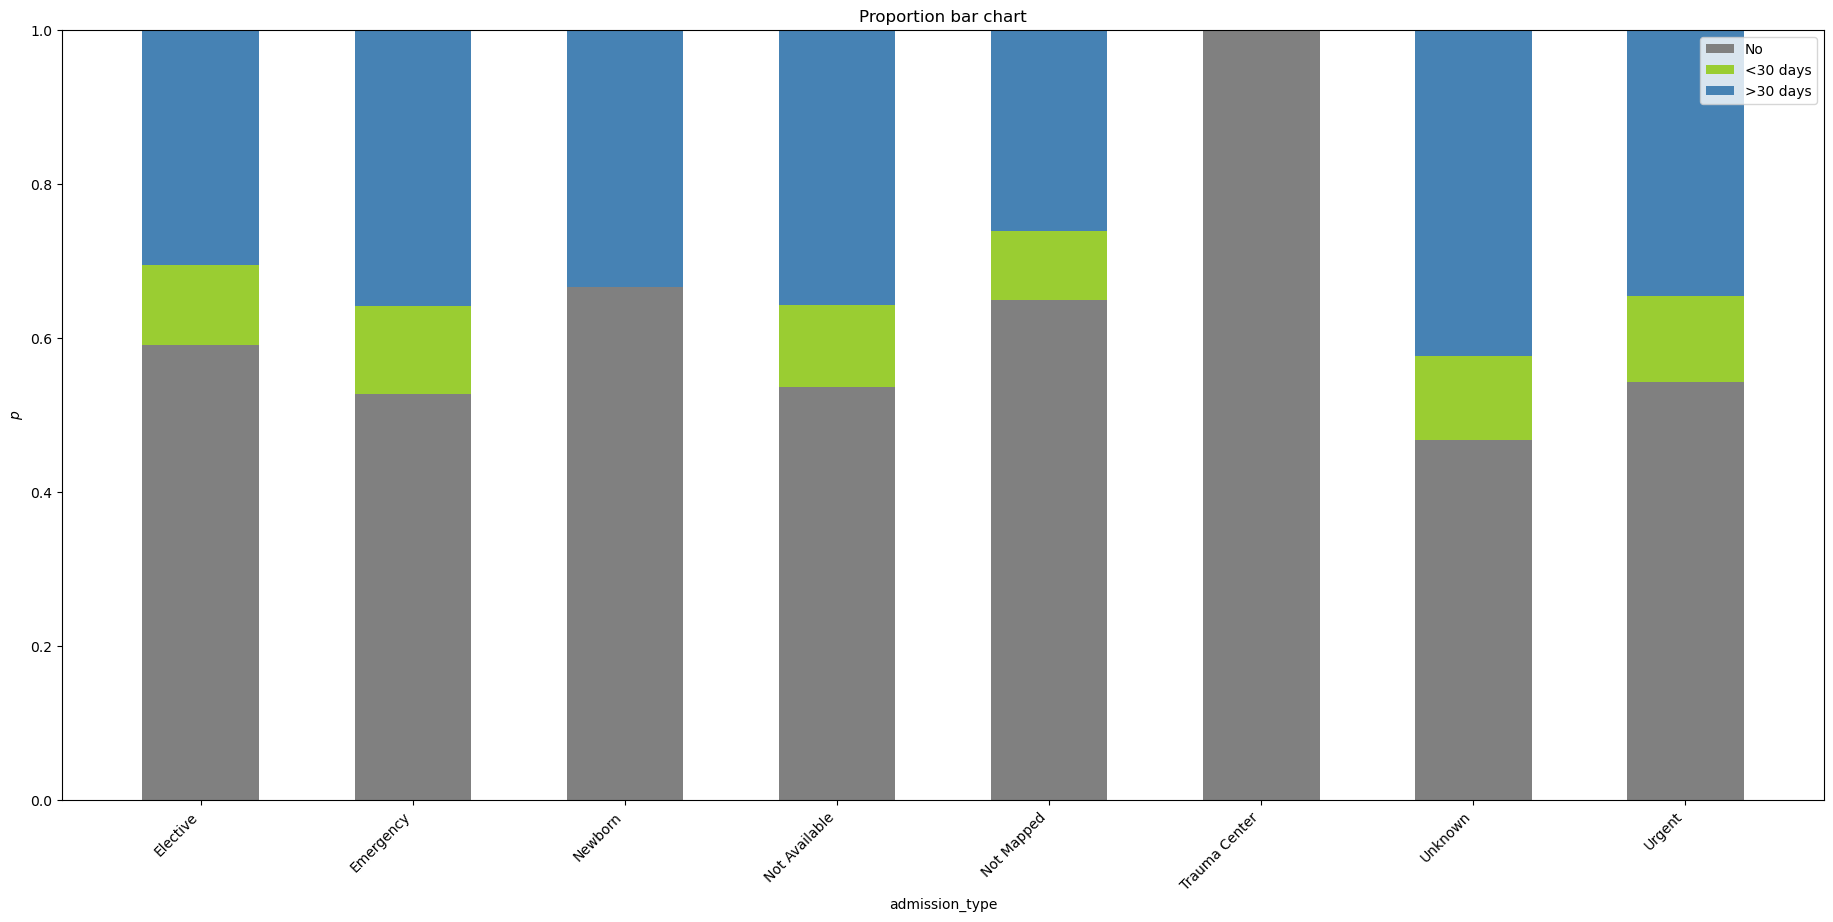

In [59]:
bar_charts_categorical(train, "admission_type", "readmitted_multiclass")

In [60]:
train['admission_type'] = train['admission_type'].replace({'Unknown':'Other_type',
                                                           'Not Available':'Other_type',
                                                           'Not Mapped':'Other_type',
                                                           'Newborn':'Other_type'})
train['admission_type'] = train['admission_type'].replace({'Trauma Center':'Urgent/Emergency',
                                                           'Urgent':'Urgent/Emergency', 
                                                           'Emergency':'Urgent/Emergency'})
train['admission_type'].value_counts(normalize=True)

admission_type
Urgent/Emergency    0.712828
Elective            0.185454
Other_type          0.101718
Name: proportion, dtype: float64

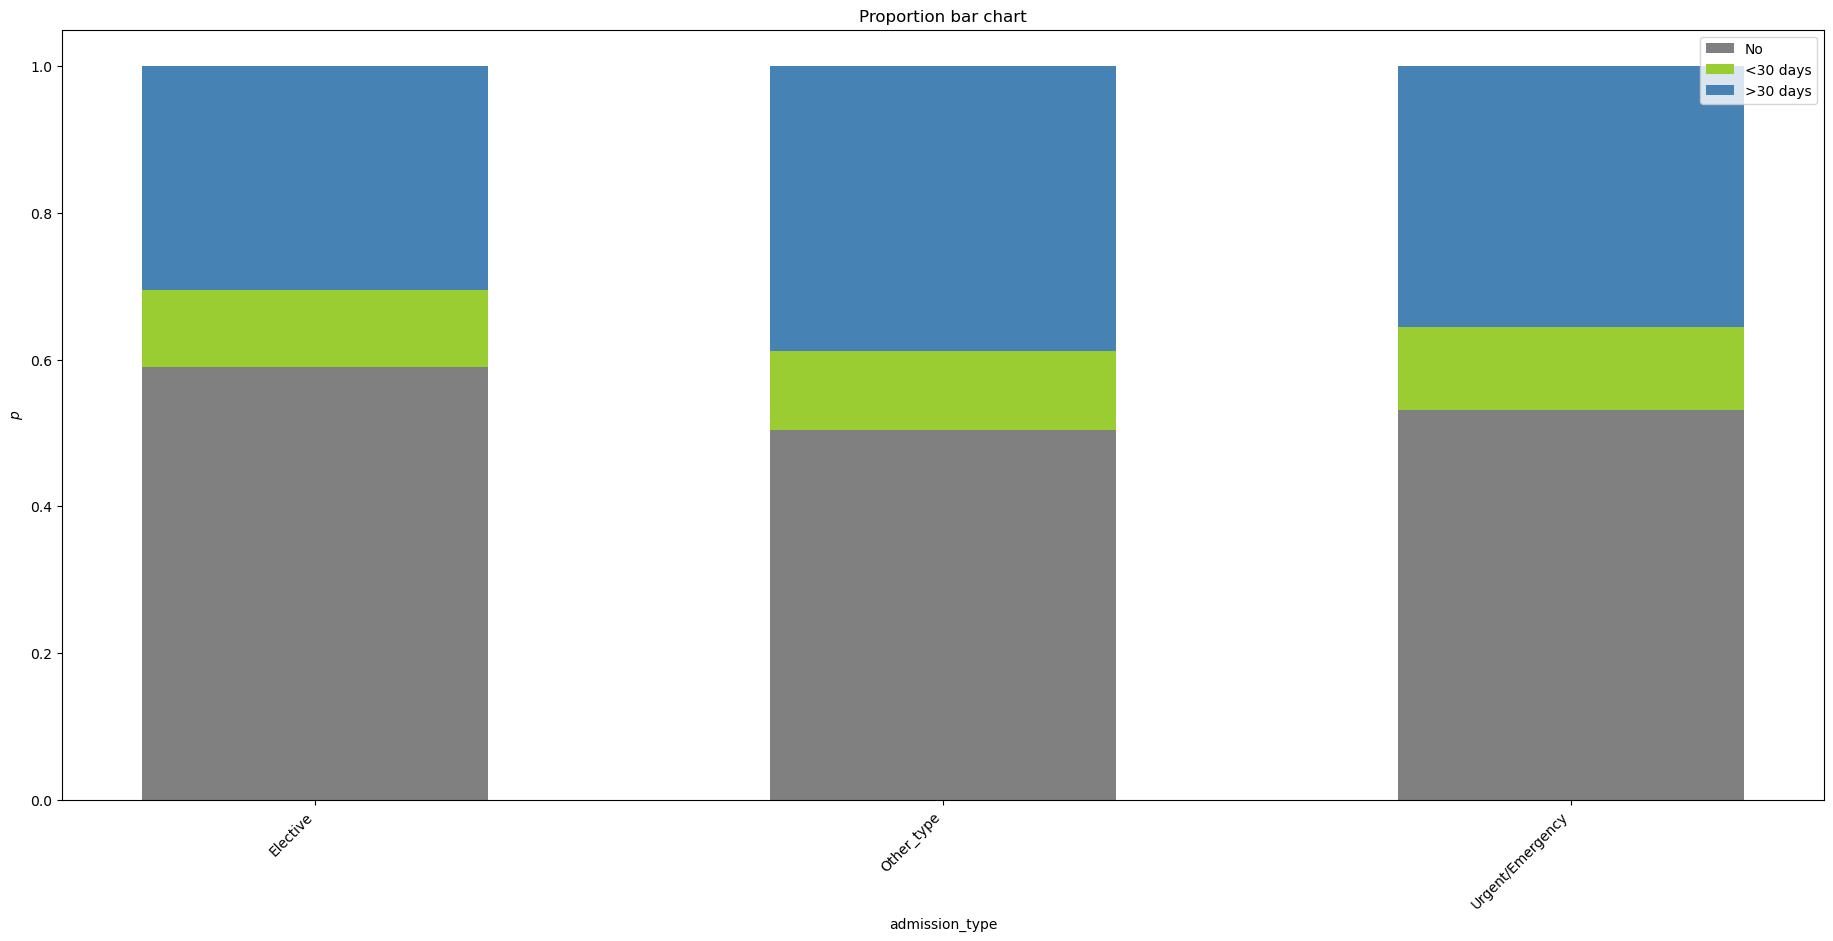

In [61]:
bar_charts_categorical(train, "admission_type", "readmitted_multiclass")

### medical_specialty

In [62]:
train['medical_specialty'].value_counts(normalize=True)

medical_specialty
Unknown                          0.490230
InternalMedicine                 0.144478
Emergency/Trauma                 0.074667
Family/GeneralPractice           0.073235
Cardiology                       0.052165
                                   ...   
Speech                           0.000014
SportsMedicine                   0.000014
Pediatrics-InfectiousDiseases    0.000014
Proctology                       0.000014
Neurophysiology                  0.000014
Name: proportion, Length: 69, dtype: float64

In [63]:
train['medical_specialty'].unique()

array(['Family/GeneralPractice', 'Unknown', 'InternalMedicine',
       'Surgery-General', 'Radiologist', 'Emergency/Trauma', 'Hematology',
       'Nephrology', 'Orthopedics', 'ObstetricsandGynecology',
       'Psychiatry', 'Cardiology', 'Gastroenterology', 'Psychology',
       'Surgery-Thoracic', 'Orthopedics-Reconstructive',
       'Surgery-Vascular', 'PhysicianNotFound', 'Neurology',
       'PhysicalMedicineandRehabilitation', 'Pulmonology',
       'Hematology/Oncology', 'Oncology', 'Surgery-Neuro', 'Radiology',
       'Urology', 'Pediatrics', 'Surgery-Cardiovascular/Thoracic',
       'Gynecology', 'Pediatrics-Endocrinology', 'Surgery-Maxillofacial',
       'Podiatry', 'Ophthalmology', 'Endocrinology', 'Obstetrics',
       'Pediatrics-CriticalCare', 'Otolaryngology',
       'Pediatrics-Neurology', 'Surgery-Cardiovascular', 'Hospitalist',
       'Surgery-Plastic', 'Osteopath', 'Pediatrics-Pulmonology',
       'SurgicalSpecialty', 'InfectiousDiseases', 'AllergyandImmunology',
       'S

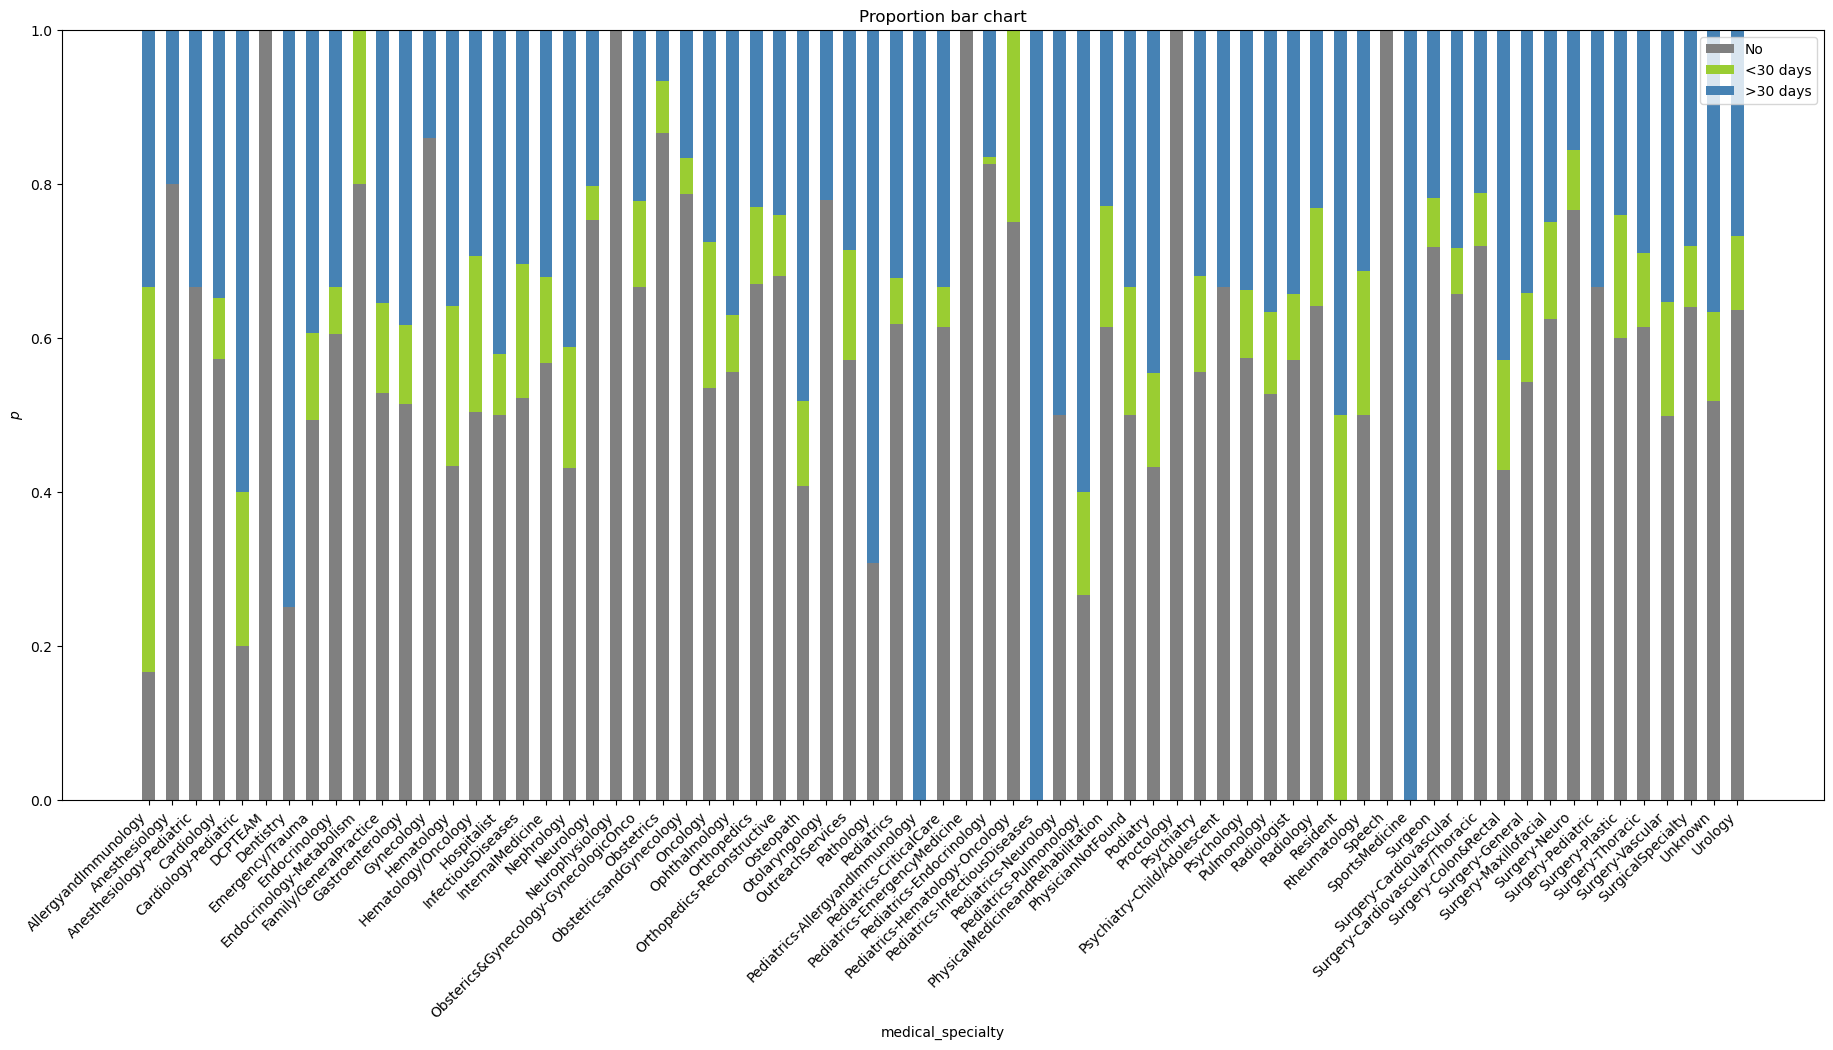

In [65]:
bar_charts_categorical(train, "medical_specialty", "readmitted_multiclass")

In [66]:
surgery = train[train['medical_specialty'].str.contains('Surgery|Surgeon|Surgical|Reconstructive')]
train.loc[surgery.index, 'medical_specialty'] = 'Surgery'

pediatric = train[train['medical_specialty'].str.contains('Pediatrics|Pediatric')]
train.loc[pediatric.index, 'medical_specialty'] = 'Pediatric'

hematology = train[train['medical_specialty'].str.contains('Hematology|Oncology')]
train.loc[hematology.index, 'medical_specialty'] = 'Hematology/Oncology'

train['medical_specialty'].value_counts(normalize=True)

medical_specialty
Unknown                                 0.490230
InternalMedicine                        0.144478
Emergency/Trauma                        0.074667
Family/GeneralPractice                  0.073235
Surgery                                 0.061907
Cardiology                              0.052165
Nephrology                              0.015947
Orthopedics                             0.013392
Radiologist                             0.011469
Pulmonology                             0.008577
Psychiatry                              0.008395
Urology                                 0.006710
ObstetricsandGynecology                 0.006570
Hematology/Oncology                     0.006303
Pediatric                               0.005784
Gastroenterology                        0.005573
PhysicalMedicineandRehabilitation       0.003931
Neurology                               0.001937
Otolaryngology                          0.001207
Endocrinology                           0.001137
Po

In [67]:
internal_medicine_categories = ['InternalMedicine', 'Endocrinology', 'Endocrinology-Metabolism', 'InfectiousDiseases', 
                                'Gastroenterology', 'Nephrology', 'Pulmonology', 'Rheumatology',
                                'AllergyandImmunology', 'Hematology/Oncology', 'SportsMedicine']
train['medical_specialty'] = train['medical_specialty'].replace(internal_medicine_categories, 'InternalMedicine')

surgery_categories = ['Surgery', 'Orthopedics', 'Otolaryngology', 'Podiatry', 'Proctology']
train['medical_specialty'] = train['medical_specialty'].replace(surgery_categories, 'Surgery')

value_counts = train['medical_specialty'].value_counts(normalize=True)
replace_medical_specialty = value_counts[value_counts < 0.05].index
train['medical_specialty'] = train['medical_specialty'].replace(replace_medical_specialty, 'Other_specialty')

train['medical_specialty'].value_counts(normalize=True)

medical_specialty
Unknown                   0.490230
InternalMedicine          0.182731
Surgery                   0.077559
Emergency/Trauma          0.074667
Family/GeneralPractice    0.073235
Cardiology                0.052165
Other_specialty           0.049413
Name: proportion, dtype: float64

In [68]:
train['medical_specialty'] = train['medical_specialty'].str.strip().str.replace('/', '_')

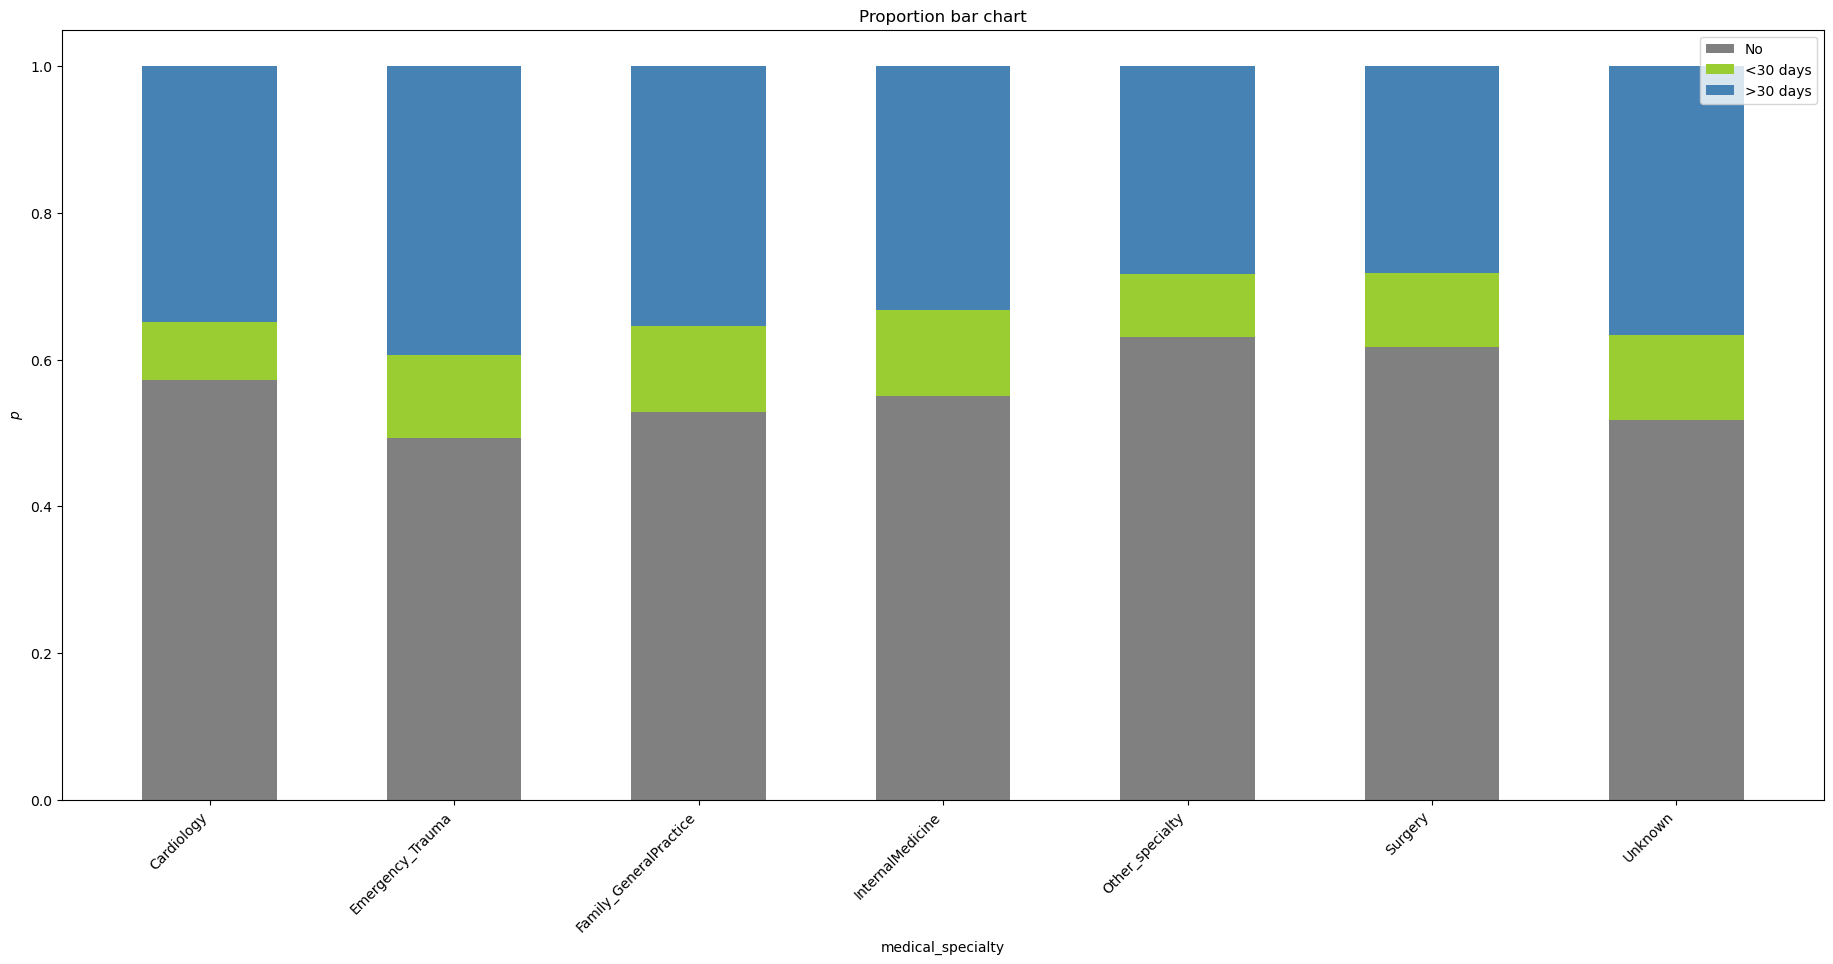

In [69]:
bar_charts_categorical(train, "medical_specialty", "readmitted_multiclass")

### discharge_disposition

In [70]:
train['discharge_disposition'].value_counts(normalize=True)

discharge_disposition
Discharged to home                                                                                           0.593183
Discharged/transferred to SNF                                                                                0.137290
Discharged/transferred to home with home health service                                                      0.126411
Unknown                                                                                                      0.036358
Discharged/transferred to another short term hospital                                                        0.020888
Discharged/transferred to another rehab fac including rehab units of a hospital .                            0.019555
Expired                                                                                                      0.015933
Discharged/transferred to another type of inpatient care institution                                         0.011539
Not Mapped                        

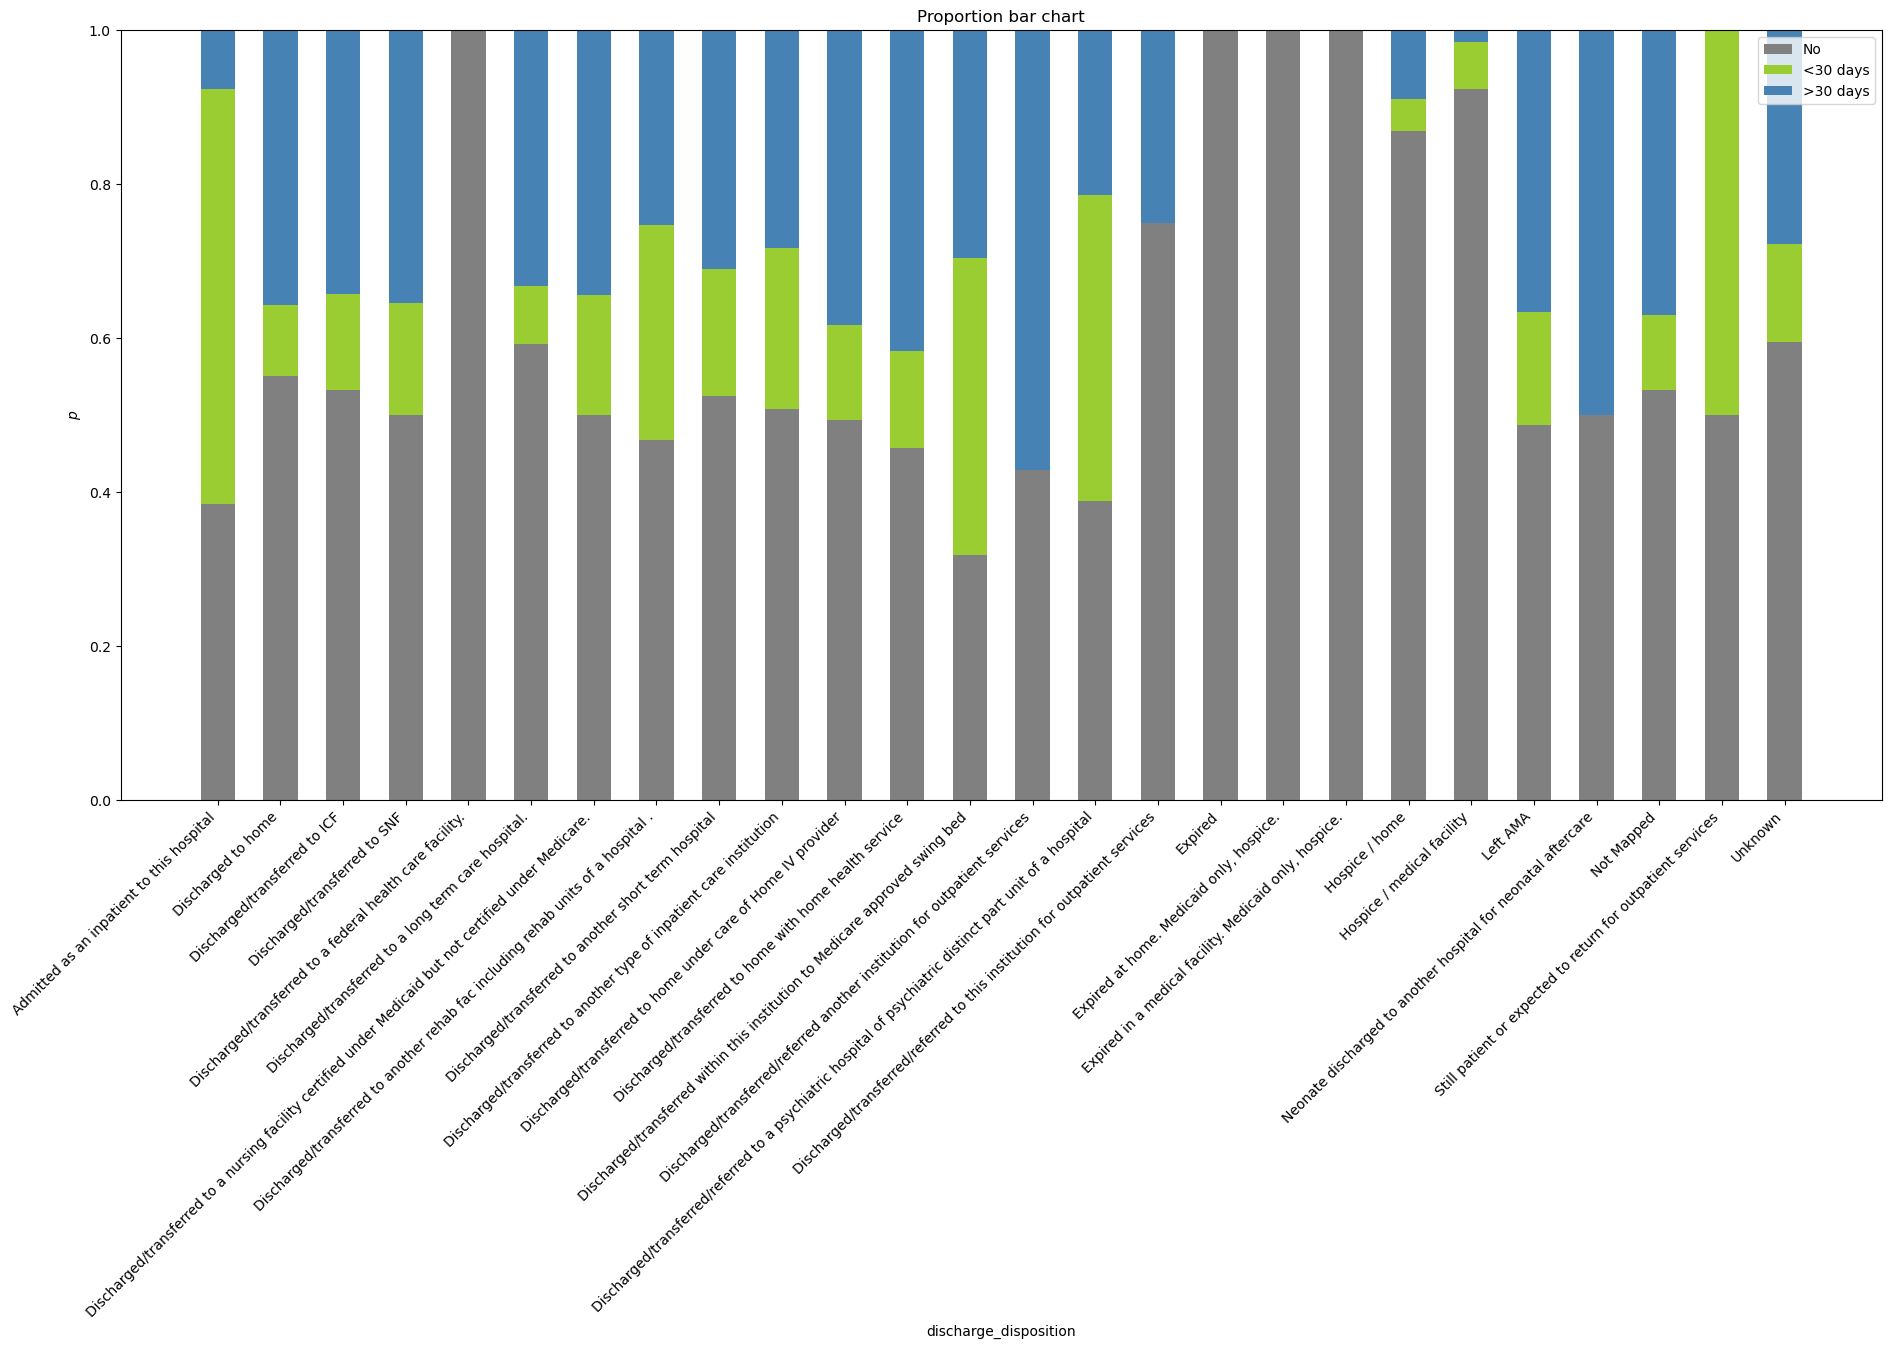

In [71]:
bar_charts_categorical(train, "discharge_disposition", "readmitted_multiclass")

In [72]:
expired = train[train['discharge_disposition'].str.contains('Expired')]
train.loc[expired.index, 'discharge_disposition'] = 'Expired'

hospice = train[train['discharge_disposition'].str.contains('Hospice')]
train.loc[hospice.index, 'discharge_disposition'] = 'Hospice'

rehab = train[train['discharge_disposition'].str.contains('rehab')]
train.loc[rehab.index, 'discharge_disposition'] = 'Rehab'

another_medical_facility = ['Discharged/transferred to SNF', 'Discharged/transferred to another short term hospital',
                            'Discharged/transferred to another type of inpatient care institution', 
                            'Discharged/transferred to a long term care hospital.', 
                            'Discharged/transferred to a federal health care facility.',
                            'Discharged/transferred to ICF',
                            'Neonate discharged to another hospital for neonatal aftercare',
                            'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.']
train['discharge_disposition'] = train['discharge_disposition'].replace(another_medical_facility, 'Transferred_to_another_medical_facility')

home = train[train['discharge_disposition'].str.contains('home')]
train.loc[home.index, 'discharge_disposition'] = 'Discharged_to_home'

other = ['Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
        'Discharged/transferred within this institution to Medicare approved swing bed',
        'Admitted as an inpatient to this hospital','Left AMA',
        'Discharged/transferred/referred to this institution for outpatient services',
        'Discharged/transferred/referred another institution for outpatient services',
        'Still patient or expected to return for outpatient services']
train['discharge_disposition'] = train['discharge_disposition'].replace(other, 'Other')

train['discharge_disposition'] = train['discharge_disposition'].replace('Not Mapped', 'Unknown')

In [73]:
train['discharge_disposition'].value_counts(normalize=True)

discharge_disposition
Discharged_to_home                         0.720731
Transferred_to_another_medical_facility    0.182183
Unknown                                    0.045890
Rehab                                      0.019555
Expired                                    0.016031
Other                                      0.008324
Hospice                                    0.007286
Name: proportion, dtype: float64

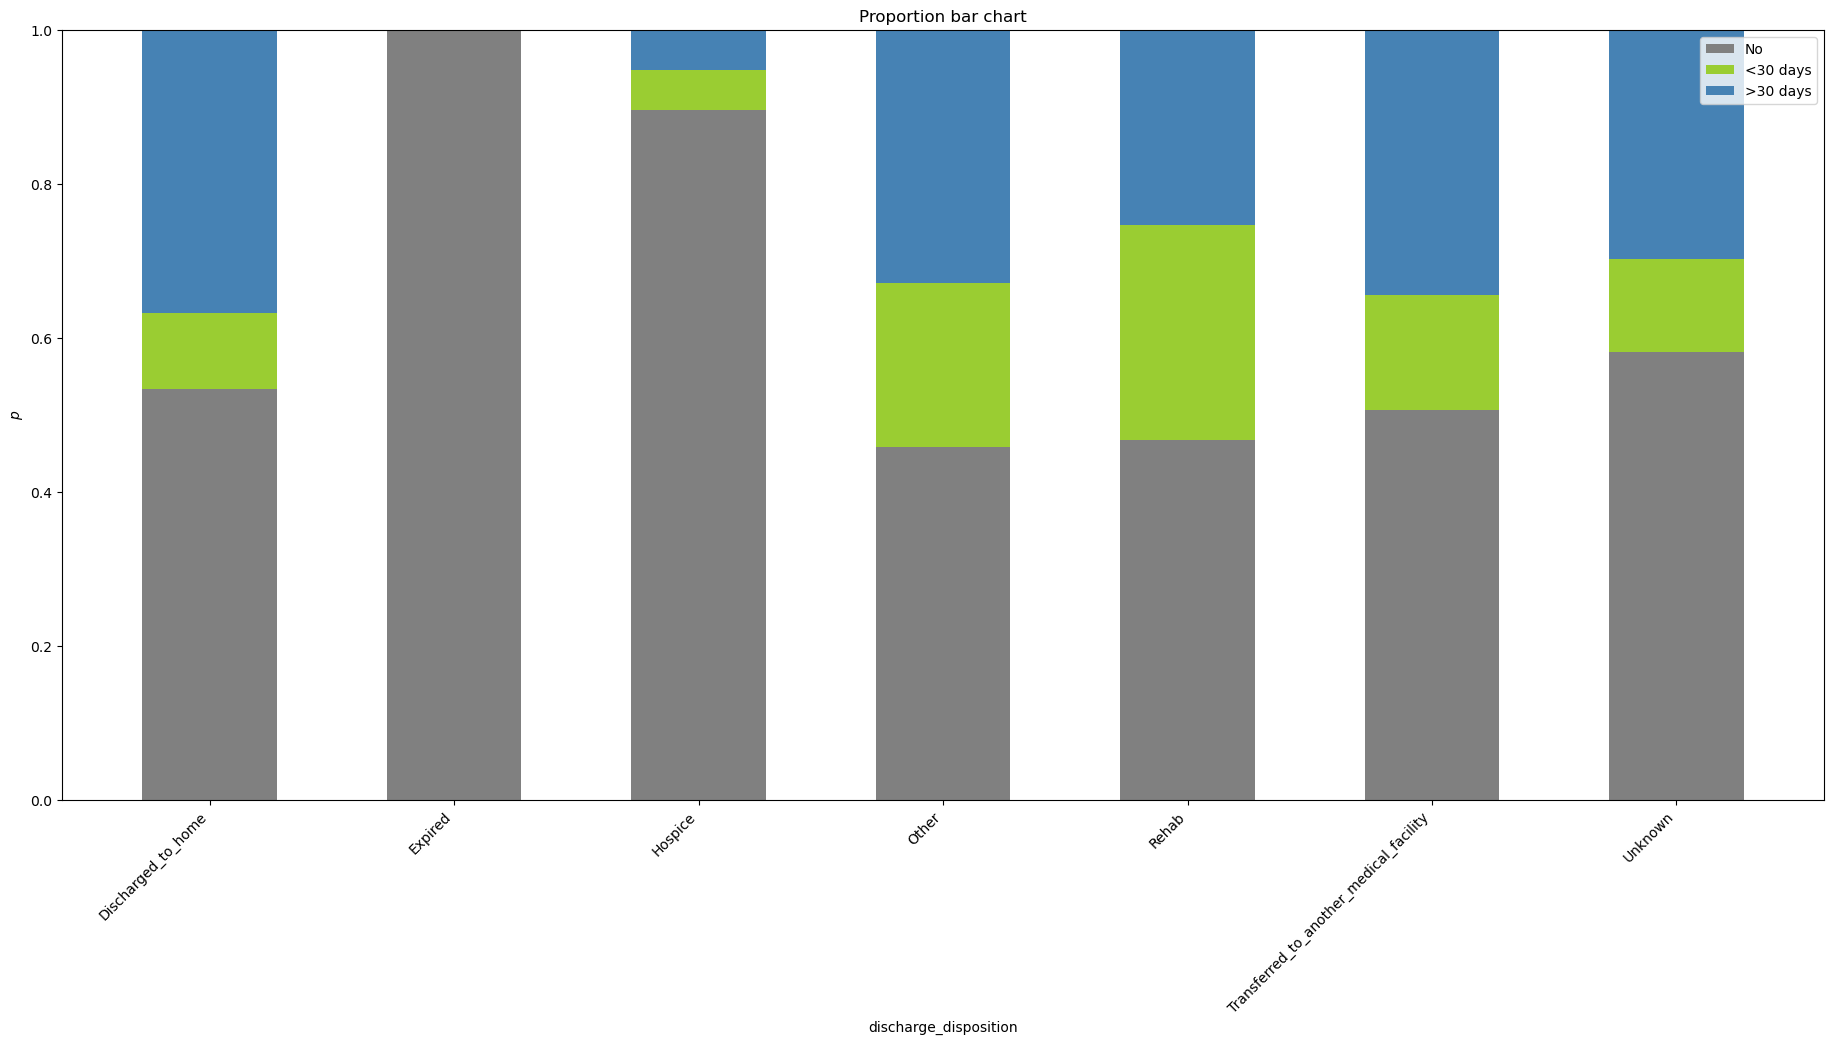

In [74]:
bar_charts_categorical(train, "discharge_disposition", "readmitted_multiclass")

### admission_source

In [75]:
train['admission_source'].value_counts(normalize=True)

admission_source
 Emergency Room                                               0.565992
 Physician Referral                                           0.290275
Unknown                                                       0.066231
Transfer from a hospital                                      0.031304
 Transfer from another health care facility                   0.021927
Clinic Referral                                               0.010935
 Transfer from a Skilled Nursing Facility (SNF)               0.008353
HMO Referral                                                  0.001811
 Not Mapped                                                   0.001502
 Not Available                                                0.001235
 Court/Law Enforcement                                        0.000154
 Transfer from hospital inpt/same fac reslt in a sep claim    0.000112
 Transfer from critial access hospital                        0.000098
 Transfer from Ambulatory Surgery Center                    

In [76]:
train['admission_source'] = train['admission_source'].str.strip().str.replace(' ', '_')
train['admission_source'].unique()

array(['Emergency_Room', 'Clinic_Referral', 'Unknown',
       'Transfer_from_another_health_care_facility', 'Physician_Referral',
       'Transfer_from_a_hospital', 'HMO_Referral',
       'Transfer_from_a_Skilled_Nursing_Facility_(SNF)', 'Not_Mapped',
       'Not_Available', 'Court/Law_Enforcement',
       'Transfer_from_hospital_inpt/same_fac_reslt_in_a_sep_claim',
       'Transfer_from_critial_access_hospital', 'Extramural_Birth',
       'Normal_Delivery', 'Transfer_from_Ambulatory_Surgery_Center',
       'Sick_Baby'], dtype=object)

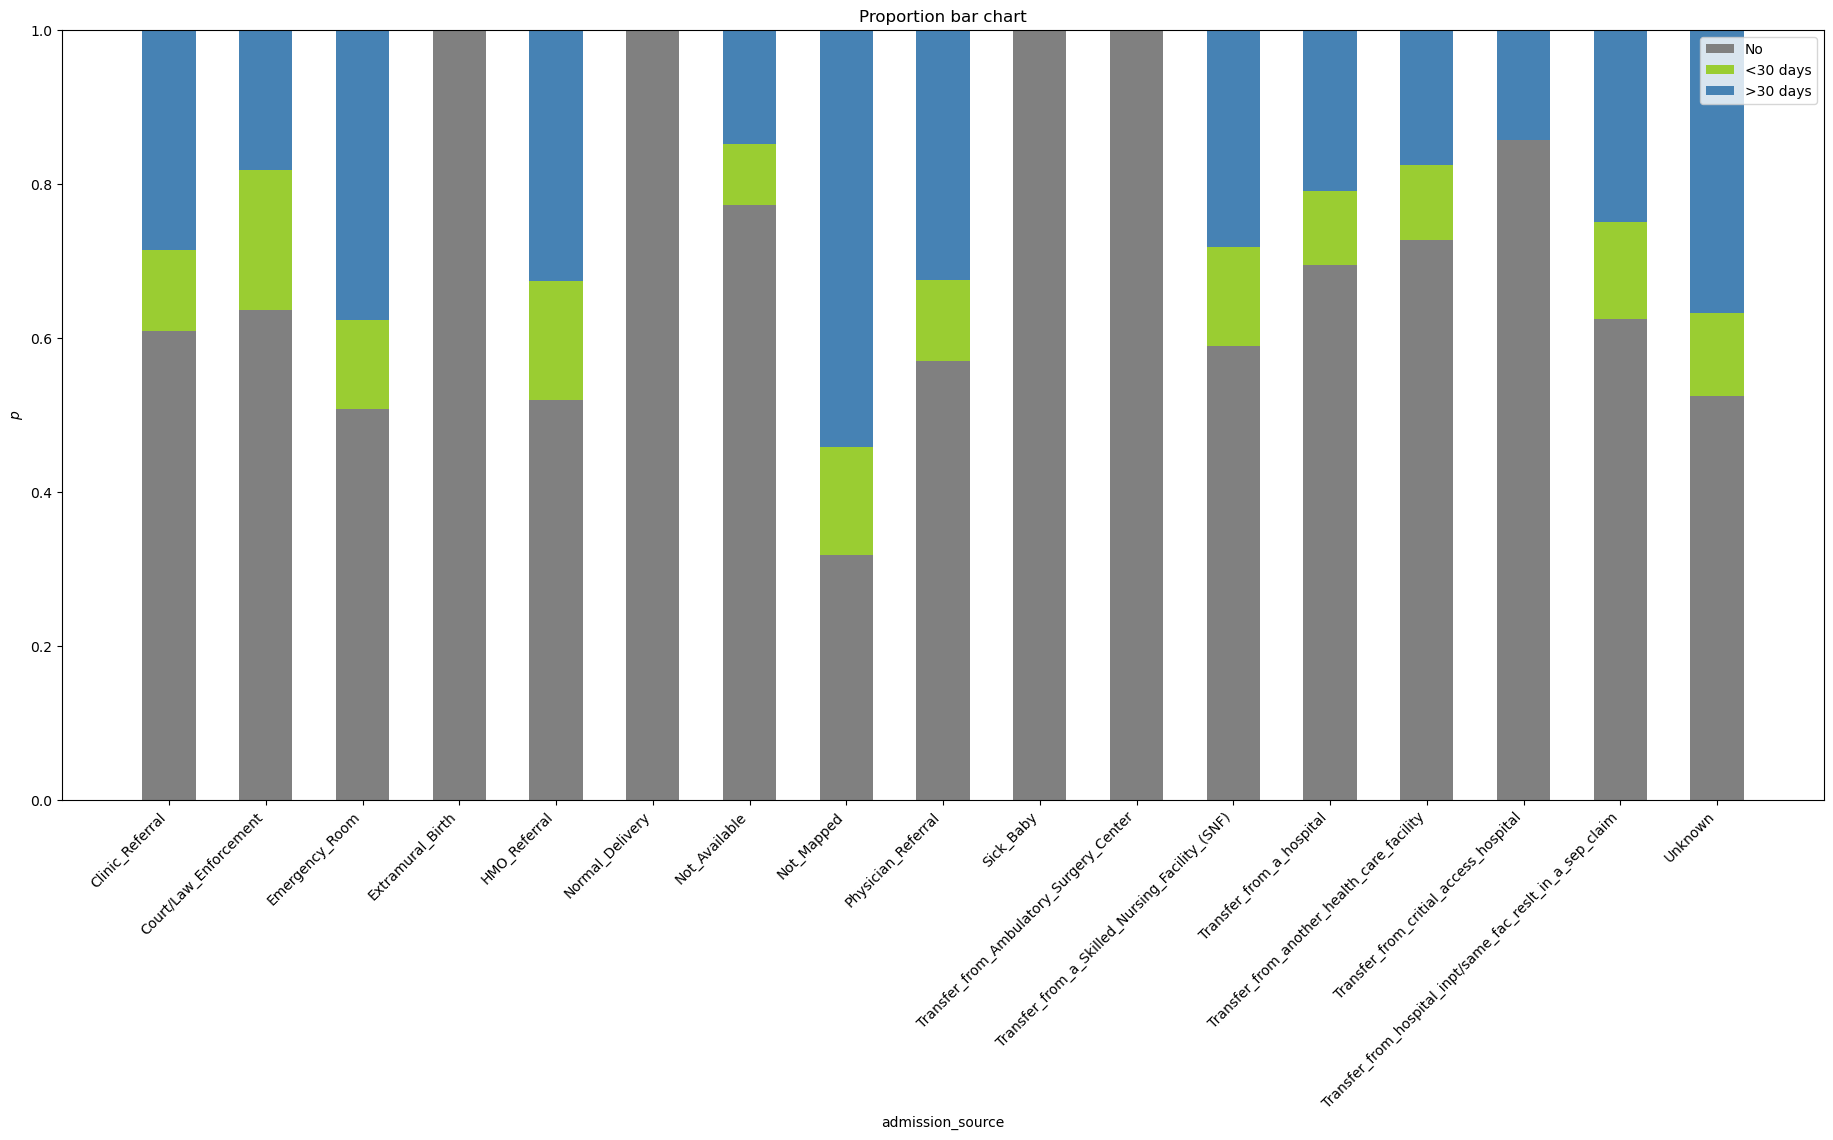

In [77]:
bar_charts_categorical(train, "admission_source", "readmitted_multiclass")

In [78]:
unknown = ['Not_Mapped','Not_Available','Unknown']
referral = ['Physician_Referral','Clinic_Referral','HMO_Referral']

value_counts = train['admission_source'].value_counts(normalize=True)
other_source = value_counts[value_counts < 0.05].index

train['admission_source'] = train['admission_source'].replace(unknown,'No_source').replace(referral,'Referral').replace(other_source,'Other_source')

In [79]:
train['admission_source'].value_counts(normalize=True)

admission_source
Emergency_Room    0.565992
Referral          0.303021
No_source         0.068968
Other_source      0.062019
Name: proportion, dtype: float64

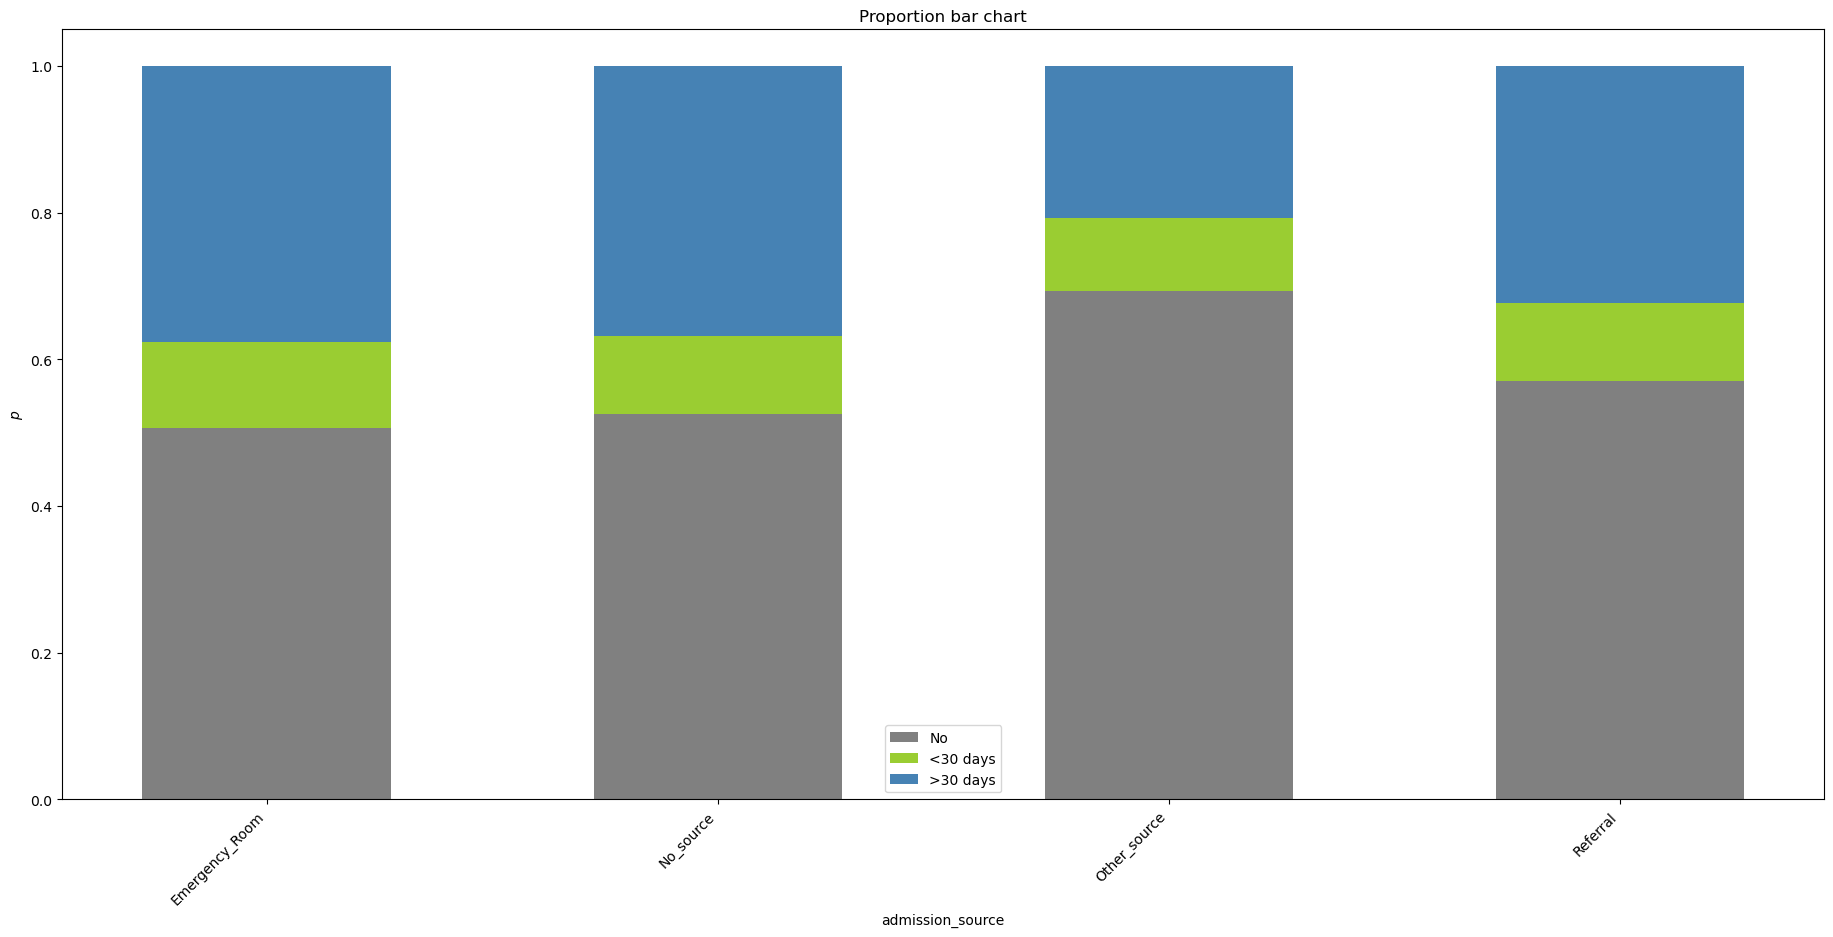

In [80]:
bar_charts_categorical(train, "admission_source", "readmitted_multiclass")

### _diagnosis

In [81]:
# Define a function to categorize diagnosis types
def diagnosis_types_division(x):
    try:
        x = float(x)
        x = int(x)
        if 1 <= x <= 139:
            return 'Infectious_Parasitic'
        elif 140 <= x <= 239:
            return 'Neoplasms'
        elif 240 <= x <= 249 or 251 <= x <= 279:
            return 'Metabolic'
        elif 250 <= x < 251:
            return 'Diabetes'
        elif 280 <= x <= 289:
            return 'Blood'
        elif 290 <= x <= 319:
            return 'Mental'
        elif 320 <= x <= 389:
            return 'Nervous'
        elif 390 <= x <= 459:
            return 'Circulatory'
        elif 460 <= x <= 519:
            return 'Respiratory'
        elif 520 <= x <= 579:
            return 'Digestive'
        elif 580 <= x <= 629:
            return 'Genitourinary'
        elif 630 <= x <= 679:
            return 'Pregnancy'
        elif 680 <= x <= 709:
            return 'Skin'
        elif 710 <= x <= 739:
            return 'Musculoskeletal'
        elif 740 <= x <= 759:
            return 'Congenital'
        elif 760 <= x <= 779:
            return 'Perinatal_period'
        elif 780 <= x <= 799:
            return 'Symptoms_Signs_Conditions'
        elif 800 <= x <= 999:
            return 'Injury_Poisoning'
        else:
            return 'External'
    except ValueError:
        return 'External'

In [83]:
train['primary_diagnosis_types'] = train['primary_diagnosis'].apply(diagnosis_types_division)
train['secondary_diagnosis_types'] = train['secondary_diagnosis'].apply(diagnosis_types_division)
train['additional_diagnosis_types'] = train['additional_diagnosis'].apply(diagnosis_types_division)

In [84]:
train = train.drop(['primary_diagnosis','secondary_diagnosis','additional_diagnosis'], axis=1)

In [85]:
train['primary_diagnosis_types'].value_counts(normalize=True)

primary_diagnosis_types
Circulatory                  0.297925
Respiratory                  0.102350
Digestive                    0.090909
Diabetes                     0.085687
Symptoms_Signs_Conditions    0.075481
Injury_Poisoning             0.068519
Genitourinary                0.049961
Musculoskeletal              0.048332
Neoplasms                    0.034028
Infectious_Parasitic         0.027626
Metabolic                    0.026110
Skin                         0.024482
Mental                       0.022110
External                     0.016438
Nervous                      0.011946
Blood                        0.010655
Pregnancy                    0.006879
Congenital                   0.000562
Name: proportion, dtype: float64

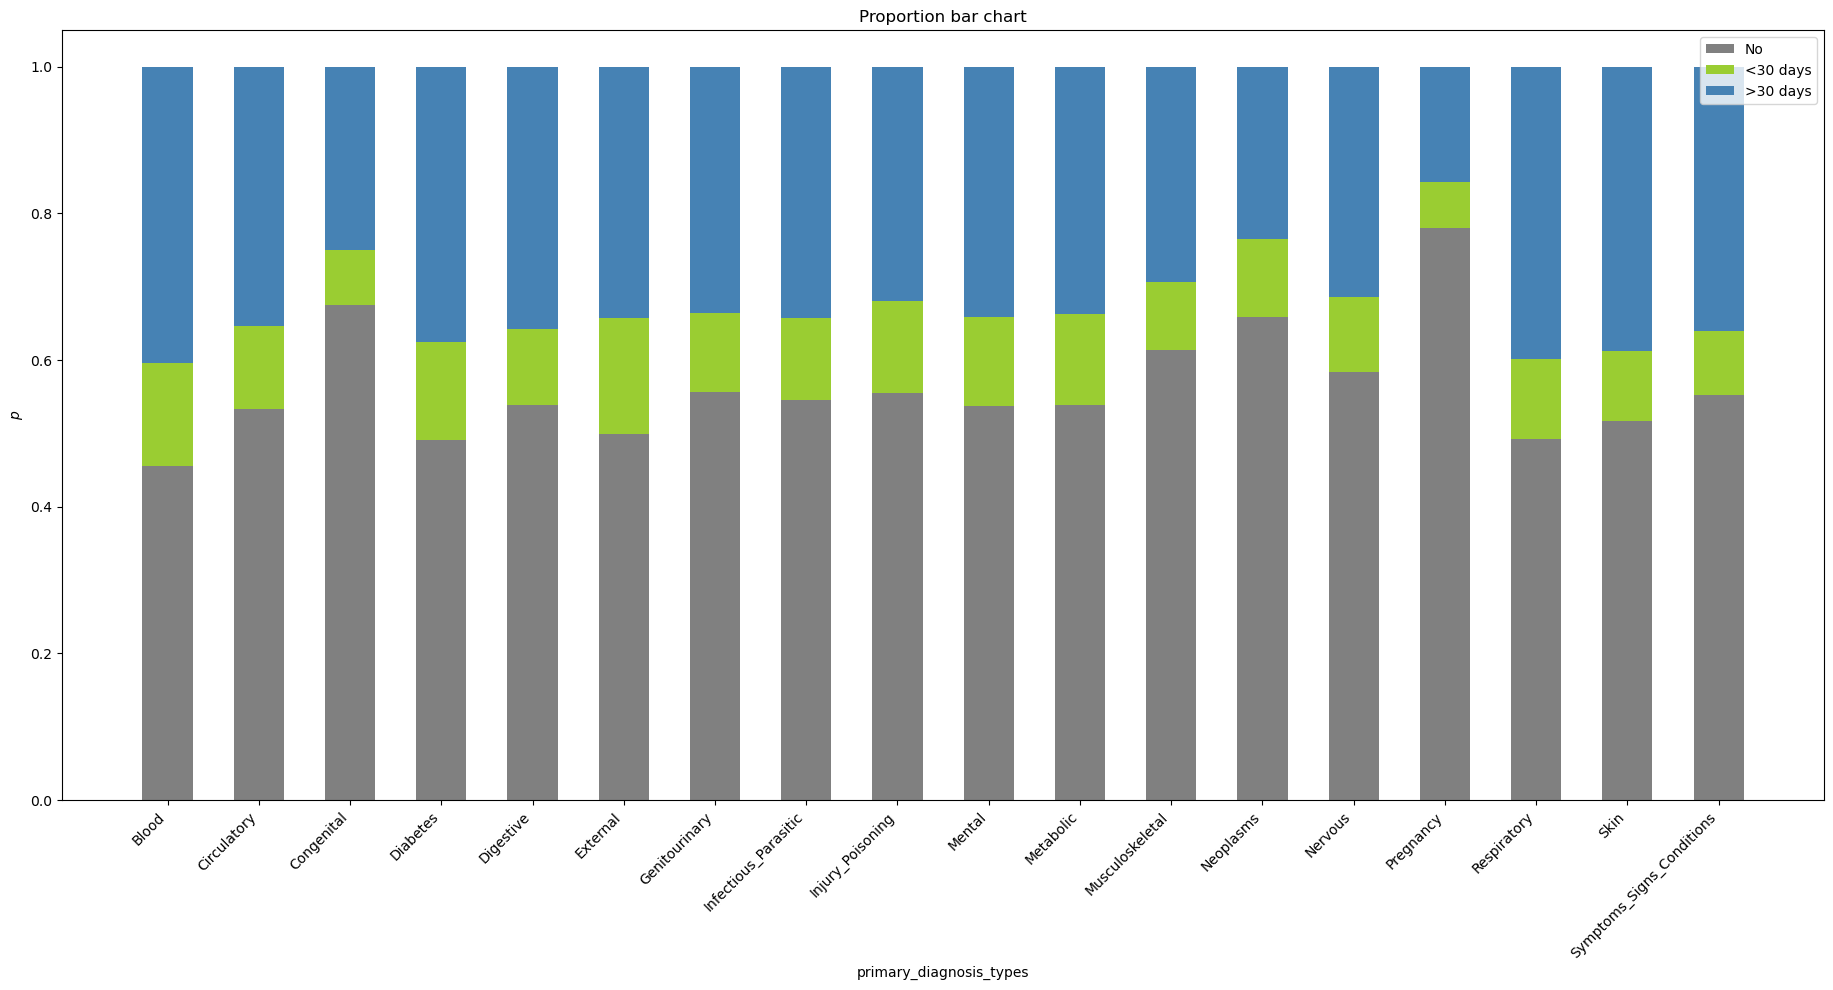

In [86]:
bar_charts_categorical(train, "primary_diagnosis_types", "readmitted_multiclass")

In [87]:
train['secondary_diagnosis_types'].value_counts(normalize=True)

secondary_diagnosis_types
Circulatory                  0.308819
Diabetes                     0.125470
Respiratory                  0.100960
Metabolic                    0.080661
Genitourinary                0.078724
Symptoms_Signs_Conditions    0.044837
Digestive                    0.038562
Skin                         0.035586
Blood                        0.029114
External                     0.028665
Mental                       0.025802
Neoplasms                    0.024777
Injury_Poisoning             0.024187
Infectious_Parasitic         0.019063
Musculoskeletal              0.017238
Nervous                      0.012381
Pregnancy                    0.004099
Congenital                   0.001053
Name: proportion, dtype: float64

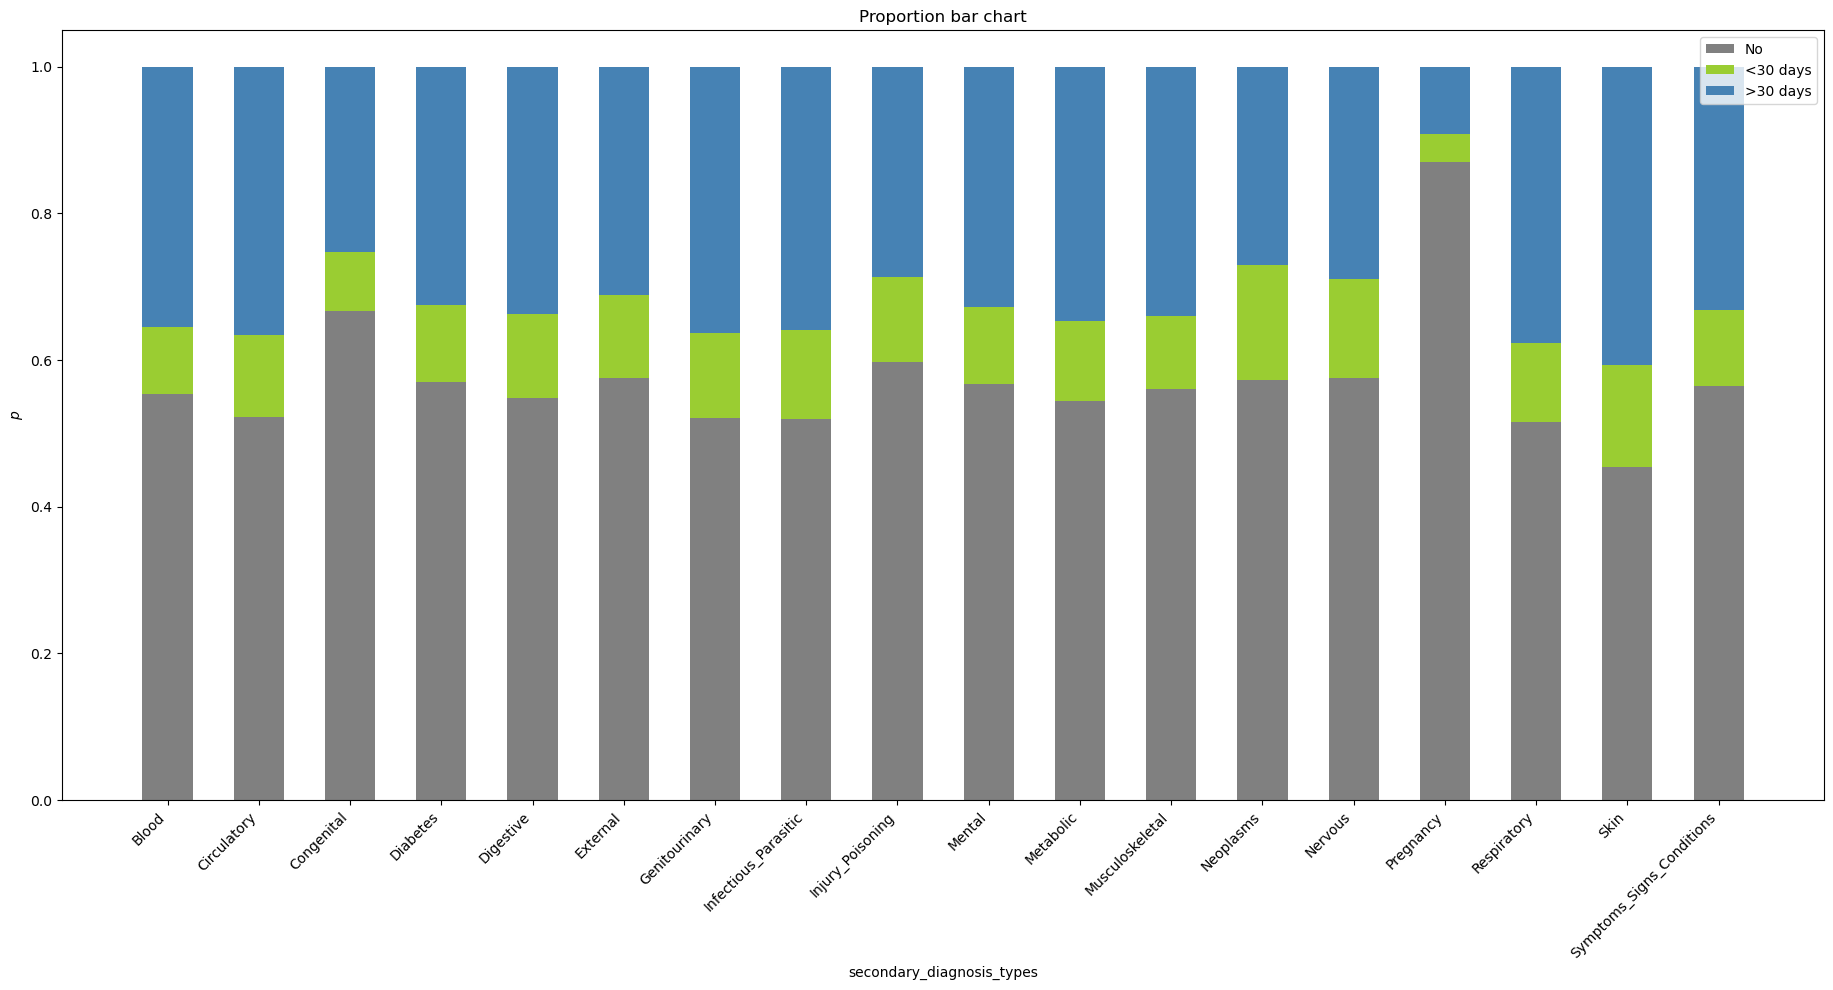

In [88]:
bar_charts_categorical(train, "secondary_diagnosis_types", "readmitted_multiclass")

In [89]:
train['additional_diagnosis_types'].value_counts(normalize=True)

additional_diagnosis_types
Circulatory                  0.294219
Diabetes                     0.167429
Metabolic                    0.089393
Respiratory                  0.066385
External                     0.063872
Genitourinary                0.062735
Symptoms_Signs_Conditions    0.043967
Digestive                    0.035291
Mental                       0.031178
Skin                         0.024594
Blood                        0.024566
Injury_Poisoning             0.019414
Musculoskeletal              0.018628
Infectious_Parasitic         0.018558
Neoplasms                    0.018207
Nervous                      0.017477
Pregnancy                    0.003173
Congenital                   0.000912
Name: proportion, dtype: float64

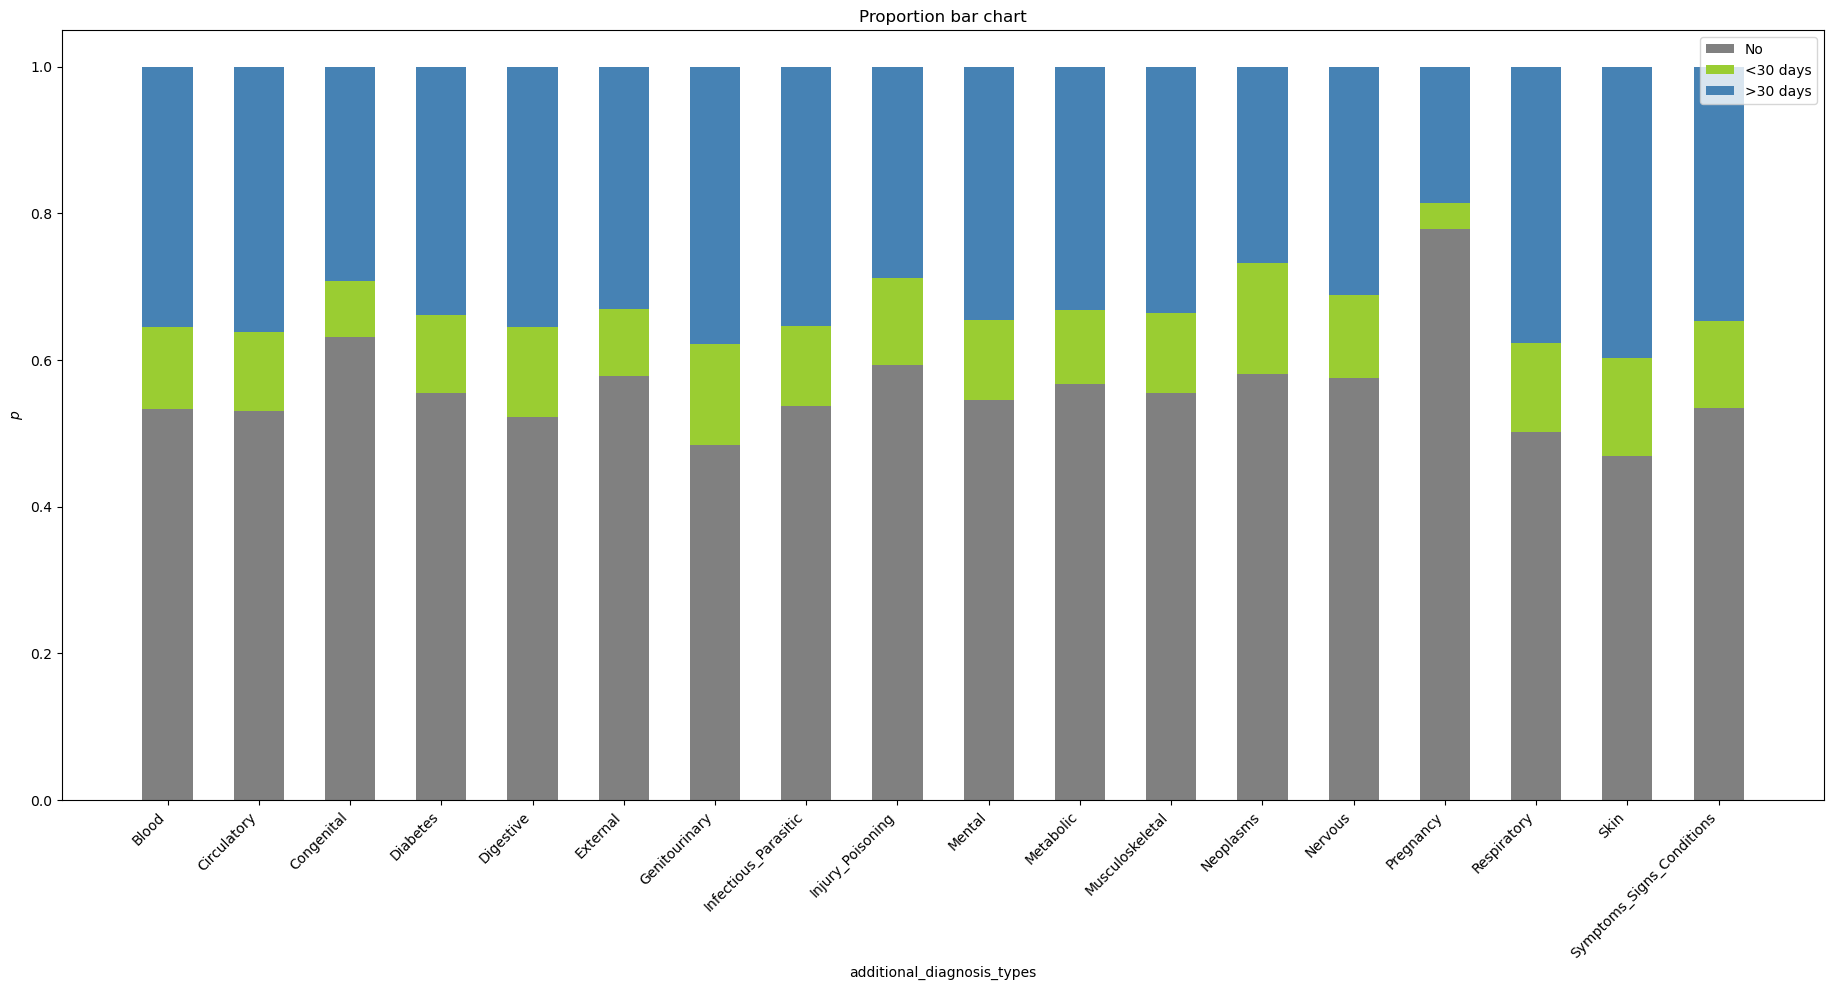

In [90]:
bar_charts_categorical(train, "additional_diagnosis_types", "readmitted_multiclass")

### glucose_test_result

In [91]:
train['glucose_test_result'].value_counts(normalize=True)

glucose_test_result
Not_taken    0.948228
Norm         0.025352
>200         0.014810
>300         0.011609
Name: proportion, dtype: float64

In [92]:
train['glucose_test_result'] = train['glucose_test_result'].replace('>200', 'High')
train['glucose_test_result'] = train['glucose_test_result'].replace('>300', 'High')

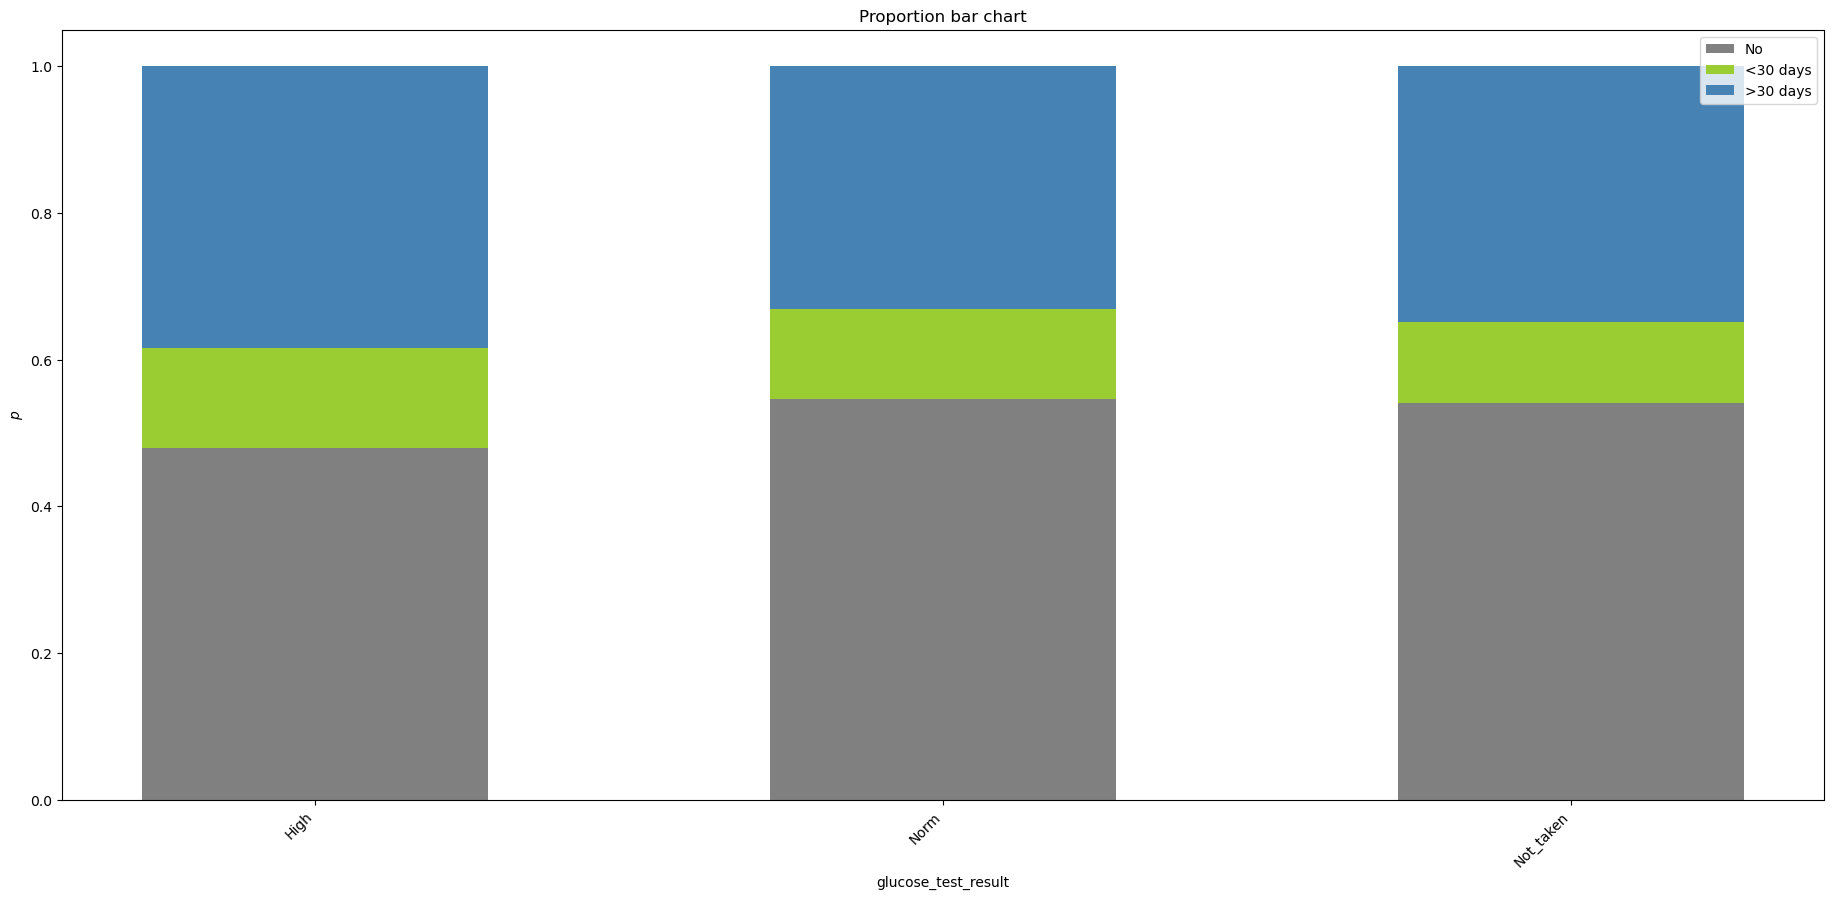

In [93]:
bar_charts_categorical(train, "glucose_test_result", "readmitted_multiclass")

### a1c_test_result

In [94]:
train['a1c_test_result'].value_counts(normalize=True)

a1c_test_result
Not_taken    0.832725
>8           0.080086
Norm         0.049175
>7           0.038014
Name: proportion, dtype: float64

In [95]:
train['a1c_test_result'] = train['a1c_test_result'].replace('>7', 'High')
train['a1c_test_result'] = train['a1c_test_result'].replace('>8', 'High')

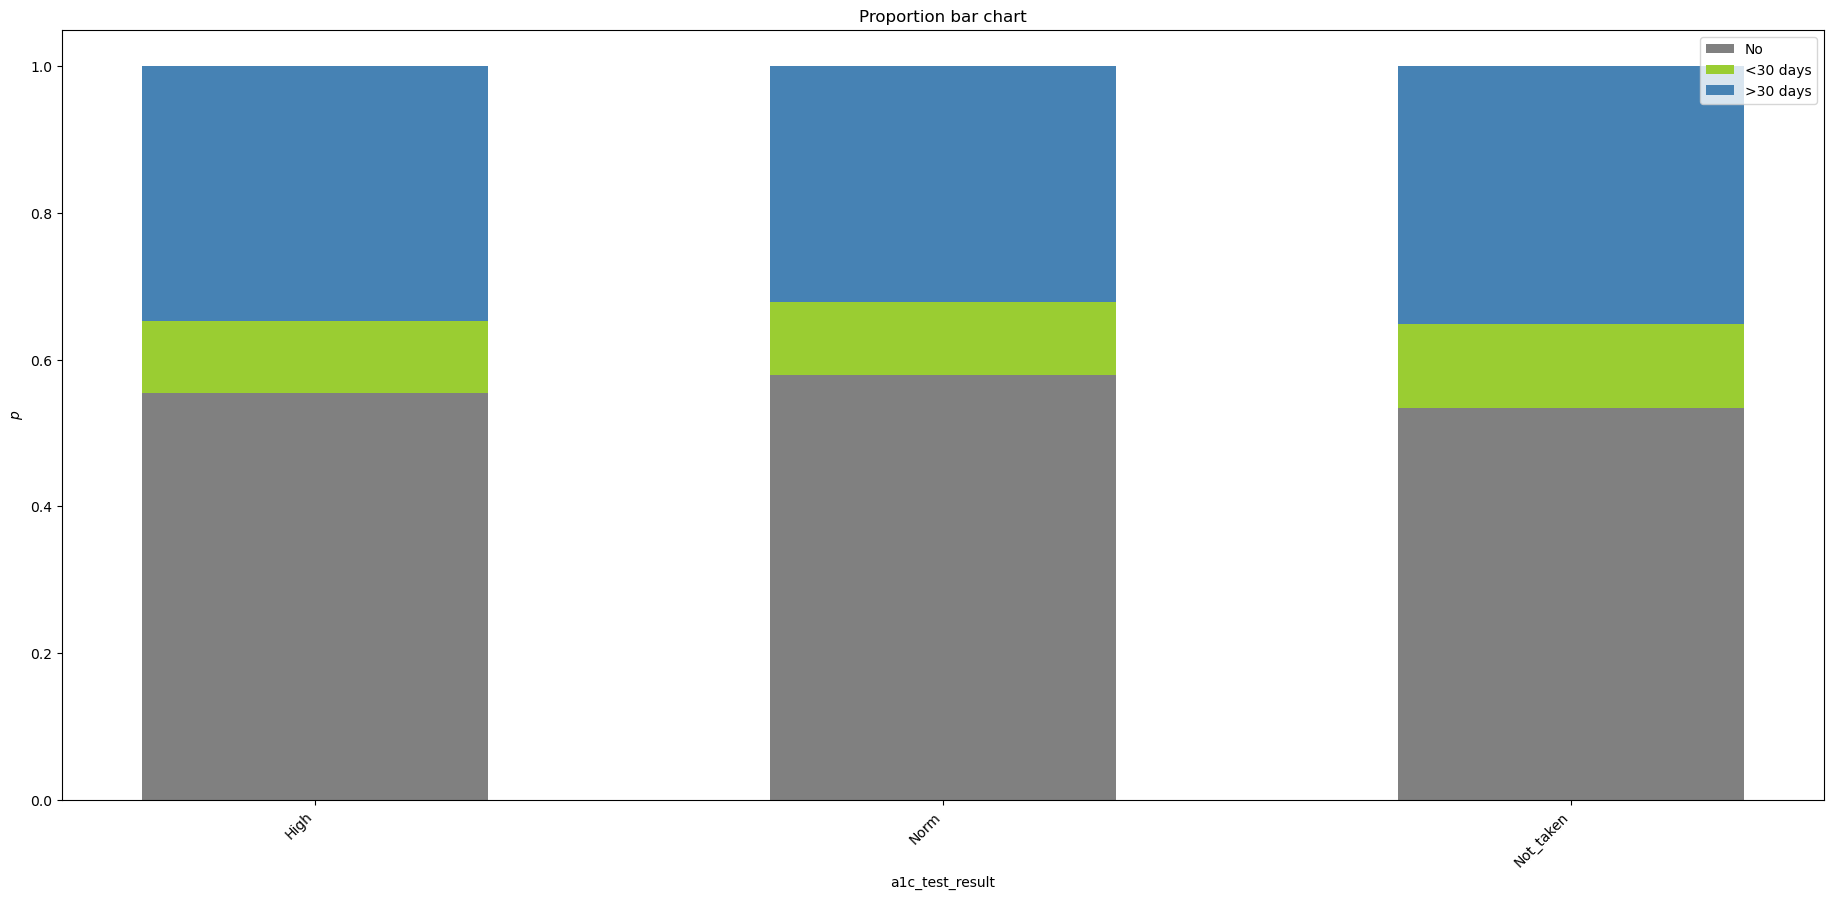

In [96]:
bar_charts_categorical(train, "a1c_test_result", "readmitted_multiclass")

In [97]:
### average_pulse_bpm

In [98]:
train['Midpoint_Age'] = train['Midpoint_Age'].replace('Unknown', np.nan)

In [99]:
train['Midpoint_Age'].isna().sum()

2217

In [100]:
def label_pulse(row):
    age = row['Midpoint_Age']
    pulse = row['average_pulse_bpm']
    if age == 5.0:
        return 1 if 70 <= pulse <= 130 else 0
    elif 25.0 <= age <= 45.0:
        return 1 if 60 <= pulse <= 110 else 0
    elif age >= 65.0:
        return 1 if 60 <= pulse <= 95 else 0
    else:
        return 1 if 60 <= pulse <= 100 else 0

In [101]:
train['is_normal_pulse'] = train.apply(lambda row: label_pulse(row), axis=1)

In [102]:
train['is_normal_pulse'].value_counts(normalize=True)

is_normal_pulse
0    0.512283
1    0.487717
Name: proportion, dtype: float64

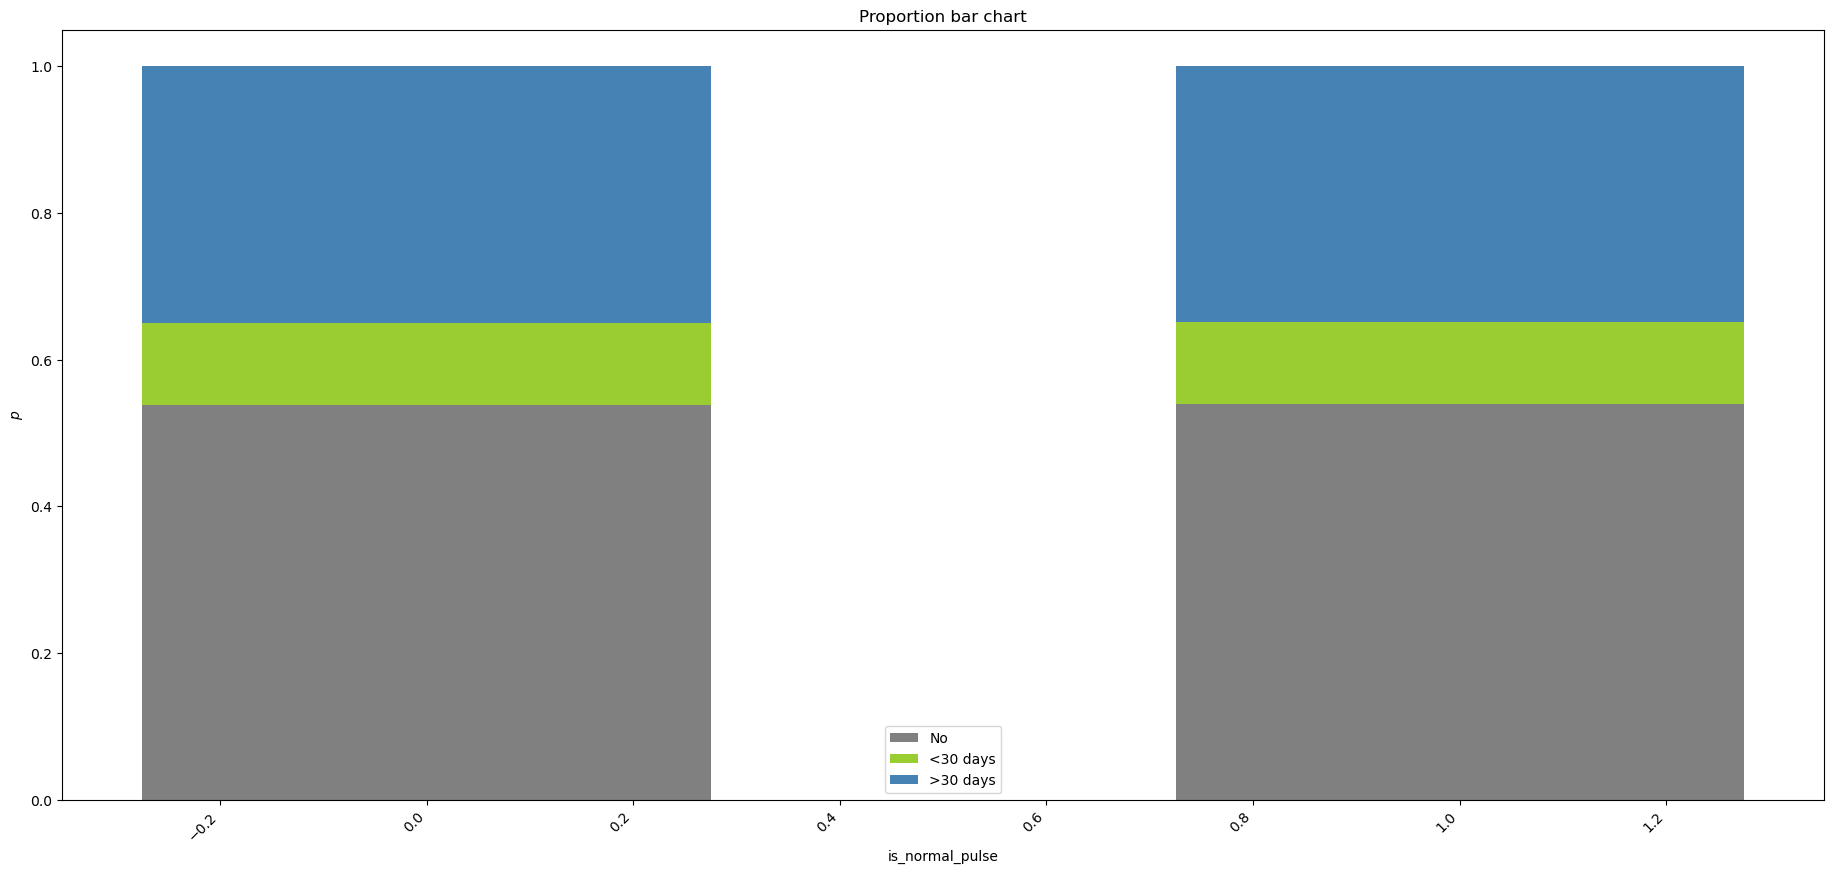

In [103]:
bar_charts_categorical(train, "is_normal_pulse", "readmitted_multiclass")

### patient_id

In [104]:
train['patient_id'].nunique()

53985

In [105]:
# Create a boolean mask for duplicated 'patient_id'
mask = train.duplicated(subset='patient_id', keep=False)

# Apply the mask to the dataframe
grouped_df = train[mask].groupby('patient_id')

# Sort each patient by encounter
sorted_grouped_df = grouped_df.apply(lambda x: x.sort_index())

sorted_grouped_df

patient_id             race  payer_code  \
patient_id encounter_id                                            
135        536851               135        Caucasian        None   
           538318               135        Caucasian        None   
1152       265544              1152  AfricanAmerican        None   
           334769              1152  AfricanAmerican        None   
           541693              1152  AfricanAmerican        None   
...                             ...              ...         ...   
187920311  517354         187920311        Caucasian  Other_code   
188284883  240177         188284883            Other          MC   
           512319         188284883            Other          MC   
189257846  513790         189257846            Asian          HM   
           754765         189257846            Asian          HM   

                         outpatient_visits  emergency_visits  \
patient_id encounter_id                                        
135        536851                        0                 0   
           538318                        0                 0   
1152       265544                        0                 0   
           334769                        0                 0   
           541693                        0                 0   
...                                    ...               ...   
187920311  517354                        0                 0   
188284883  240177                        0                 0   
           512319                        0                 0   
189257846  513790                        0                 0   
           754765                        0                 0   

                         inpatient_visits    admission_type medical_specialty  \
patient_id encounter_id                                                         
135        536851                       0  Urgent/Emergency        Cardiology   
           538318                       1  Urgent/Emergency           Surgery   
1152       265544                       1  Urgent/Emergency  InternalMedicine   
           334769                       2  Urgent/Emergency  InternalMedicine   
           541693                       2  Urgent/Emergency  InternalMedicine   
...                                   ...               ...               ...   
187920311  517354                       0  Urgent/Emergency           Unknown   
188284883  240177                       0  Urgent/Emergency           Unknown   
           512319                       1  Urgent/Emergency           Unknown   
189257846  513790                       0  Urgent/Emergency           Unknown   
           754765                       1  Urgent/Emergency           Unknown   

                         average_pulse_bpm discharge_disposition  ...  \
patient_id encounter_id                                           ...   
135        536851                      102    Discharged_to_home  ...   
           538318                      135    Discharged_to_home  ...   
1152       265544                       91    Discharged_to_home  ...   
           334769                      110    Discharged_to_home  ...   
           541693                       77    Discharged_to_home  ...   
...                                    ...                   ...  ...   
187920311  517354                       92                 Rehab  ...   
188284883  240177                      103    Discharged_to_home  ...   
           512319                      124    Discharged_to_home  ...   
189257846  513790                      111    Discharged_to_home  ...   
           754765                      101    Discharged_to_home  ...   

                        Combination_Medications  Midpoint_Age  gender_binary  \
patient_id encounter_id                                                        
135        536851                             0          55.0              0   
           538318                             0          55.0  

In [106]:
# Calculate 'number_encounters' in the training data
train['number_encounters_total'] = train.groupby('patient_id')['patient_id'].transform('count')

# Create a dictionary from the training data
patient_encounters_train = train[['patient_id', 'number_encounters_total']].drop_duplicates().set_index('patient_id').to_dict()['number_encounters_total']

In [107]:
train['number_encounters_total'].value_counts()

number_encounters_total
1     43426
2     14074
3      6039
4      3236
5      1700
6       948
7       553
8       360
9       180
10      170
11      154
12       96
15       90
14       84
13       39
33       33
19       19
18       18
17       17
Name: count, dtype: int64

In [108]:
train.drop(['patient_id'], axis = 1, inplace = True) 

In [109]:
train['Total_visits'] = train['inpatient_visits'] + train['outpatient_visits'] + train['emergency_visits']

In [110]:
train['Serious_condition_visits'] = train['inpatient_visits'] + train['emergency_visits']

In [111]:
metric_features = ['average_pulse_bpm', 'length_of_stay', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications',
                   'number_diagnoses', 'number_generic_medications', 'outpatient_visits','number_encounters_total',
                   'emergency_visits', 'inpatient_visits', 'Midpoint_Age', 'Total_visits', 'Serious_condition_visits']

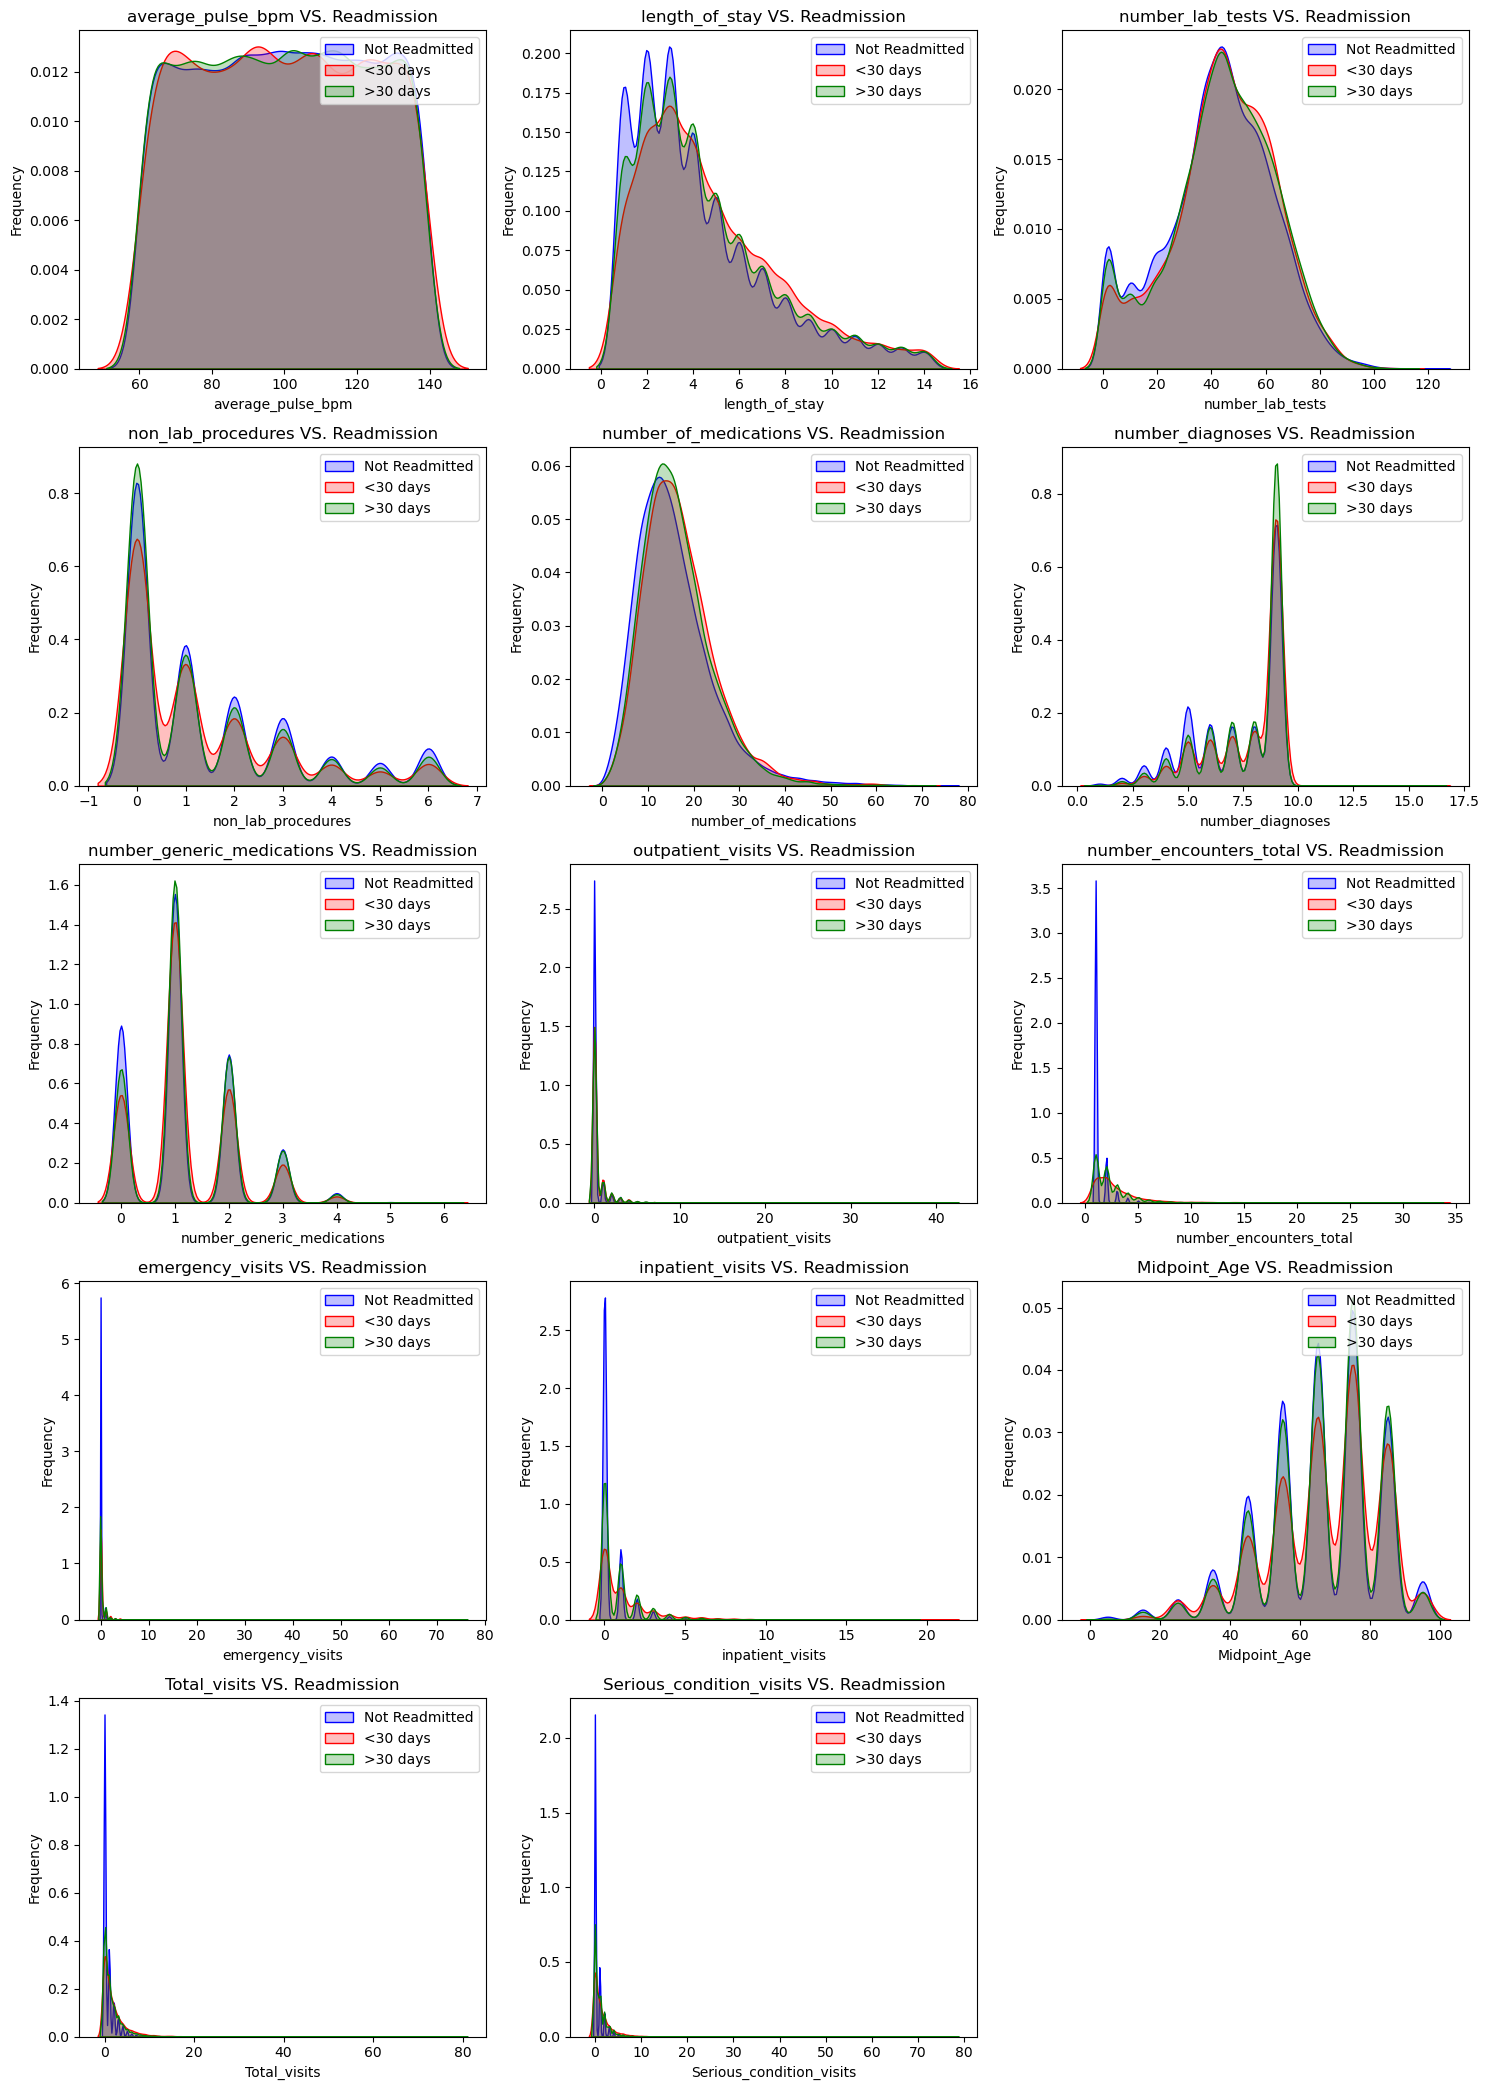

In [112]:
ncols = 3
nrows = int(np.ceil(len(metric_features) / 3))

fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 7*3))

# Flatten the axes array and remove extra subplots
axs = axs.flatten()
for ax in axs[len(metric_features):]:
    fig.delaxes(ax)

for idx, feature in enumerate(metric_features):   
    sns.kdeplot(train.loc[(train['readmitted_multiclass'] == 'No'), feature], color='b', shade=True, label='Not Readmitted', ax=axs[idx])
    sns.kdeplot(train.loc[(train['readmitted_multiclass'] == '<30 days'), feature], color='r', shade=True, label='<30 days', ax=axs[idx])
    sns.kdeplot(train.loc[(train['readmitted_multiclass'] == '>30 days'), feature], color='g', shade=True, label='>30 days', ax=axs[idx])
    
    axs[idx].set(xlabel=feature, ylabel='Frequency')
    axs[idx].set_title(f'{feature} VS. Readmission')
    axs[idx].legend()

plt.tight_layout()
plt.show()

--------------

In [113]:
X_multiclass = train.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_multiclass = train['readmitted_multiclass']

In [114]:
X_multiclass.columns

Index(['race', 'payer_code', 'outpatient_visits', 'emergency_visits',
       'inpatient_visits', 'admission_type', 'medical_specialty',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result', 'race_caucasian', 'number_generic_medications',
       'metformin', 'insulin', 'Sulfonylureas', 'Meglitinides',
       'Thiazolidinediones', 'Alpha_Glucosidase_Inhibitors',
       'Combination_Medications', 'Midpoint_Age', 'gender_binary',
       'presc_diabetes_meds_binary', 'change_in_meds_binary', 'Has_Insurance',
       'primary_diagnosis_types', 'secondary_diagnosis_types',
       'additional_diagnosis_types', 'is_normal_pulse',
       'number_encounters_total', 'Total_visits', 'Serious_condition_visits'],
      dtype='object')

In [115]:
X_multiclass.shape

(71236, 38)

In [116]:
y_multiclass.shape

(71236,)

# Outliers

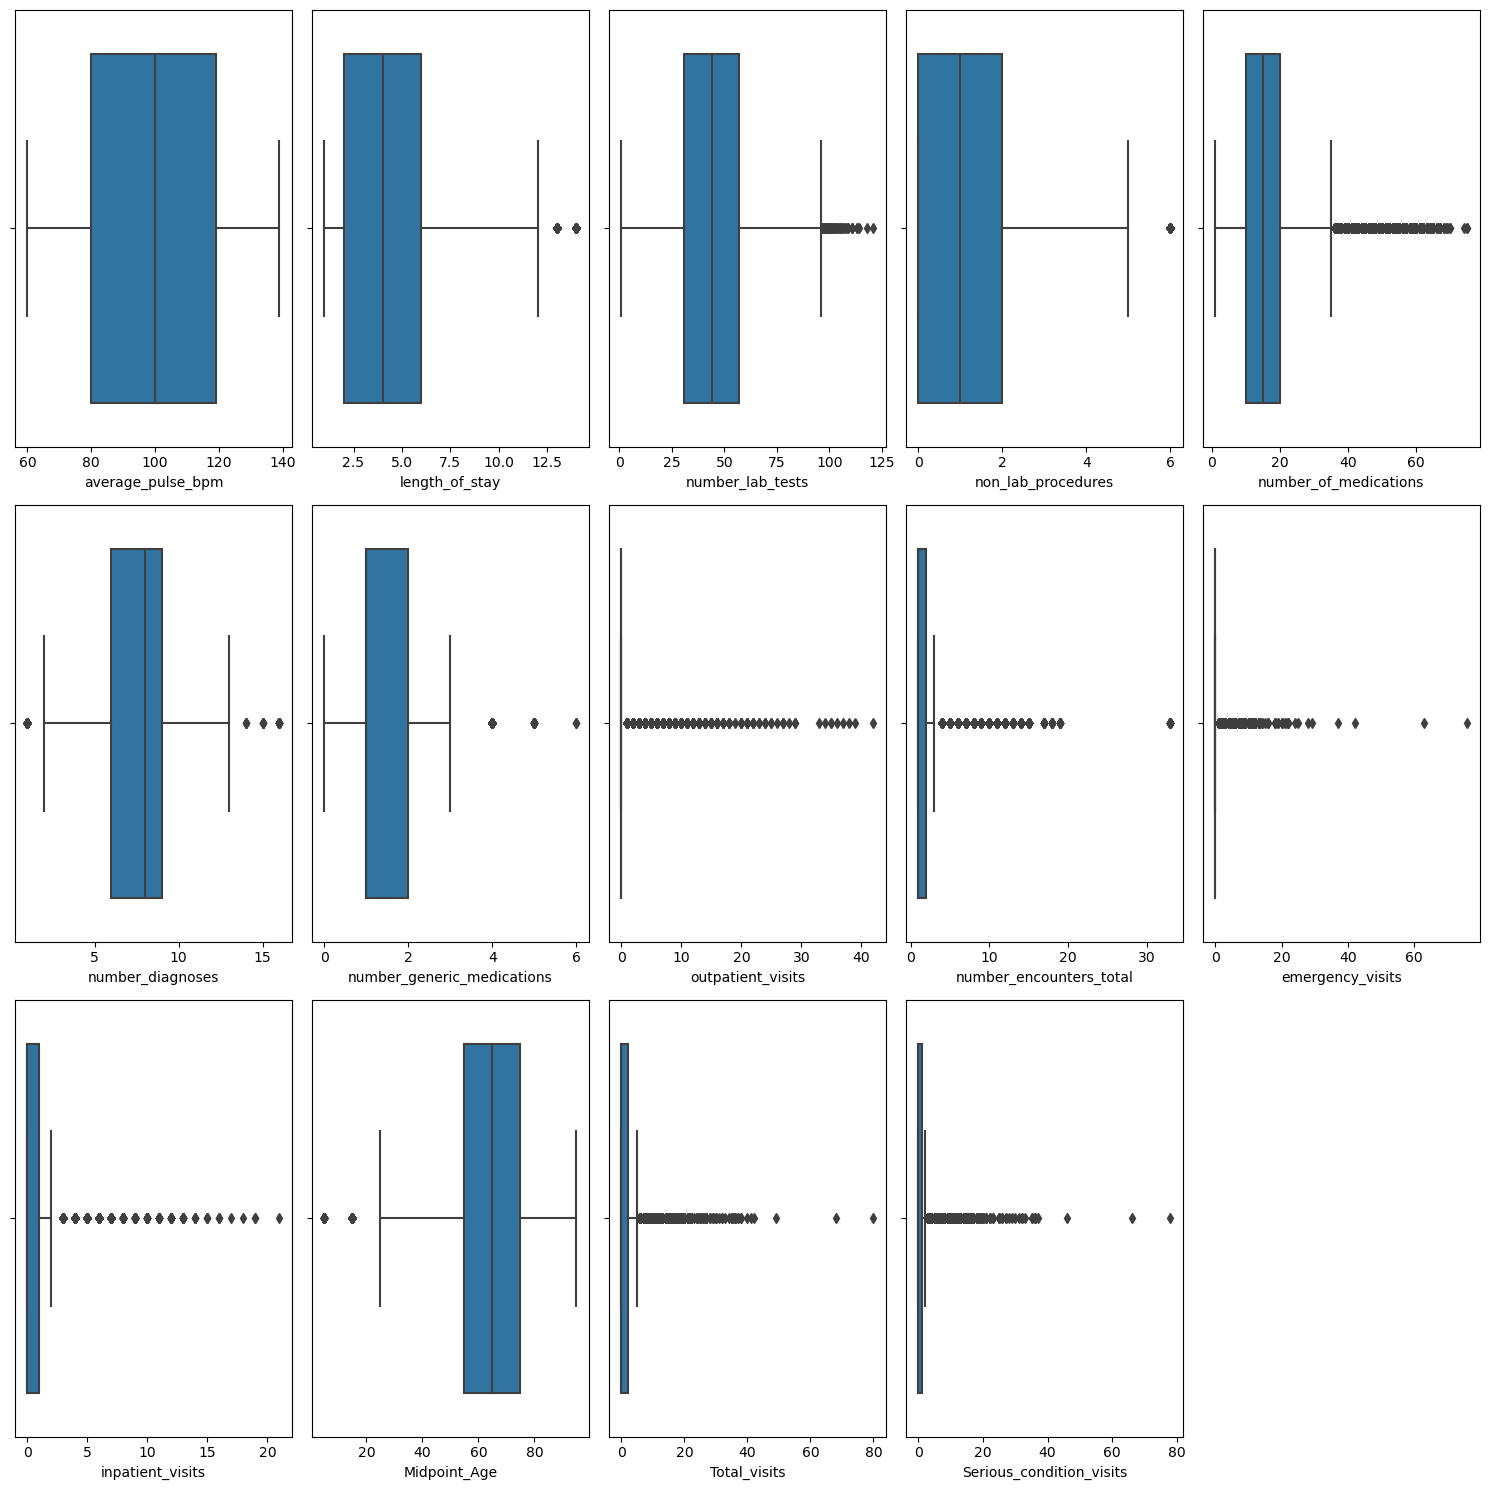

In [117]:
# Determine the number of rows needed for the plot
n_rows = int(np.ceil(len(metric_features) / 5))

# Create a figure and axes objects
fig, axs = plt.subplots(n_rows, 5, figsize=(15, n_rows * 5))

# Flatten the axes array and remove extra subplots
axs = axs.flatten()
for ax in axs[len(metric_features):]:
    fig.delaxes(ax)

# Create a boxplot for each column
for i, feature in enumerate(metric_features):
    sns.boxplot(x=X_multiclass[feature], ax=axs[i])

# Display the plot
plt.tight_layout()
plt.show()

------------

In [118]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(X,y) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
        
    print(result)

In [119]:
for columns in X_multiclass:
    TestIndependence(X_multiclass[columns],y_multiclass,columns)

race is IMPORTANT for Prediction
payer_code is IMPORTANT for Prediction
outpatient_visits is IMPORTANT for Prediction
emergency_visits is IMPORTANT for Prediction
inpatient_visits is IMPORTANT for Prediction
admission_type is IMPORTANT for Prediction
medical_specialty is IMPORTANT for Prediction
average_pulse_bpm is NOT an important predictor. (Discard average_pulse_bpm from model)
discharge_disposition is IMPORTANT for Prediction
admission_source is IMPORTANT for Prediction
length_of_stay is IMPORTANT for Prediction
number_lab_tests is IMPORTANT for Prediction
non_lab_procedures is IMPORTANT for Prediction
number_of_medications is IMPORTANT for Prediction
number_diagnoses is IMPORTANT for Prediction
glucose_test_result is IMPORTANT for Prediction
a1c_test_result is IMPORTANT for Prediction
race_caucasian is IMPORTANT for Prediction
number_generic_medications is IMPORTANT for Prediction
metformin is IMPORTANT for Prediction
insulin is IMPORTANT for Prediction
Sulfonylureas is IMPORTANT

In [120]:
categorical_columns = ['race','payer_code','admission_type','medical_specialty','discharge_disposition','admission_source',
                      'primary_diagnosis_types', 'secondary_diagnosis_types','additional_diagnosis_types','glucose_test_result',
                      'a1c_test_result','race_caucasian','metformin','insulin','Sulfonylureas','Meglitinides',
                      'Thiazolidinediones','Alpha_Glucosidase_Inhibitors','Combination_Medications','gender_binary',
                      'presc_diabetes_meds_binary','change_in_meds_binary','Has_Insurance','is_normal_pulse']

In [121]:
X_multiclass.columns

Index(['race', 'payer_code', 'outpatient_visits', 'emergency_visits',
       'inpatient_visits', 'admission_type', 'medical_specialty',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result', 'race_caucasian', 'number_generic_medications',
       'metformin', 'insulin', 'Sulfonylureas', 'Meglitinides',
       'Thiazolidinediones', 'Alpha_Glucosidase_Inhibitors',
       'Combination_Medications', 'Midpoint_Age', 'gender_binary',
       'presc_diabetes_meds_binary', 'change_in_meds_binary', 'Has_Insurance',
       'primary_diagnosis_types', 'secondary_diagnosis_types',
       'additional_diagnosis_types', 'is_normal_pulse',
       'number_encounters_total', 'Total_visits', 'Serious_condition_visits'],
      dtype='object')

In [122]:
X_multiclass.to_csv('X_multiclass_ne.csv', index=True)
y_multiclass.to_csv('y_multiclass_ne.csv', index=True)

# Encoding categorical variables

In [123]:
X_multiclass.columns

Index(['race', 'payer_code', 'outpatient_visits', 'emergency_visits',
       'inpatient_visits', 'admission_type', 'medical_specialty',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result', 'race_caucasian', 'number_generic_medications',
       'metformin', 'insulin', 'Sulfonylureas', 'Meglitinides',
       'Thiazolidinediones', 'Alpha_Glucosidase_Inhibitors',
       'Combination_Medications', 'Midpoint_Age', 'gender_binary',
       'presc_diabetes_meds_binary', 'change_in_meds_binary', 'Has_Insurance',
       'primary_diagnosis_types', 'secondary_diagnosis_types',
       'additional_diagnosis_types', 'is_normal_pulse',
       'number_encounters_total', 'Total_visits', 'Serious_condition_visits'],
      dtype='object')

In [124]:
columns_to_encode = ['race','payer_code','admission_type','medical_specialty','discharge_disposition',
                     'admission_source','primary_diagnosis_types','secondary_diagnosis_types',
                     'additional_diagnosis_types','glucose_test_result','a1c_test_result']

other_columns_train = pd.DataFrame(X_multiclass.drop(columns_to_encode, axis=1))

In [125]:
# count encoder
count_encoder = ce.CountEncoder(cols=columns_to_encode)

# fit and transform on your data
count_encoder.fit(X_multiclass[columns_to_encode])
train_encoded_1 = count_encoder.transform(X_multiclass[columns_to_encode])
train_encoded_1

,race,payer_code,admission_type,medical_specialty,discharge_disposition,admission_source,primary_diagnosis_types,secondary_diagnosis_types,additional_diagnosis_types,glucose_test_result,a1c_test_result
encounter_id,,,,,,,,,,,
533253,51779,28201,50779,5217,51342,40319,7291,5746,4729,67548,59320
426224,12977,28201,50779,34922,12978,21586,1968,3194,1297,67548,59320
634063,51779,28201,7246,5217,51342,4913,6476,1358,11927,67548,59320
890610,12977,22683,50779,13017,51342,4418,6476,2747,20959,67548,59320
654194,51779,4319,13211,34922,51342,21586,3443,5608,20959,67548,59320
...,...,...,...,...,...,...,...,...,...,...,...
660160,12977,22683,13211,13017,51342,21586,21223,3194,11927,67548,8413
826429,12977,28201,50779,34922,3269,21586,2424,1765,4550,67548,8413
332030,51779,28201,7246,34922,3269,4913,21223,7192,6368,1882,59320


In [126]:
X_multiclass_encoded = pd.concat([train_encoded_1, other_columns_train], axis=1)
X_multiclass_encoded

,race,payer_code,admission_type,medical_specialty,discharge_disposition,admission_source,primary_diagnosis_types,secondary_diagnosis_types,additional_diagnosis_types,glucose_test_result,...,Combination_Medications,Midpoint_Age,gender_binary,presc_diabetes_meds_binary,change_in_meds_binary,Has_Insurance,is_normal_pulse,number_encounters_total,Total_visits,Serious_condition_visits
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,51779,28201,50779,5217,51342,40319,7291,5746,4729,67548,...,0,75.0,0,0,0,0,0,6,2,2
426224,12977,28201,50779,34922,12978,21586,1968,3194,1297,67548,...,0,55.0,1,1,0,0,0,1,0,0
634063,51779,28201,7246,5217,51342,4913,6476,1358,11927,67548,...,0,65.0,0,1,1,0,1,1,1,1
890610,12977,22683,50779,13017,51342,4418,6476,2747,20959,67548,...,0,65.0,1,0,0,1,1,1,1,1
654194,51779,4319,13211,34922,51342,21586,3443,5608,20959,67548,...,0,75.0,0,0,0,1,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660160,12977,22683,13211,13017,51342,21586,21223,3194,11927,67548,...,0,85.0,0,1,1,1,1,1,1,1
826429,12977,28201,50779,34922,3269,21586,2424,1765,4550,67548,...,0,75.0,0,1,1,0,0,1,0,0
332030,51779,28201,7246,34922,3269,4913,21223,7192,6368,1882,...,0,65.0,0,1,1,0,0,4,4,4


In [127]:
for categorical_columns in X_multiclass_encoded:
    TestIndependence(X_multiclass_encoded[categorical_columns],y_multiclass, categorical_columns)

race is IMPORTANT for Prediction
payer_code is IMPORTANT for Prediction
admission_type is IMPORTANT for Prediction
medical_specialty is IMPORTANT for Prediction
discharge_disposition is IMPORTANT for Prediction
admission_source is IMPORTANT for Prediction
primary_diagnosis_types is IMPORTANT for Prediction
secondary_diagnosis_types is IMPORTANT for Prediction
additional_diagnosis_types is IMPORTANT for Prediction
glucose_test_result is IMPORTANT for Prediction
a1c_test_result is IMPORTANT for Prediction
outpatient_visits is IMPORTANT for Prediction
emergency_visits is IMPORTANT for Prediction
inpatient_visits is IMPORTANT for Prediction
average_pulse_bpm is NOT an important predictor. (Discard average_pulse_bpm from model)
length_of_stay is IMPORTANT for Prediction
number_lab_tests is IMPORTANT for Prediction
non_lab_procedures is IMPORTANT for Prediction
number_of_medications is IMPORTANT for Prediction
number_diagnoses is IMPORTANT for Prediction
race_caucasian is IMPORTANT for Predi

In [128]:
X_multiclass_encoded.shape

(71236, 38)

## Imputing age

In [129]:
X_multiclass_encoded['Midpoint_Age'].value_counts()

Midpoint_Age
75.0    17719
65.0    15164
85.0    11755
55.0    11664
45.0     6541
35.0     2584
95.0     1910
25.0     1096
15.0      481
5.0       105
Name: count, dtype: int64

In [130]:
X_multiclass_encoded['Midpoint_Age'].isna().sum()

2217

In [131]:
known_age = X_multiclass_encoded[X_multiclass_encoded['Midpoint_Age'].notnull()]
unknown_age = X_multiclass_encoded[X_multiclass_encoded['Midpoint_Age'].isnull()]

# Reset indices
known_age = known_age.reset_index(drop=True)
unknown_age = unknown_age.reset_index(drop=True)

# Create the training data for the model
X = known_age.drop(['Midpoint_Age'], axis=1)
y = known_age['Midpoint_Age']

# Fit the model
regr = RandomForestRegressor(random_state=0, n_estimators=200, n_jobs=-1)
regr.fit(X, y)

# Predict the missing ages
predicted_ages = regr.predict(unknown_age.drop(['Midpoint_Age'], axis=1))

# Fill in the missing values using the original indices
X_multiclass_encoded.loc[X_multiclass_encoded['Midpoint_Age'].isnull(), 'Midpoint_Age'] = predicted_ages

In [132]:
X_multiclass_encoded['Midpoint_Age'].isna().sum()

0

In [133]:
X_multiclass_encoded.head()

,race,payer_code,admission_type,medical_specialty,discharge_disposition,admission_source,primary_diagnosis_types,secondary_diagnosis_types,additional_diagnosis_types,glucose_test_result,...,Combination_Medications,Midpoint_Age,gender_binary,presc_diabetes_meds_binary,change_in_meds_binary,Has_Insurance,is_normal_pulse,number_encounters_total,Total_visits,Serious_condition_visits
encounter_id,,,,,,,,,,,,,,,,,,,,,
533253,51779,28201,50779,5217,51342,40319,7291,5746,4729,67548,...,0,75.0,0,0,0,0,0,6,2,2
426224,12977,28201,50779,34922,12978,21586,1968,3194,1297,67548,...,0,55.0,1,1,0,0,0,1,0,0
634063,51779,28201,7246,5217,51342,4913,6476,1358,11927,67548,...,0,65.0,0,1,1,0,1,1,1,1
890610,12977,22683,50779,13017,51342,4418,6476,2747,20959,67548,...,0,65.0,1,0,0,1,1,1,1,1
654194,51779,4319,13211,34922,51342,21586,3443,5608,20959,67548,...,0,75.0,0,0,0,1,0,2,1,0


In [134]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_multiclass_encoded = pd.DataFrame(label_encoder.fit_transform(y_multiclass))
y_multiclass_encoded.set_index(y_multiclass.index, inplace=True)

In [135]:
y_multiclass_encoded

,0
encounter_id,
533253,1
426224,2
634063,2
890610,2
654194,1
...,...
660160,2
826429,2
332030,0


In [136]:
X_multiclass_encoded.columns

Index(['race', 'payer_code', 'admission_type', 'medical_specialty',
       'discharge_disposition', 'admission_source', 'primary_diagnosis_types',
       'secondary_diagnosis_types', 'additional_diagnosis_types',
       'glucose_test_result', 'a1c_test_result', 'outpatient_visits',
       'emergency_visits', 'inpatient_visits', 'average_pulse_bpm',
       'length_of_stay', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'race_caucasian',
       'number_generic_medications', 'metformin', 'insulin', 'Sulfonylureas',
       'Meglitinides', 'Thiazolidinediones', 'Alpha_Glucosidase_Inhibitors',
       'Combination_Medications', 'Midpoint_Age', 'gender_binary',
       'presc_diabetes_meds_binary', 'change_in_meds_binary', 'Has_Insurance',
       'is_normal_pulse', 'number_encounters_total', 'Total_visits',
       'Serious_condition_visits'],
      dtype='object')

In [137]:
X_multiclass_encoded.to_csv('X_multiclass.csv', index=True)
y_multiclass_encoded.to_csv('y_multiclass.csv', index=True)